In [11]:
import imutils
from imutils import contours 
from skimage import measure  
import numpy as np          
import argparse
import cv2
import matplotlib.pyplot as plt
import os
import time

%matplotlib inline
from vlcs_mobile import copyVideo


In [12]:
def plot_imshow_in_array(matrices_to_show:list , max_image_in_row:int = 4 , plots_kwargs_list:list = []):
    """
        Plots the image list in an array of row * col , where max(col) = max_image_in_row, and the 
        number of rows is calculated accordingly. 
        @param matrices_to_show a list of matrices to be plotted using plt.imshow
        @param max_image_in_row maximum number of plots in one row
        @param plots_kwargs_list list of dictionaries of parameters of each plot
        
    """    
    ## total number of plots
    plot_count = len(matrices_to_show)
    
    assert len(plots_kwargs_list) == 0 or len(plots_kwargs_list) == len(matrices_to_show) , """ plots_kwargs_list should be either an empty 
                                                                                    list or should have the same number of members
                                                                                    as matrices_to_show """
    
    ## number of rows
    nrow = plot_count // max_image_in_row + (1 if (plot_count % max_image_in_row > 0) else 0)
    
    ## number of columns
    ncol = max_image_in_row if plot_count >= max_image_in_row else plot_count
    
    ## plotting using imshow
    fig , ax = plt.subplots(nrow , ncol , figsize = (12 , 6))
    for i in range(plot_count):
        
        ## select the subplot
        plt.subplot(nrow , ncol , i+1 )
        
        ## format the argument dictionary of the imshow function
        if(len(plots_kwargs_list) == 0):
            config_dict = {}
        else: 
            config_dict = plots_kwargs_list[i]
        
        ## pass the image as well as extra arguments to the imshow function
        plt.imshow(matrices_to_show[i] , **config_dict)
        
    return fig , ax 
    

In [13]:
def split_video(input_video_path, output_folder):
    # open the video
    cap = cv2.VideoCapture(input_video_path)
    
    # get the fps of video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # calculate frames per second
    frames_per_second = fps
    frames_per_clip = frames_per_second * 1
    
    for i in range(5):
        output_video_path = f"{output_folder}/clip_{i+1}.mp4"
        writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (int(cap.get(3)),int(cap.get(4))))

        for _ in range(frames_per_clip):
            ret, frame = cap.read()
            if not ret:
                break
            writer.write(frame)

        writer.release()
    cap.release()

In [14]:
split_video("./resources/rolling_shutter.mp4", "rolling_shutter")

5
150


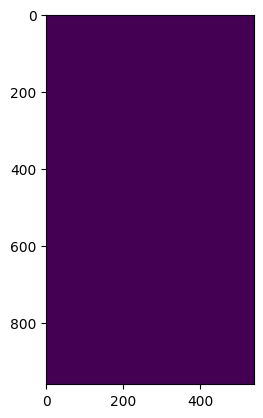

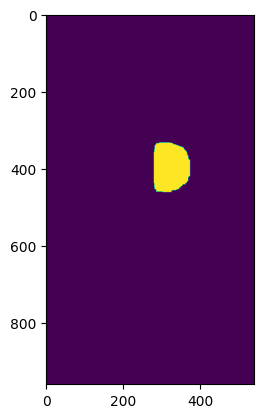

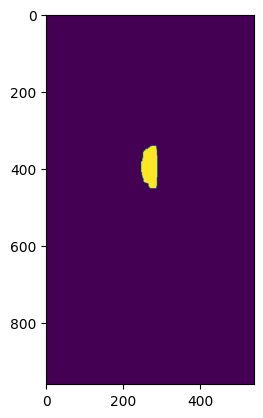

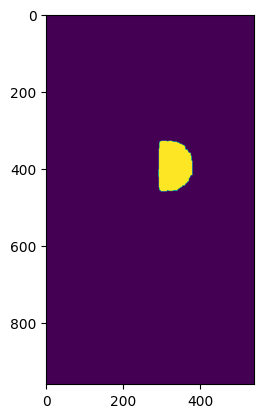

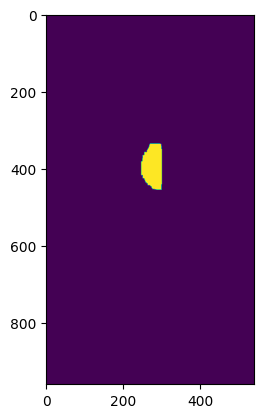

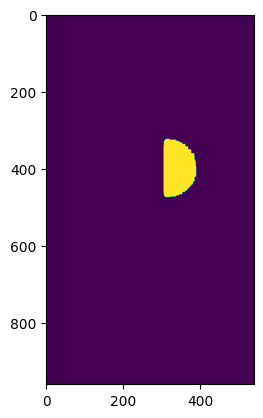

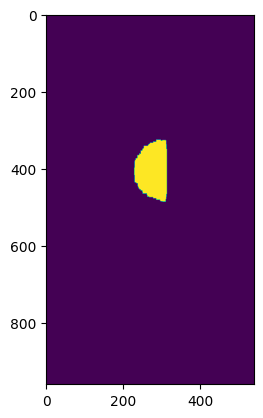

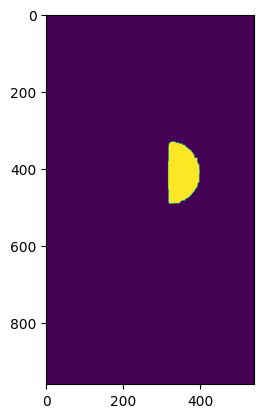

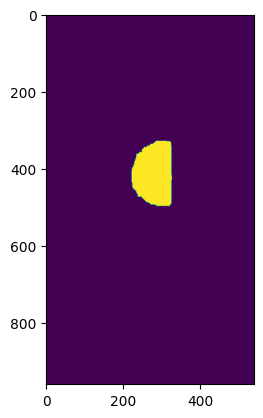

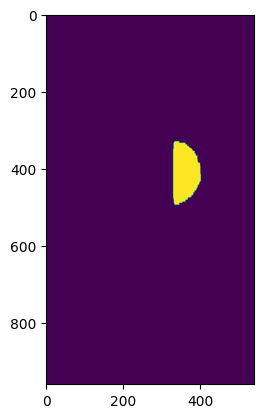

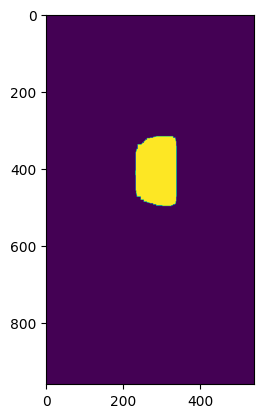

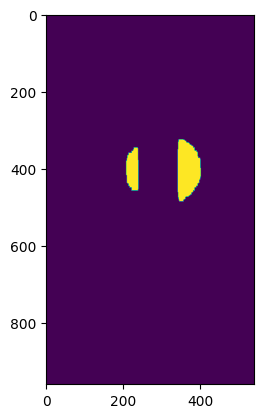

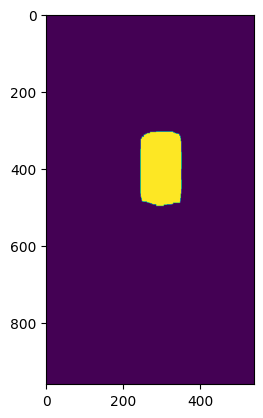

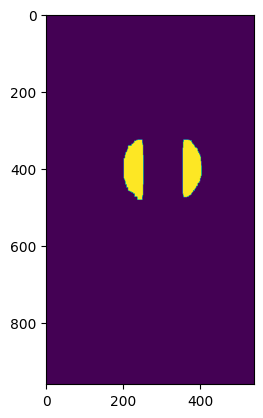

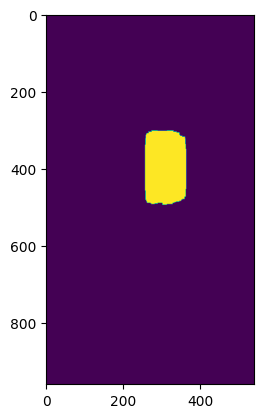

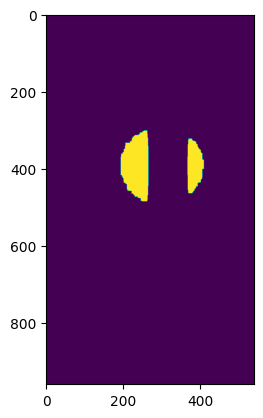

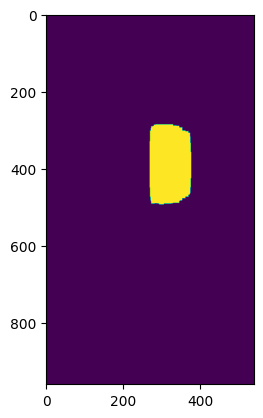

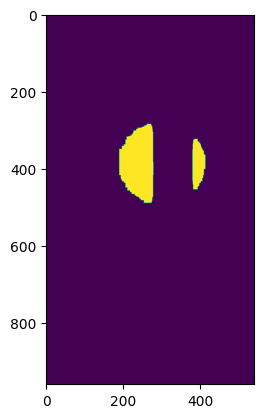

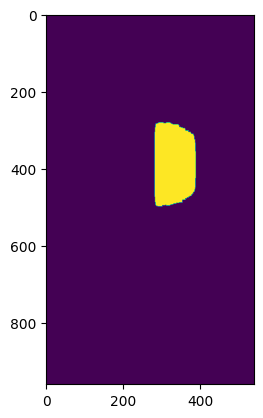

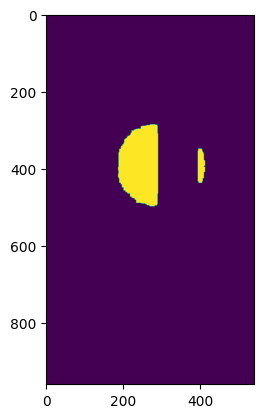

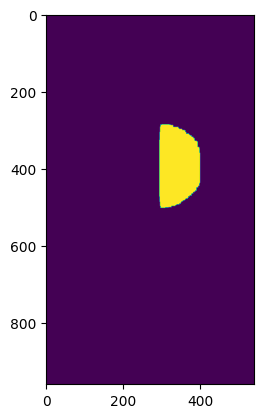

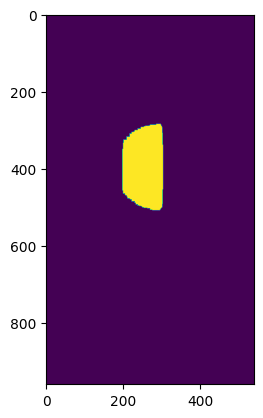

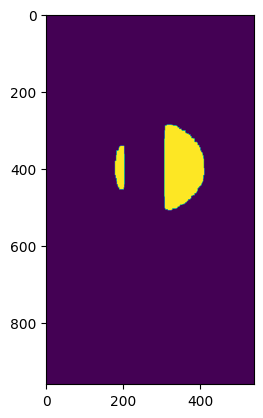

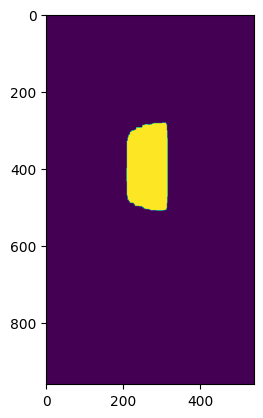

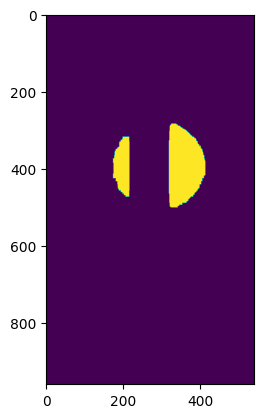

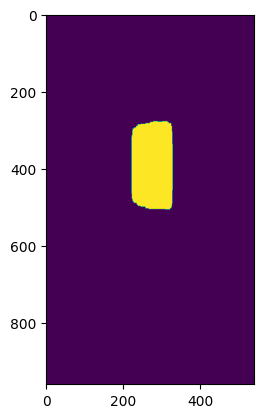

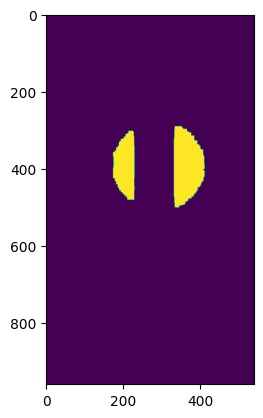

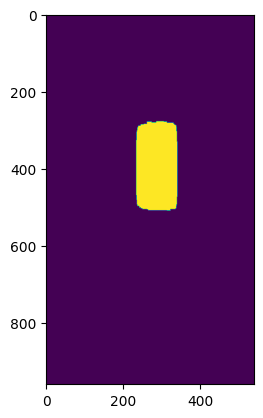

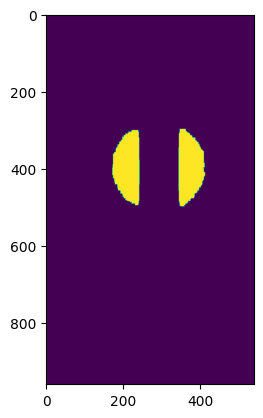

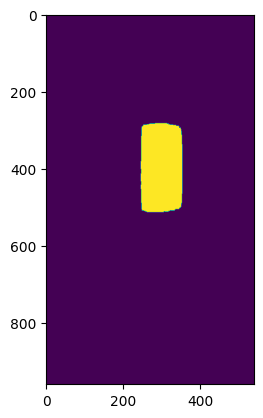

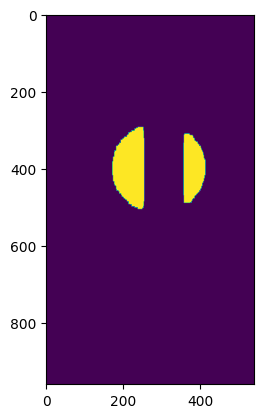

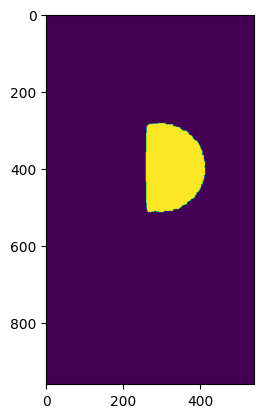

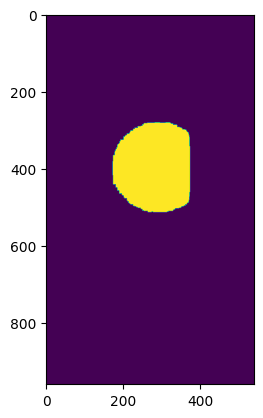

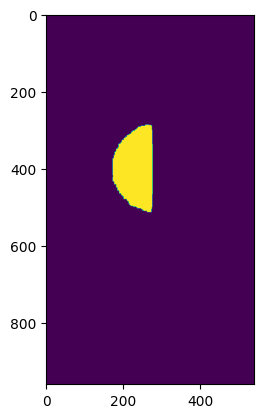

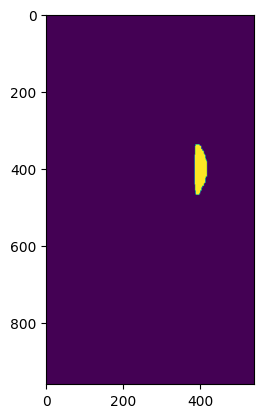

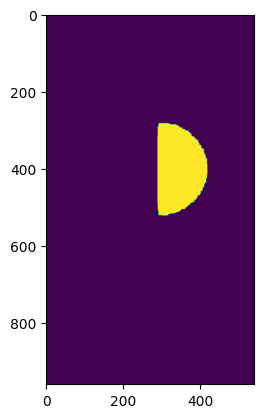

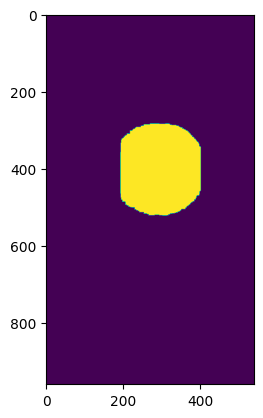

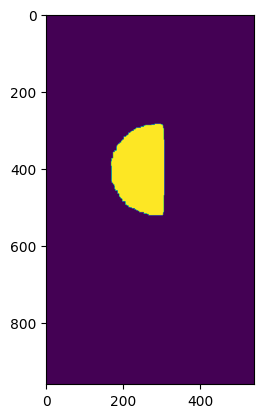

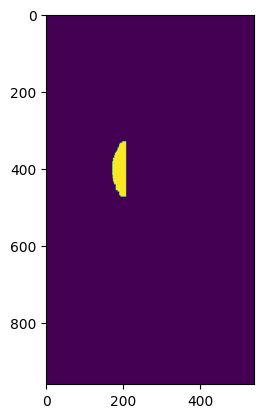

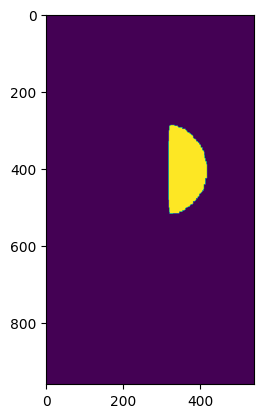

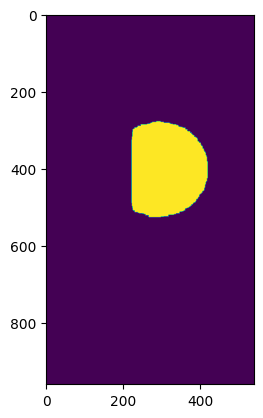

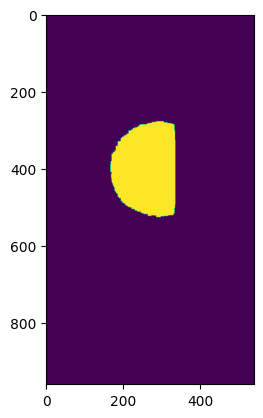

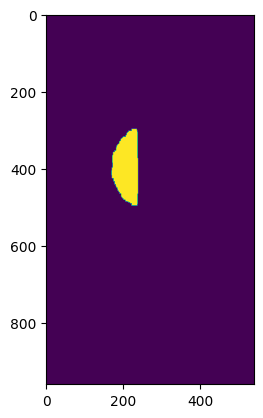

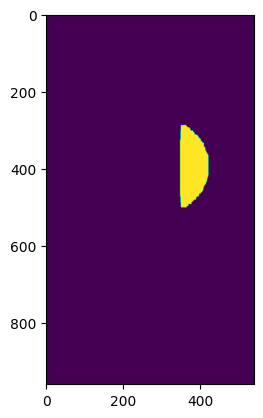

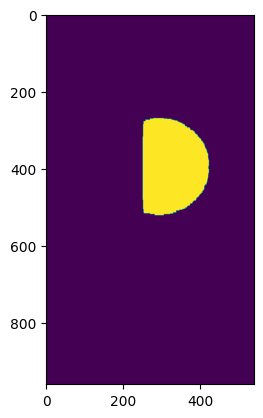

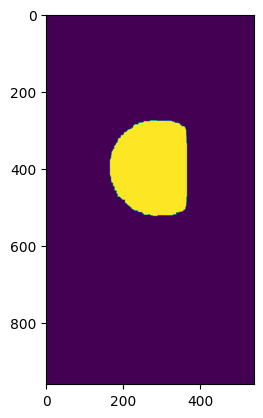

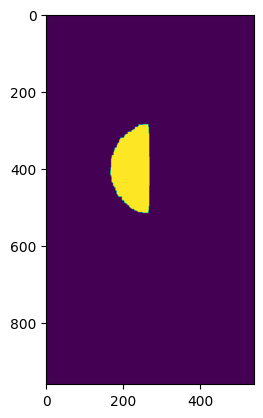

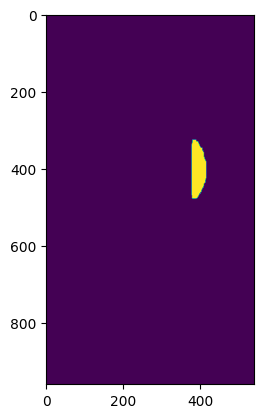

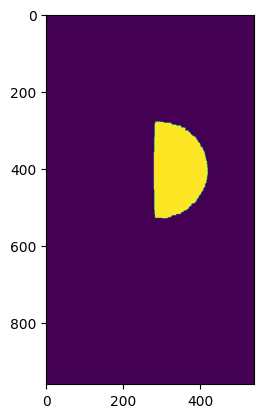

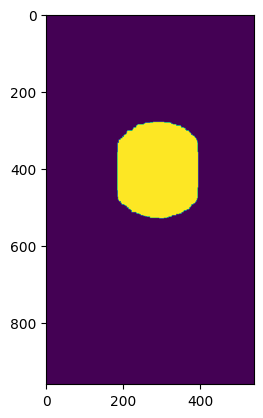

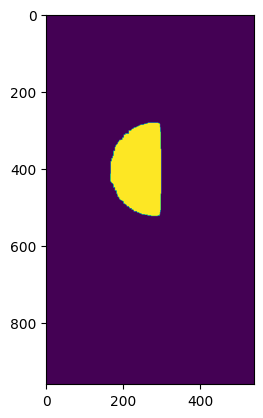

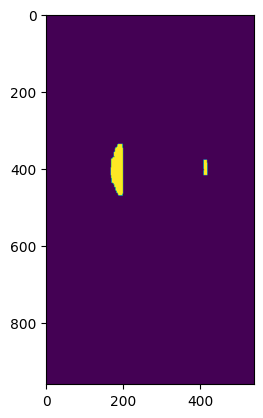

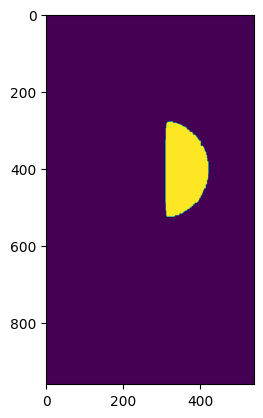

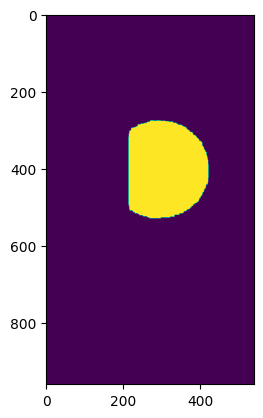

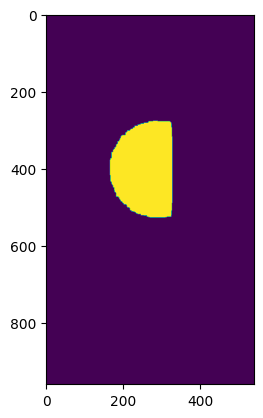

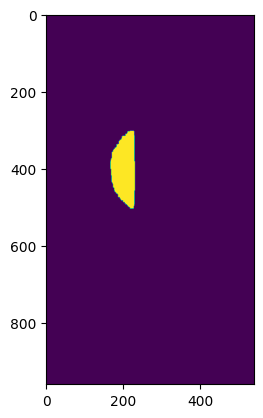

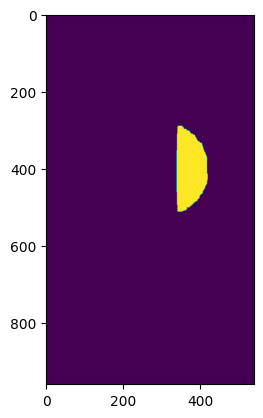

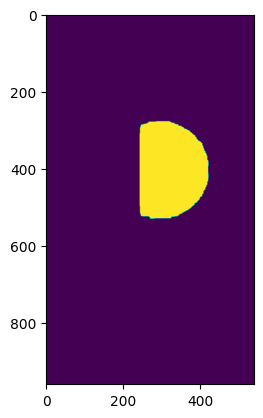

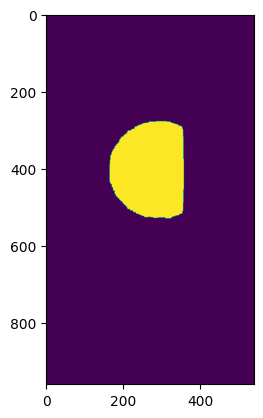

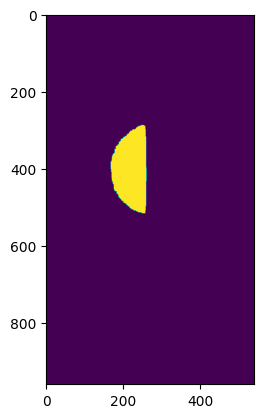

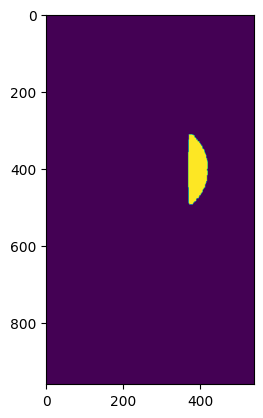

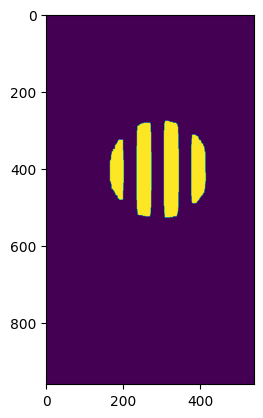

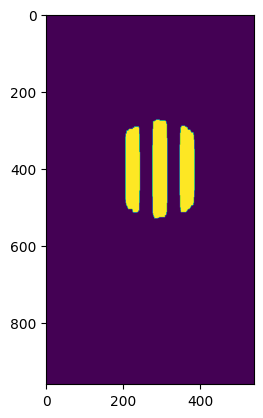

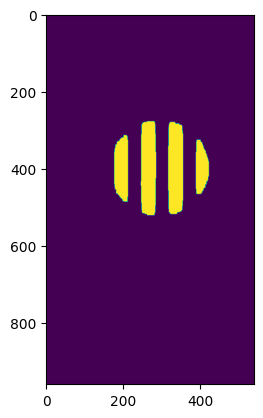

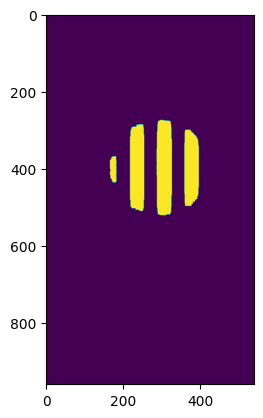

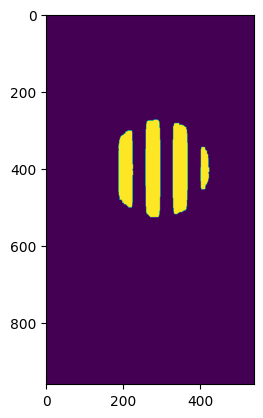

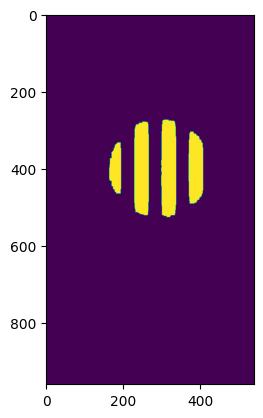

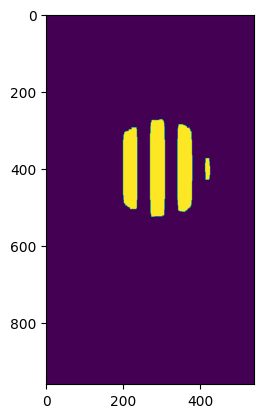

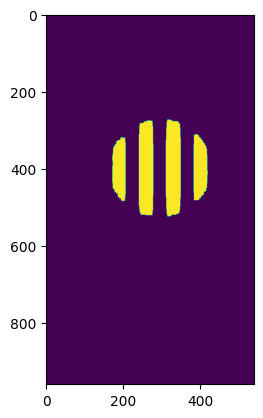

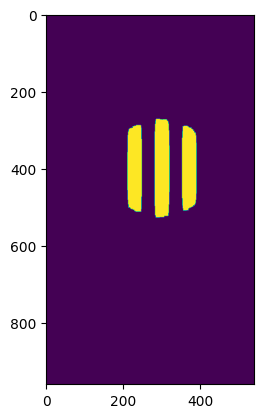

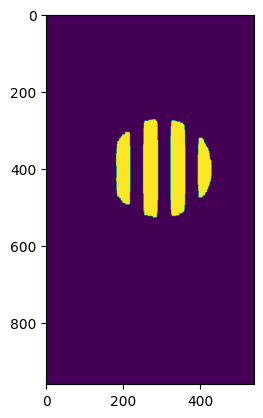

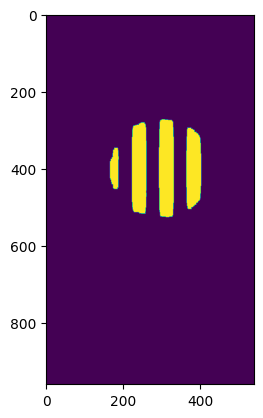

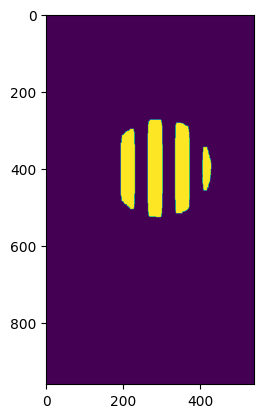

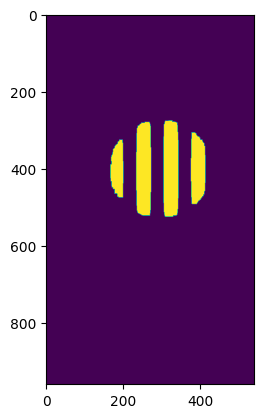

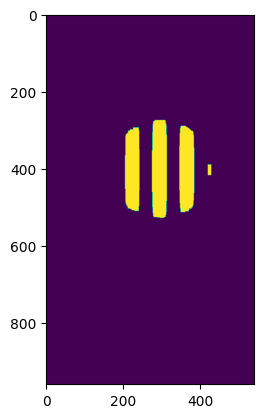

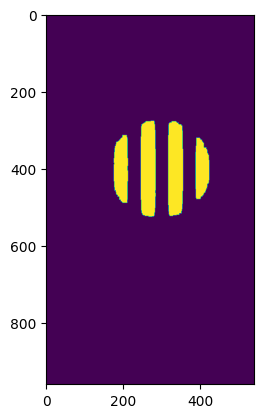

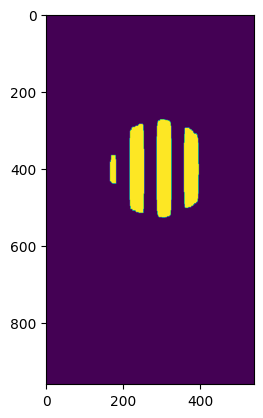

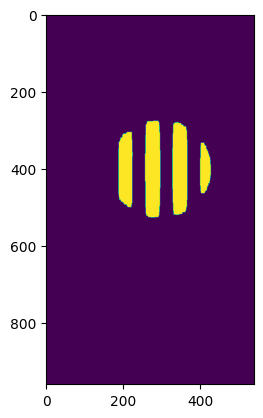

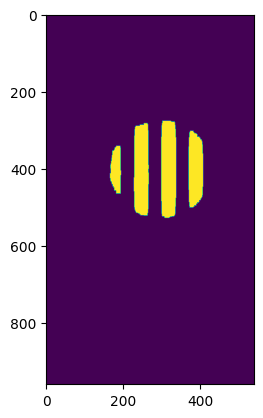

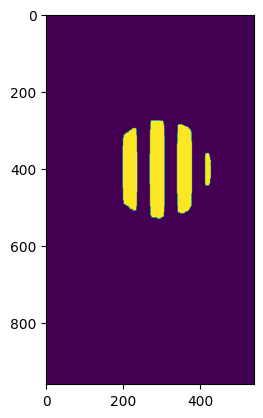

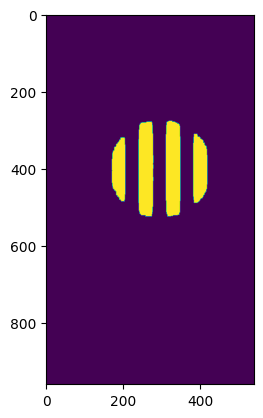

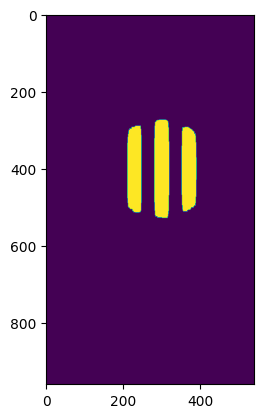

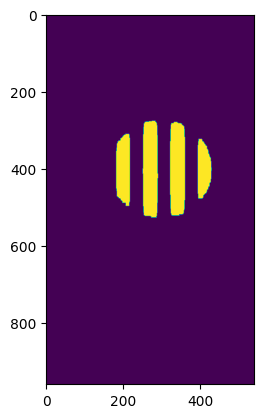

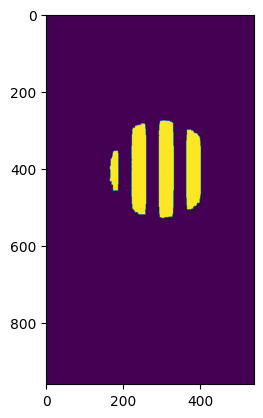

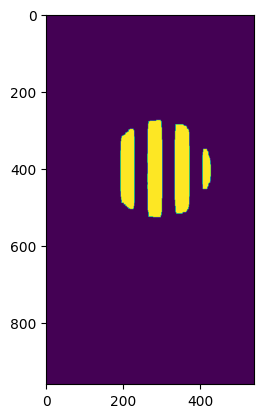

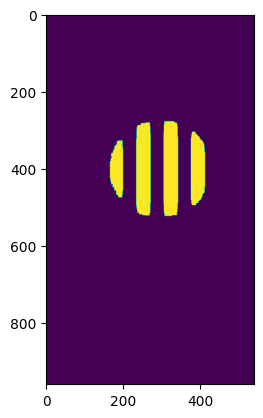

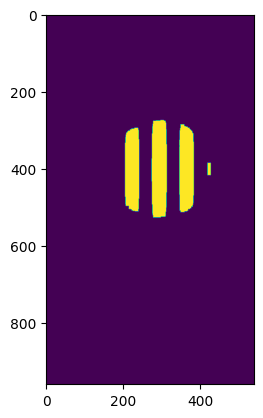

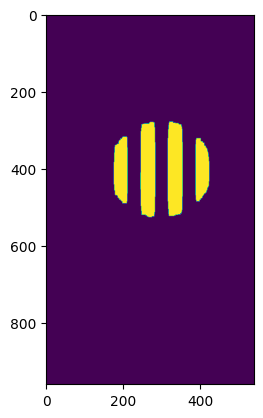

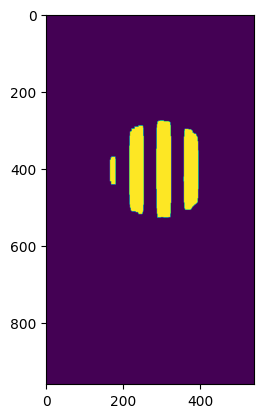

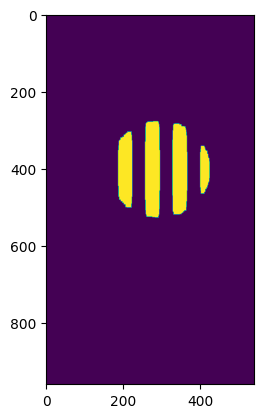

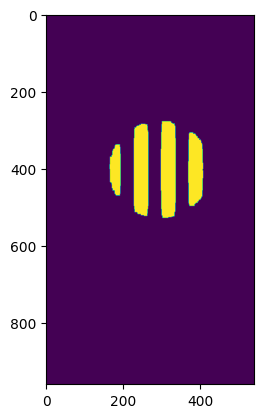

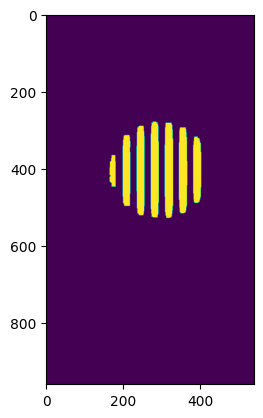

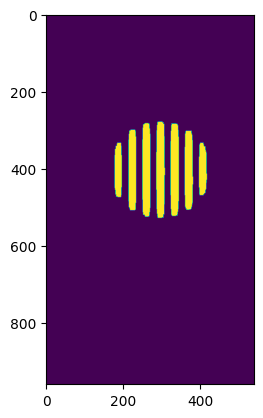

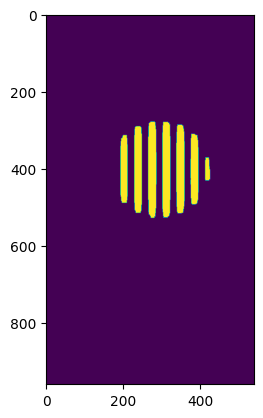

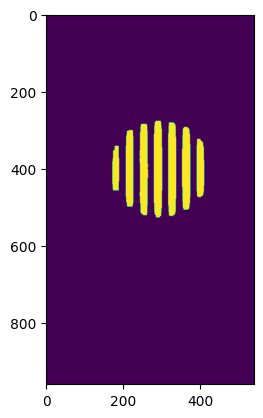

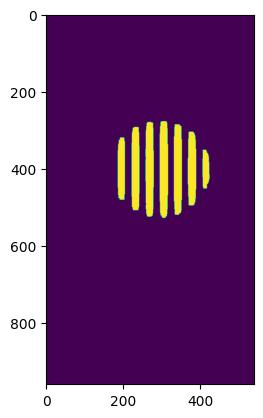

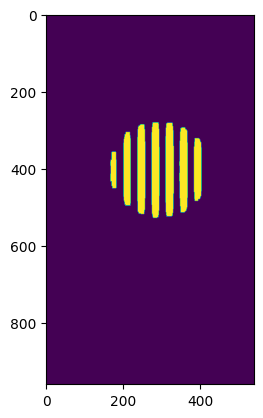

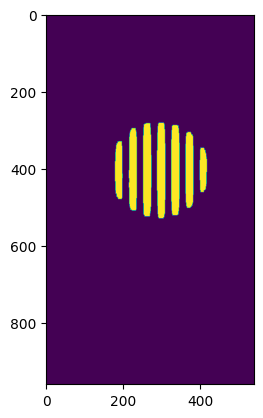

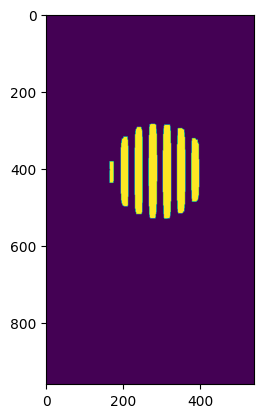

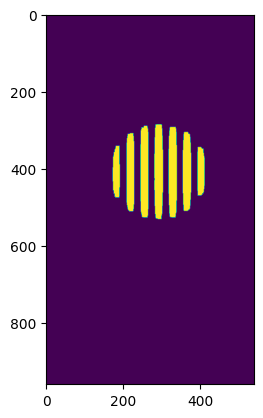

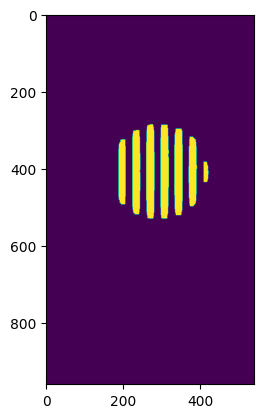

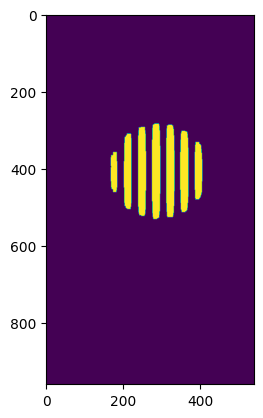

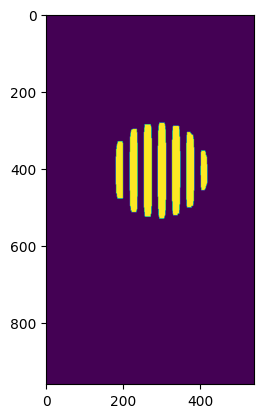

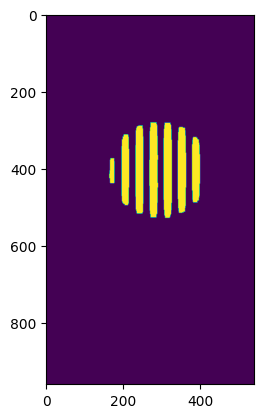

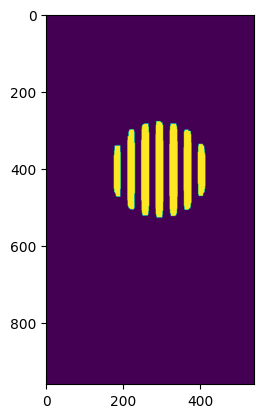

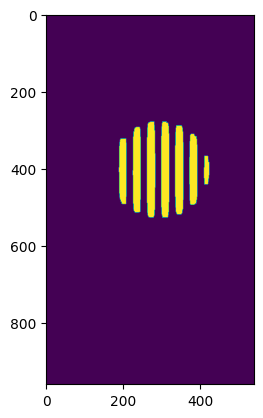

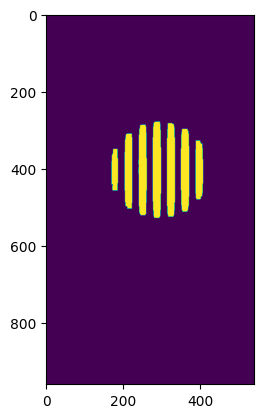

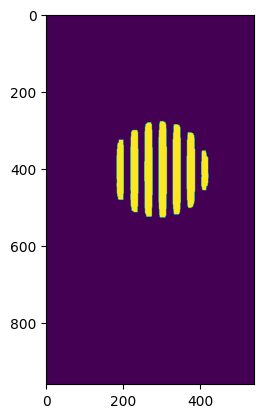

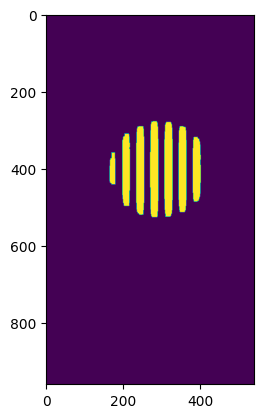

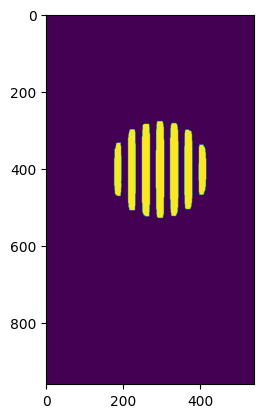

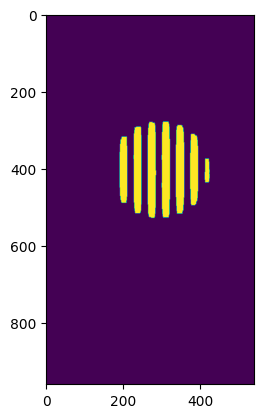

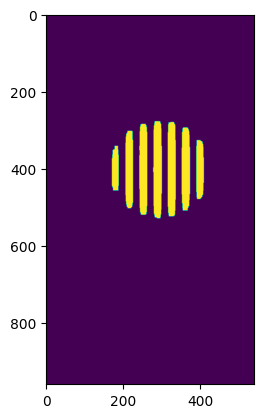

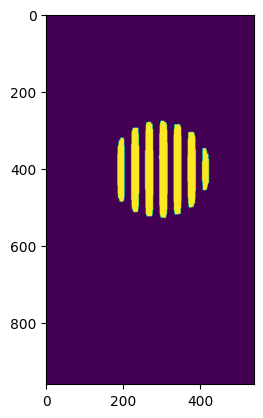

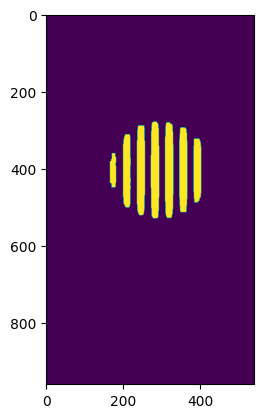

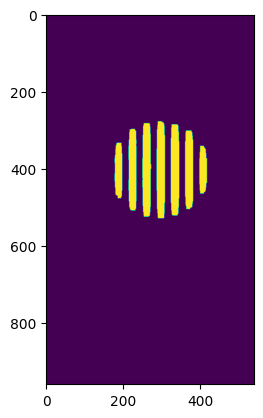

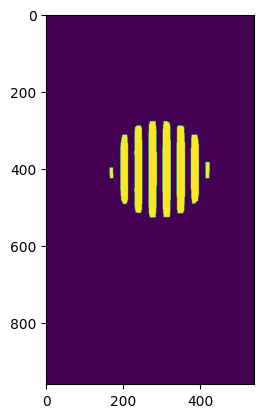

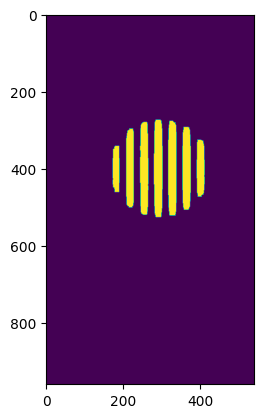

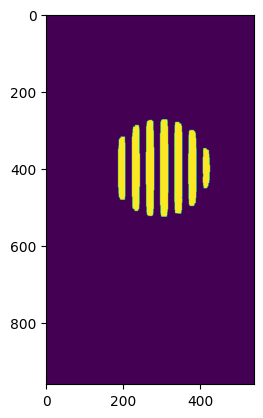

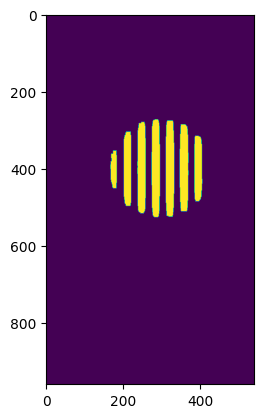

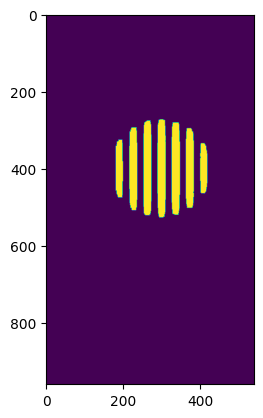

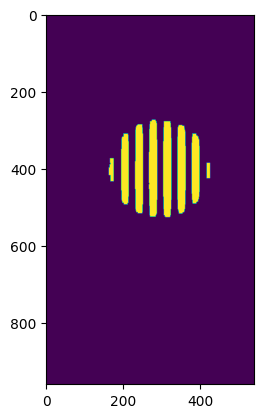

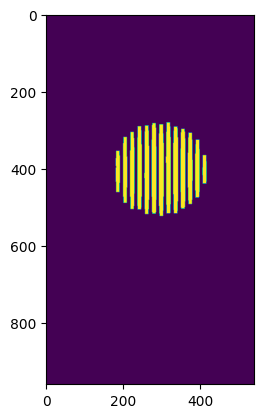

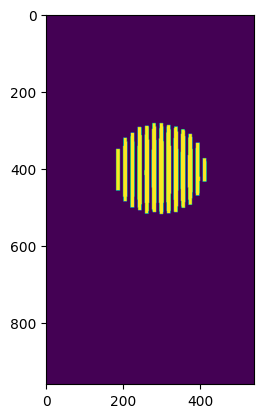

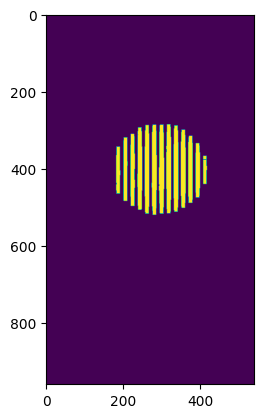

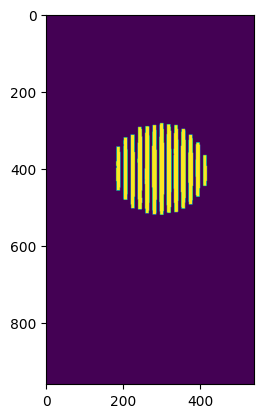

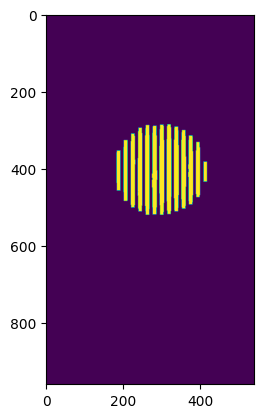

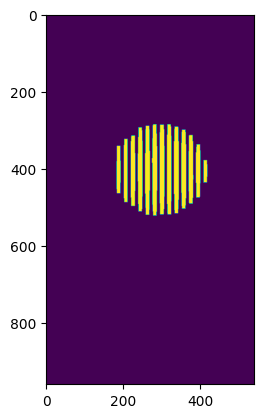

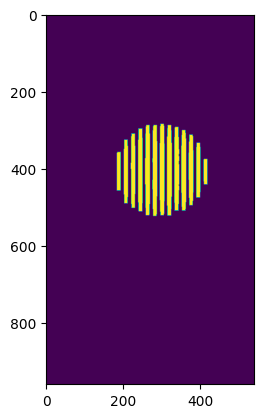

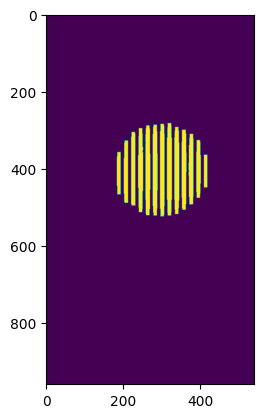

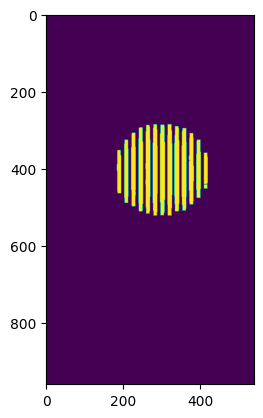

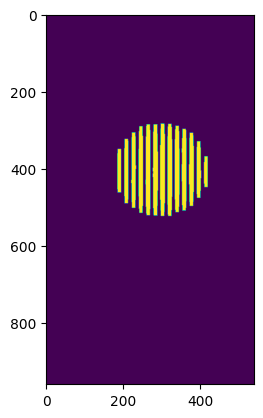

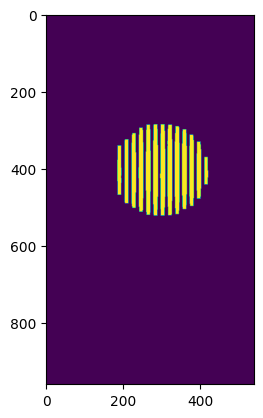

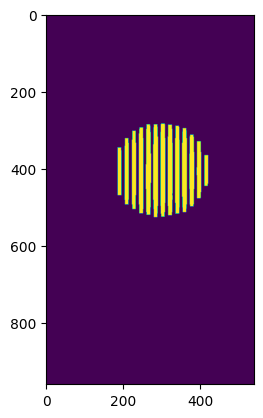

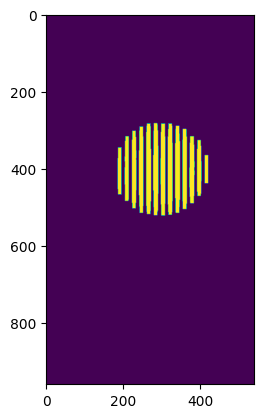

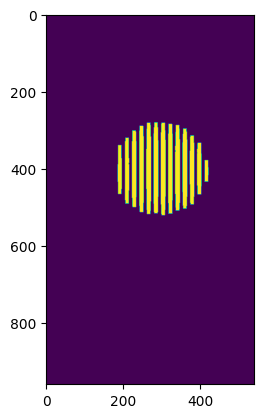

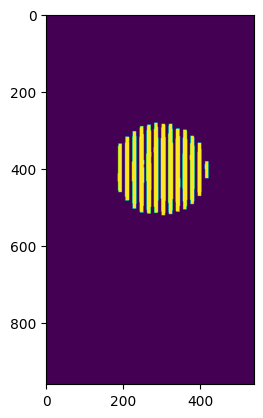

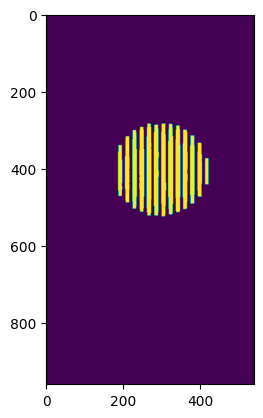

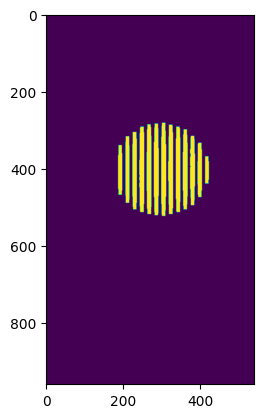

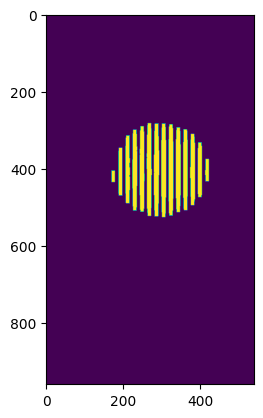

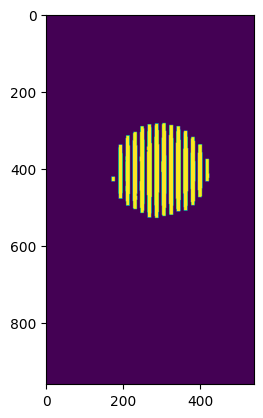

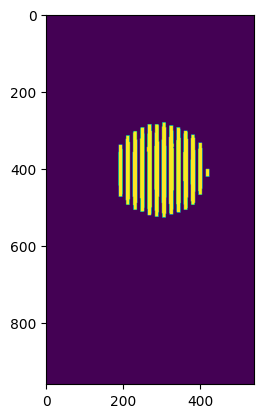

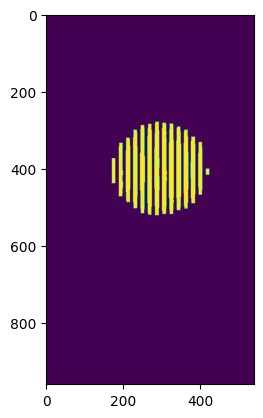

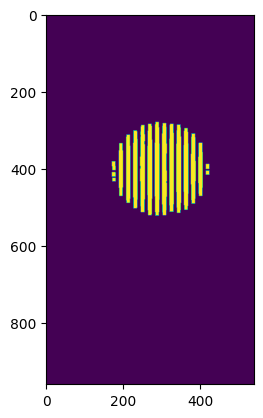

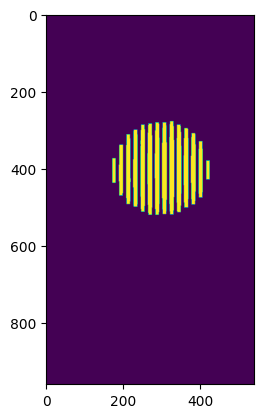

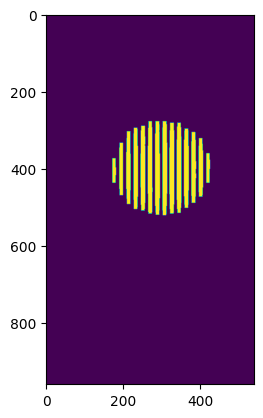

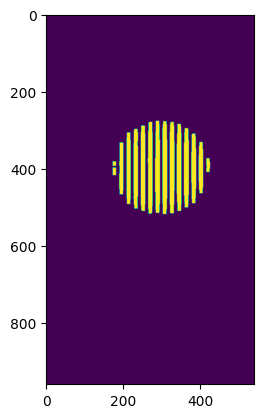

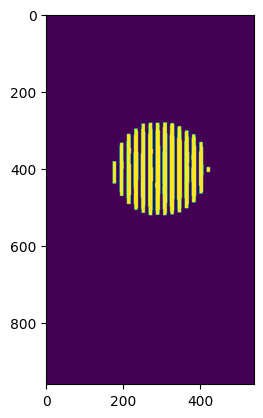

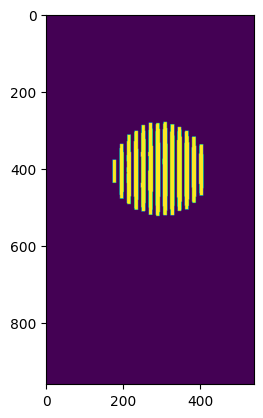

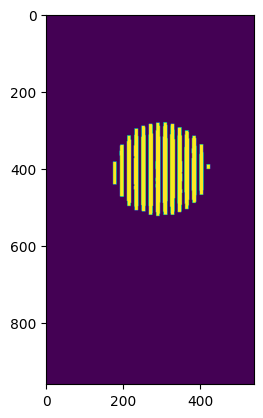

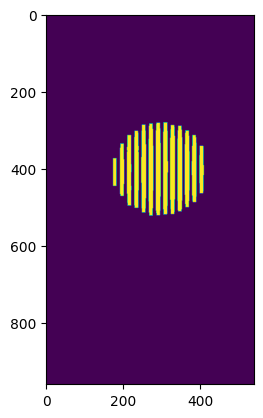

150


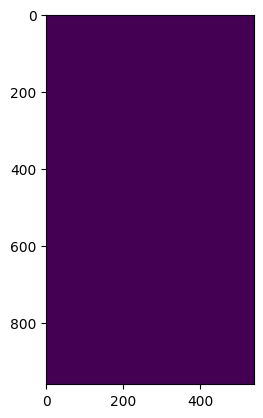

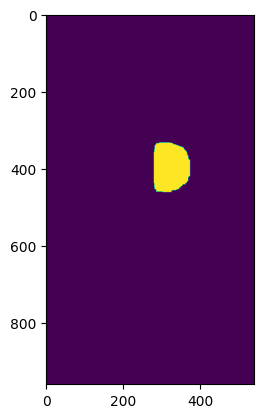

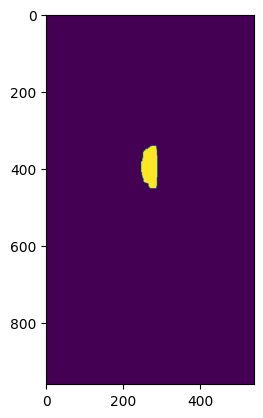

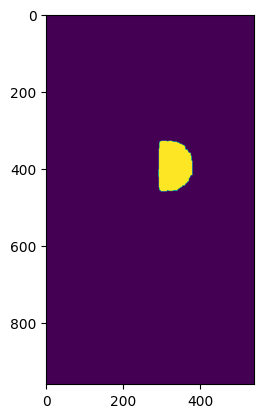

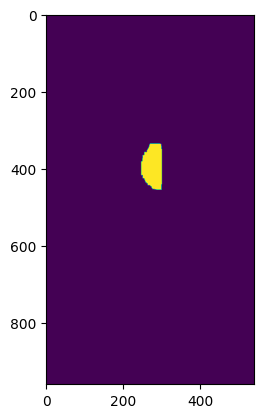

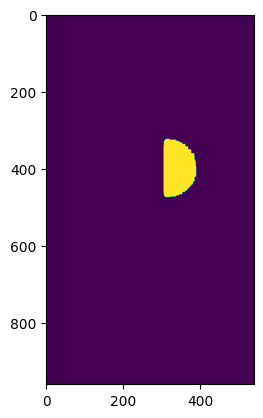

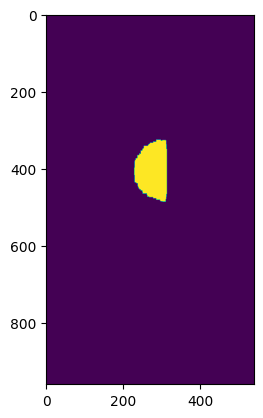

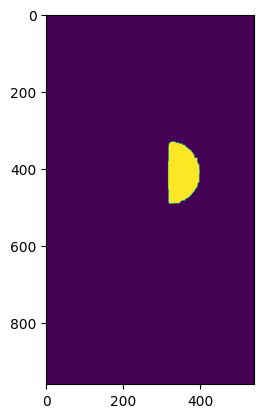

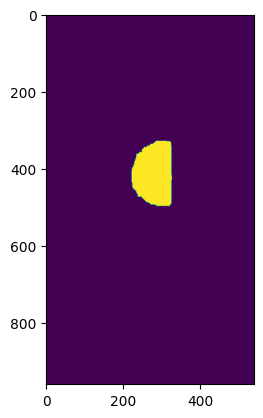

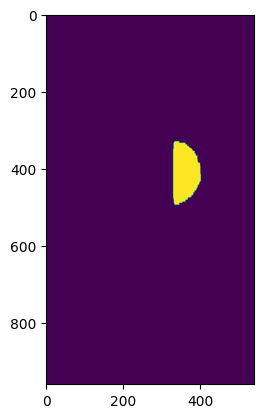

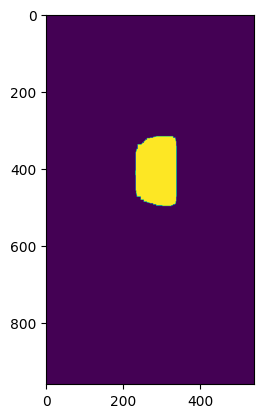

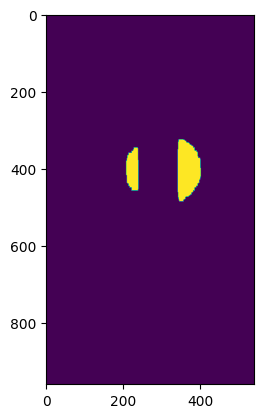

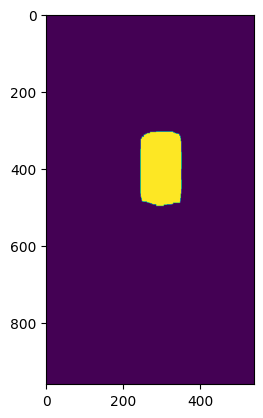

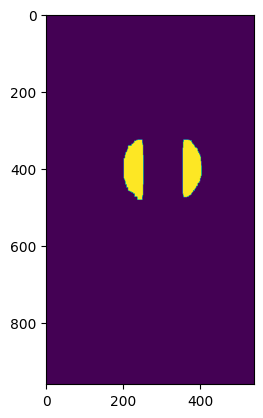

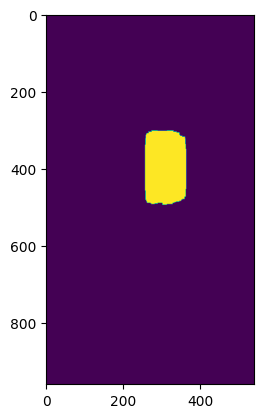

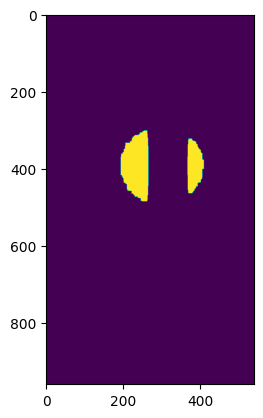

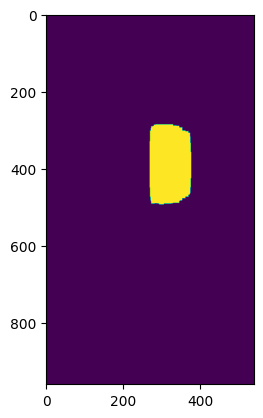

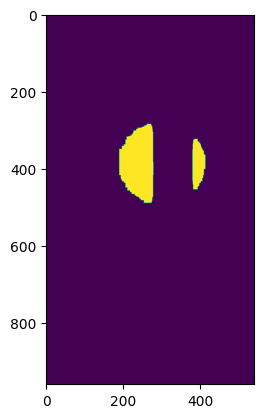

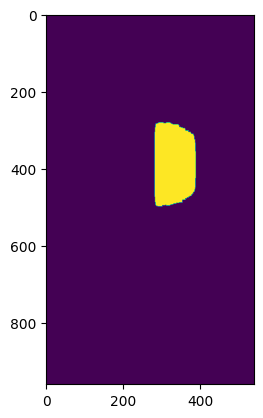

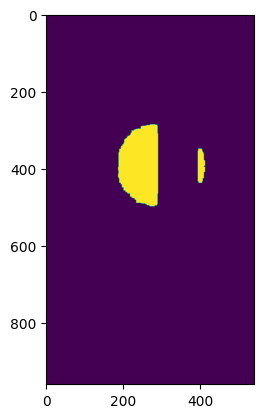

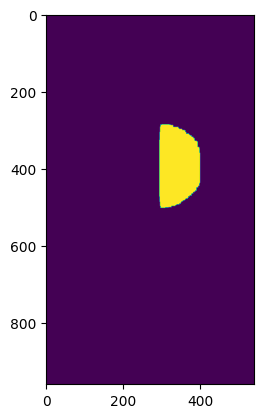

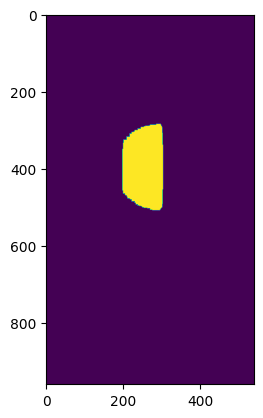

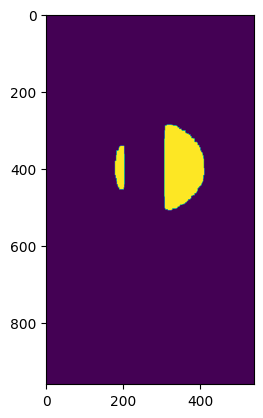

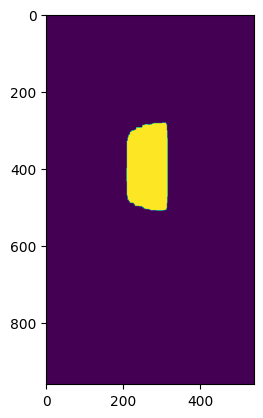

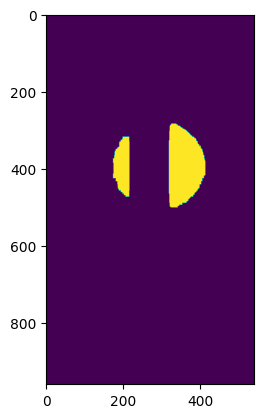

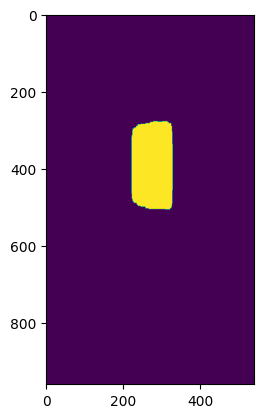

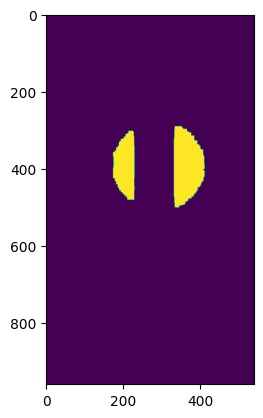

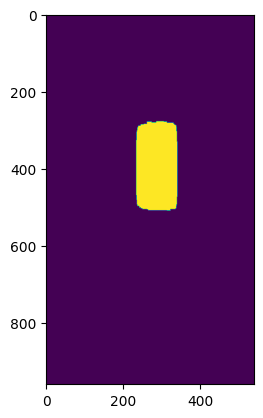

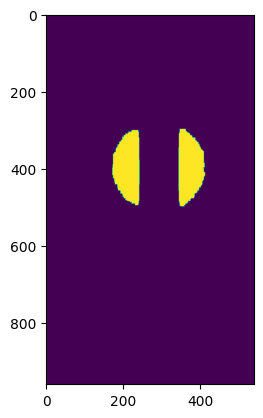

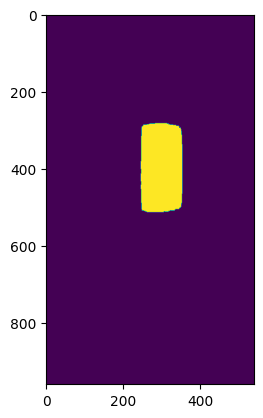

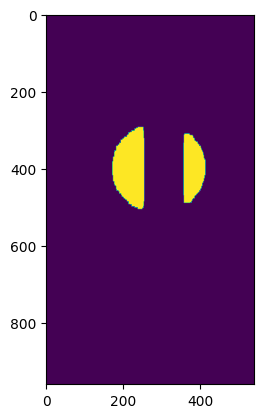

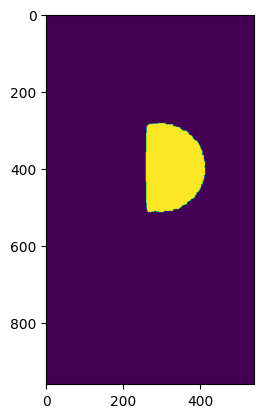

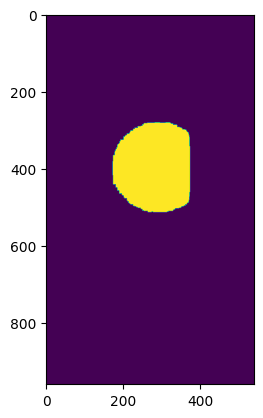

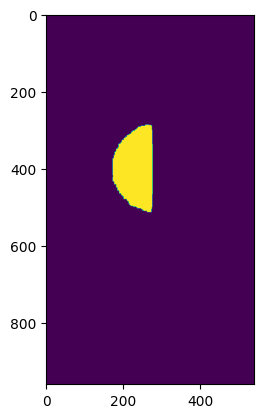

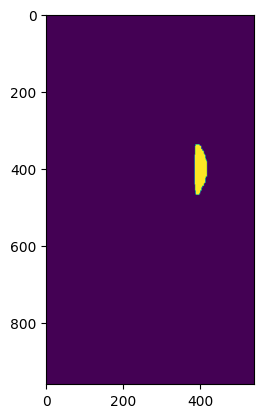

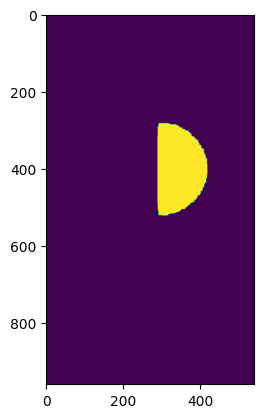

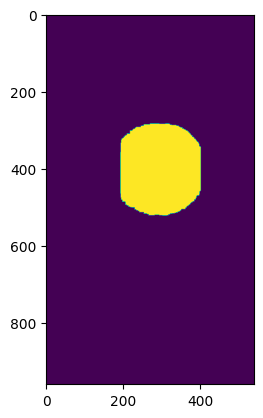

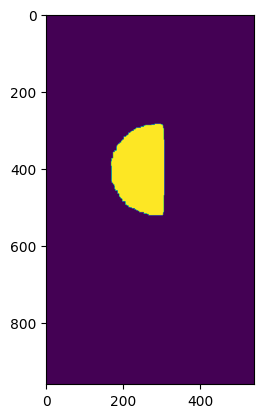

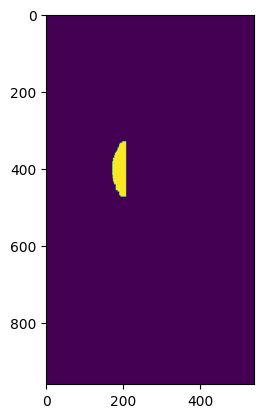

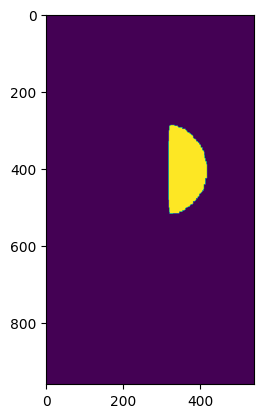

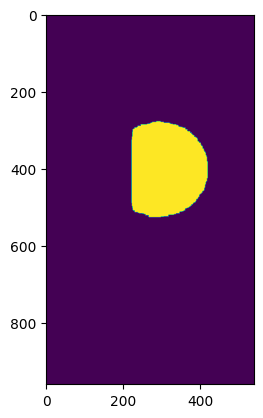

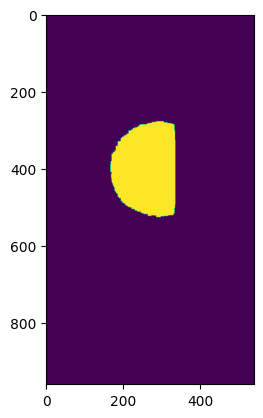

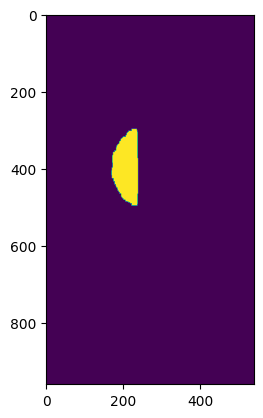

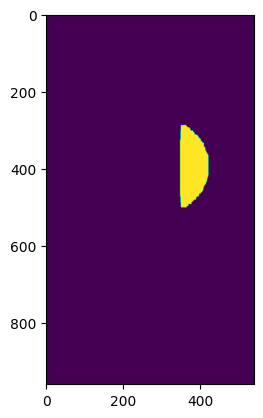

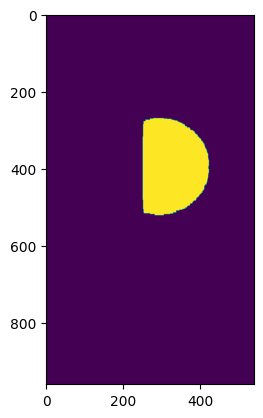

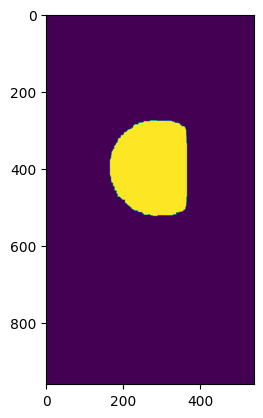

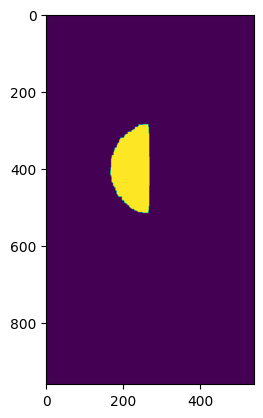

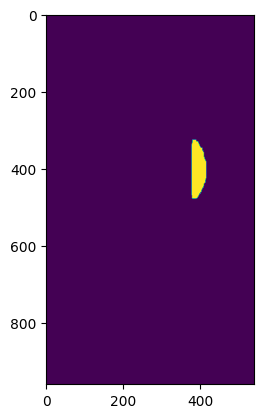

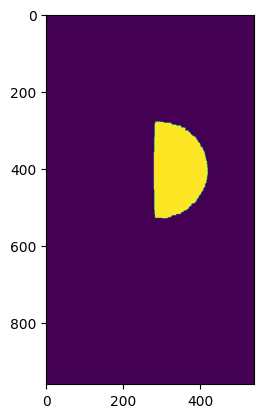

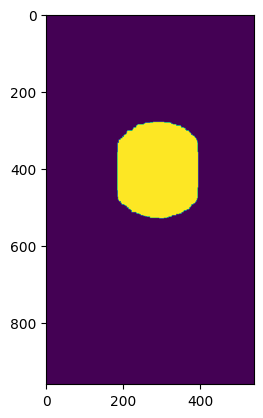

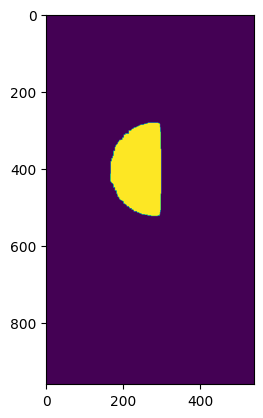

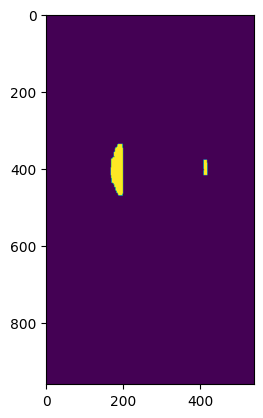

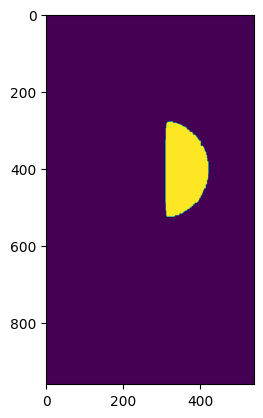

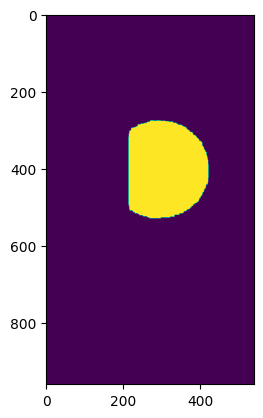

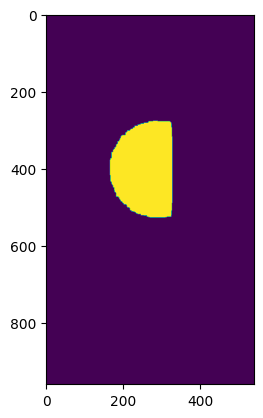

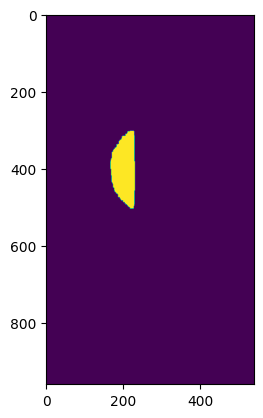

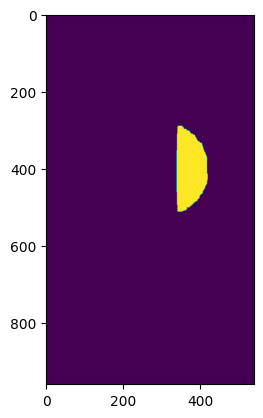

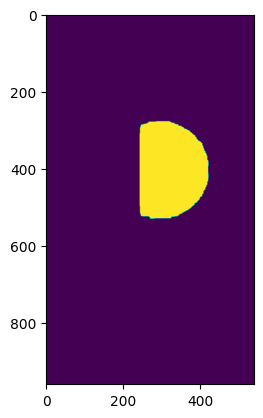

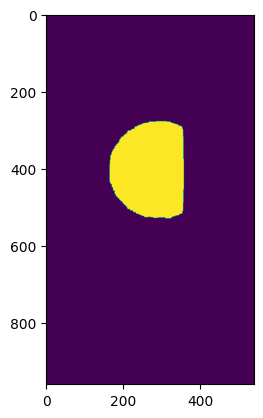

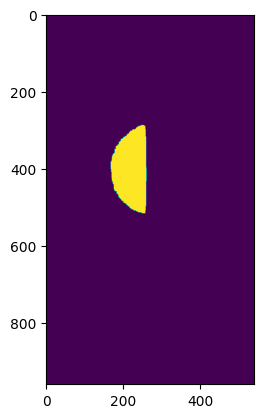

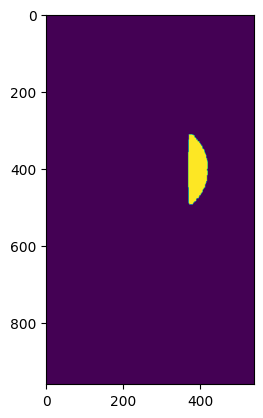

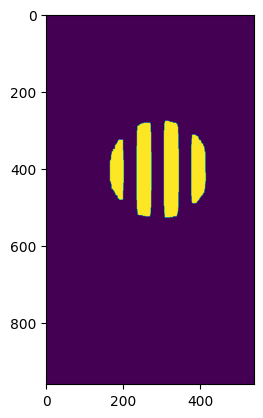

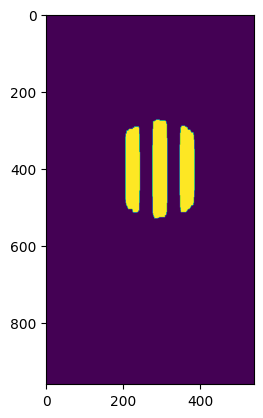

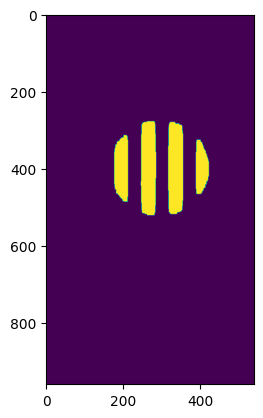

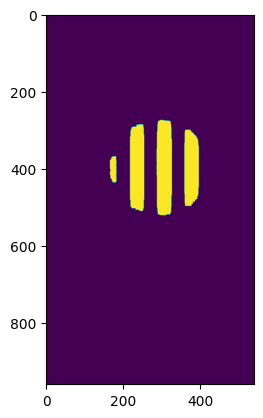

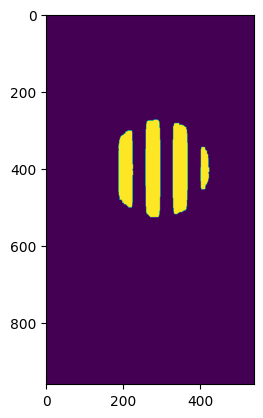

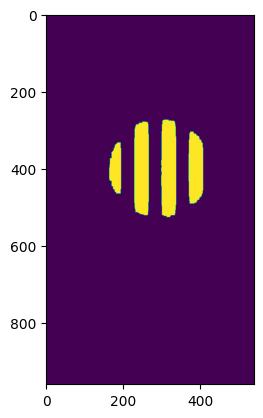

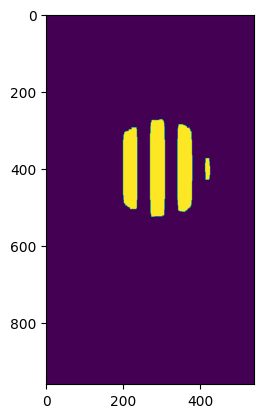

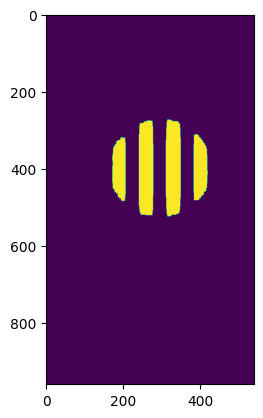

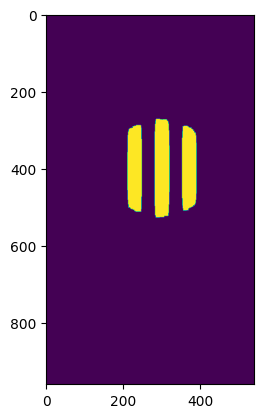

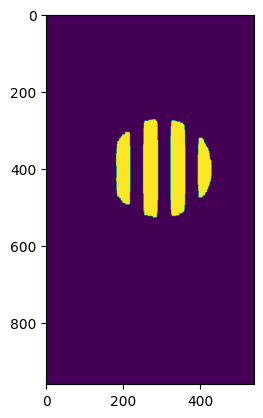

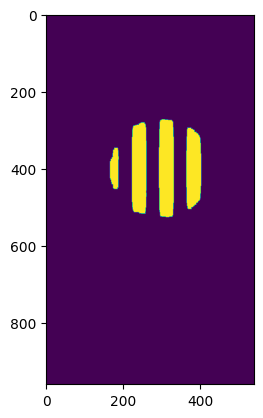

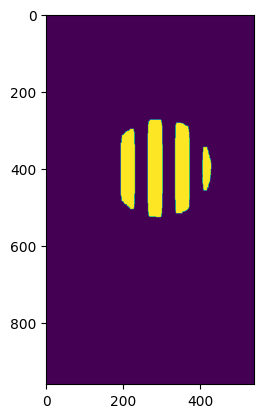

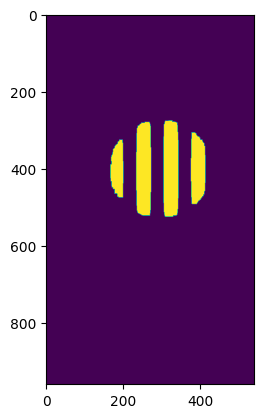

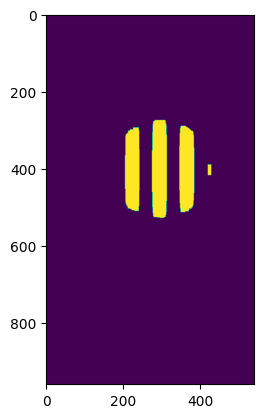

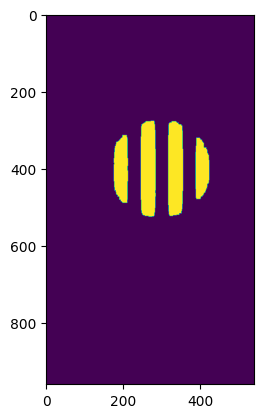

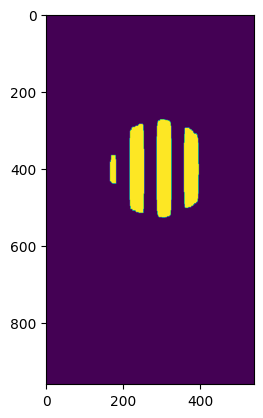

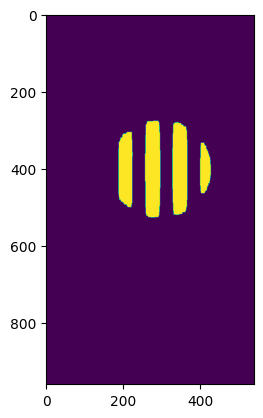

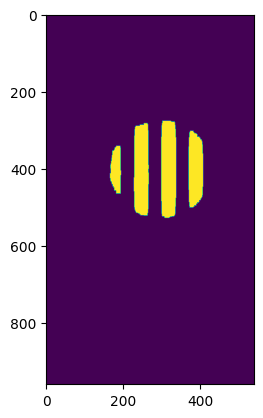

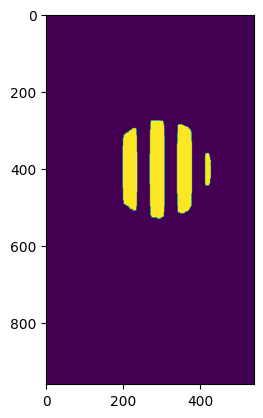

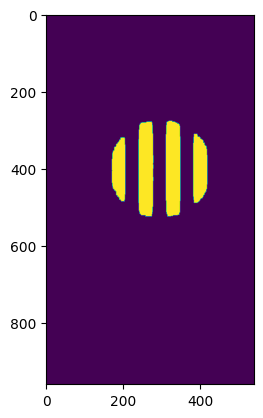

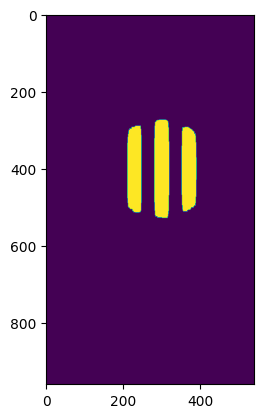

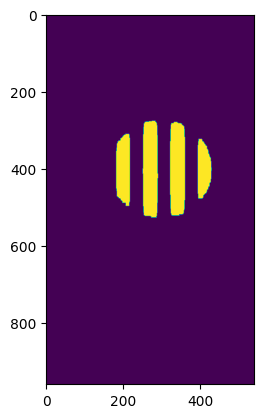

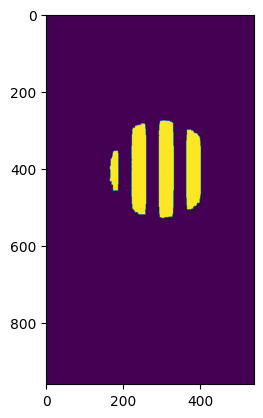

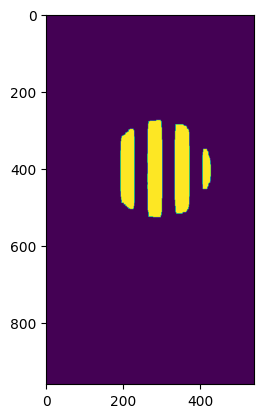

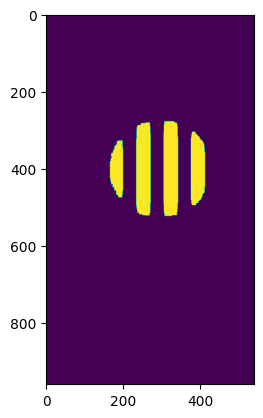

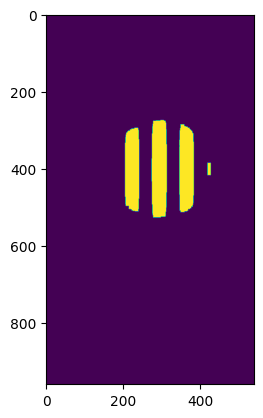

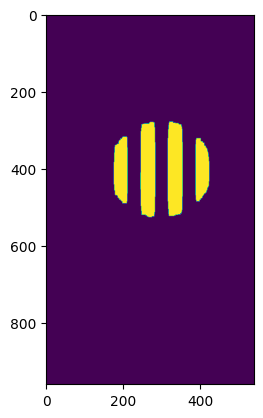

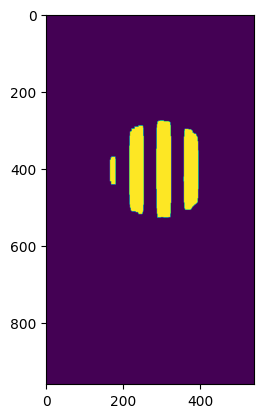

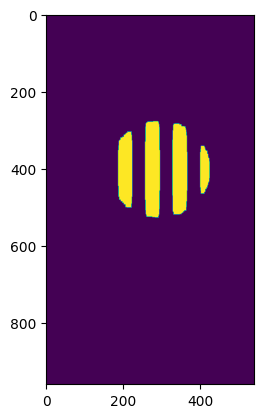

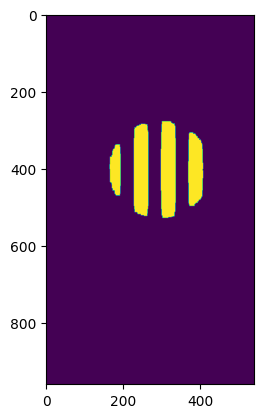

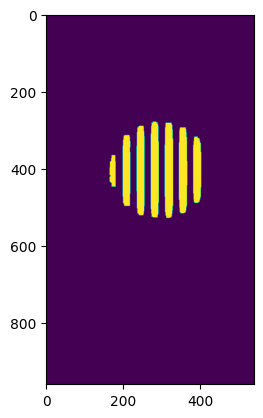

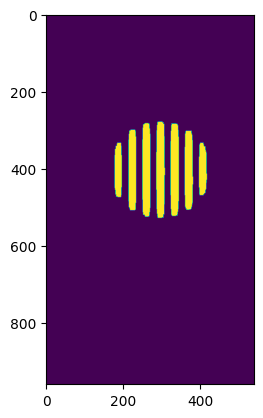

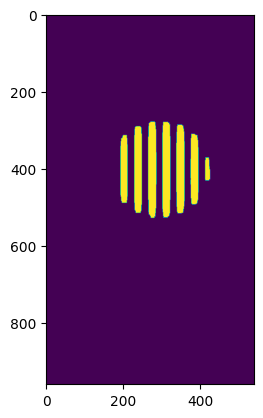

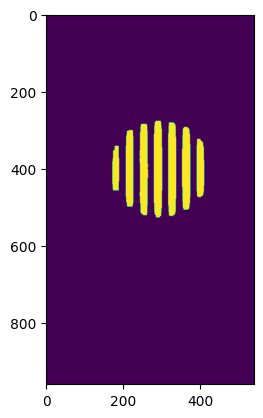

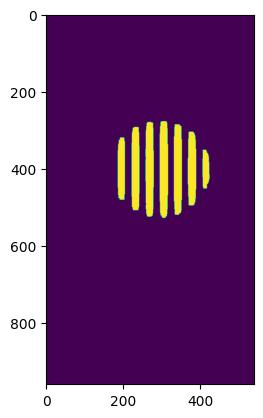

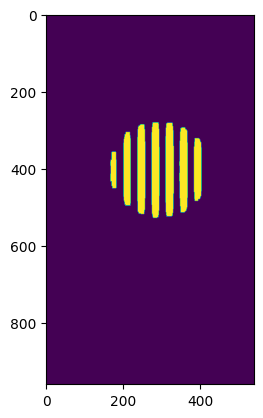

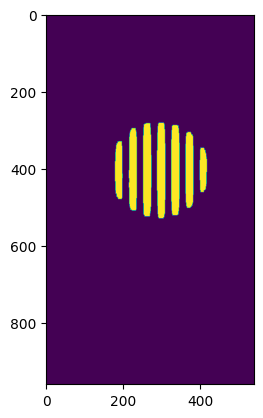

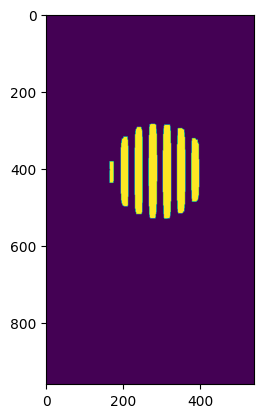

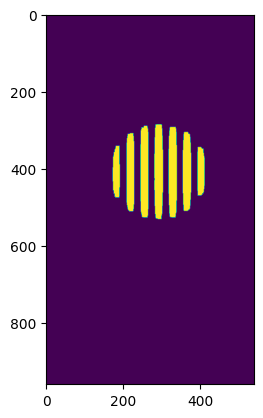

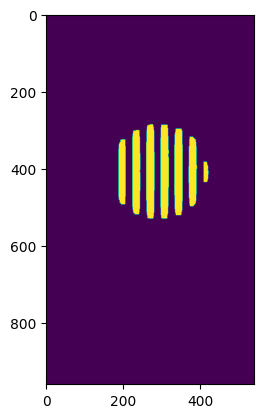

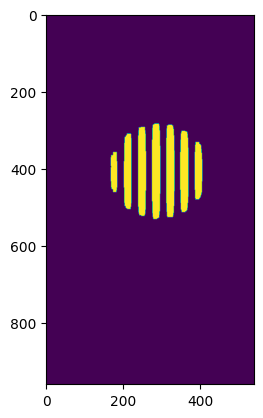

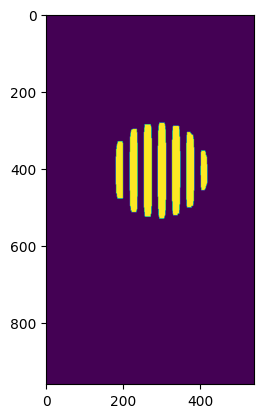

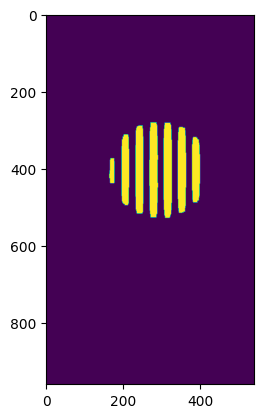

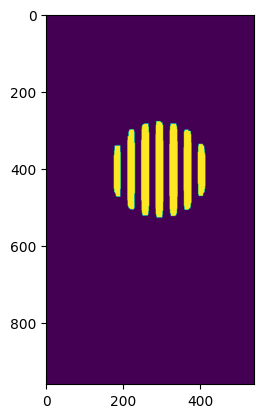

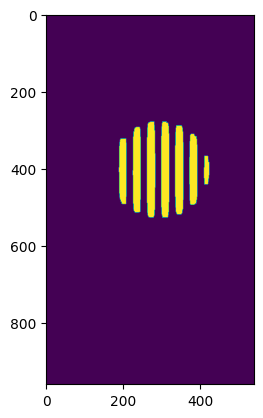

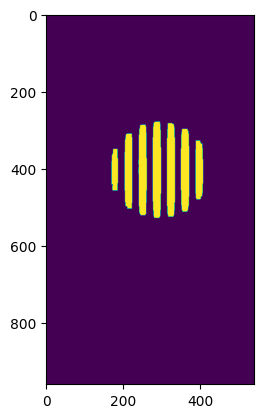

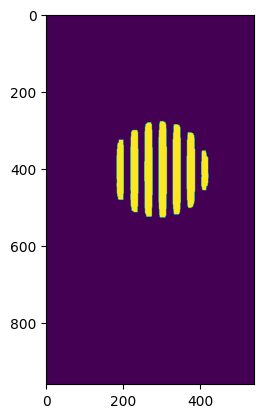

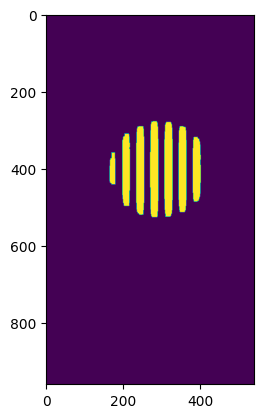

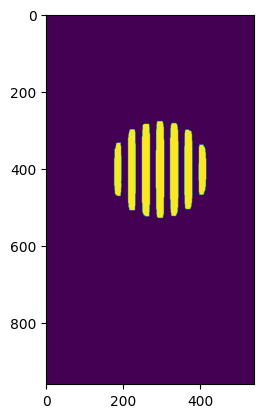

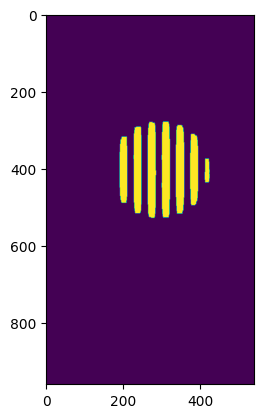

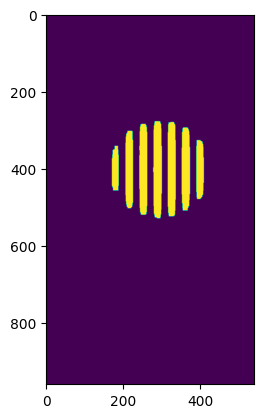

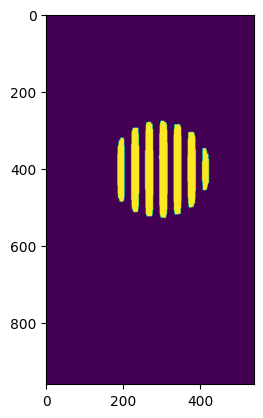

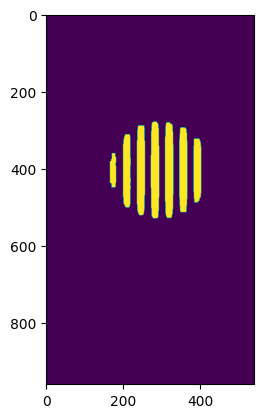

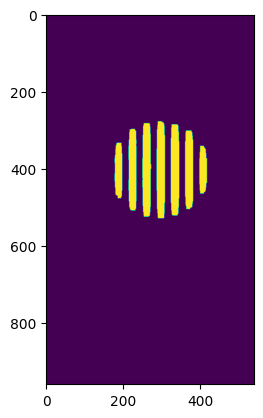

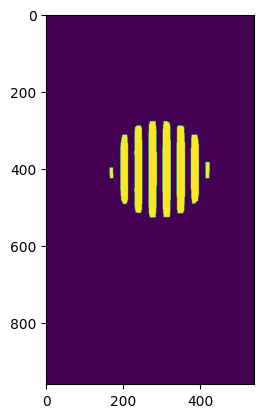

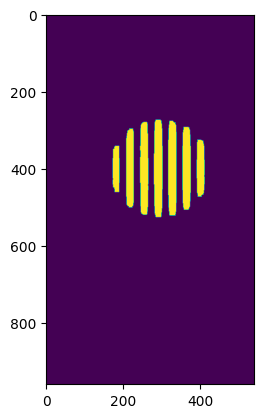

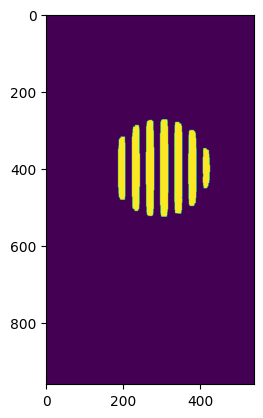

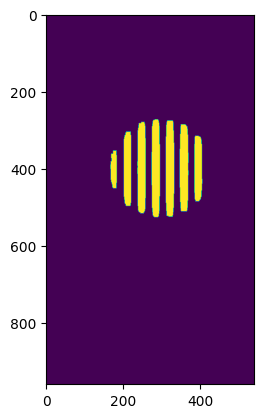

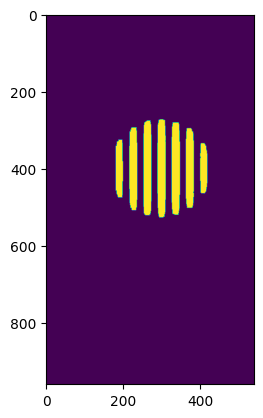

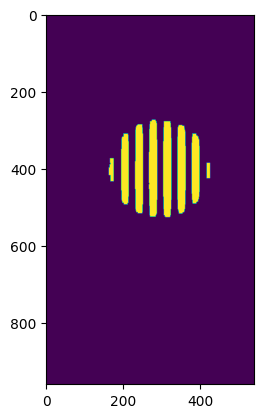

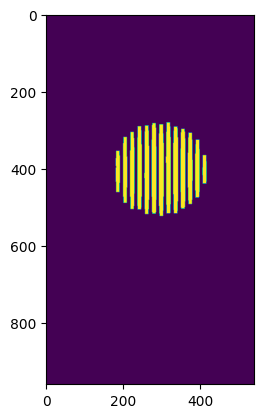

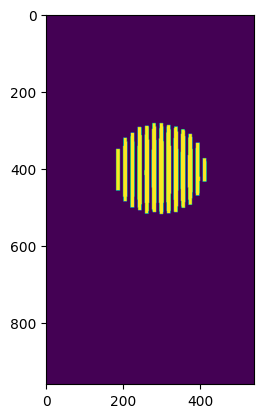

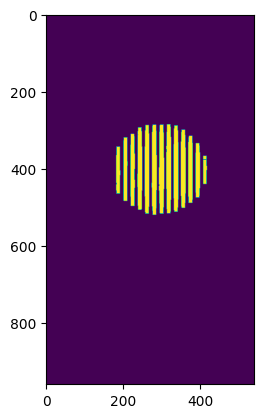

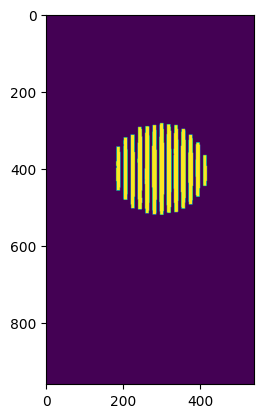

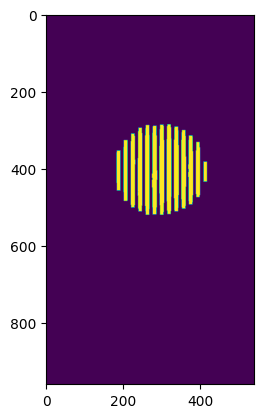

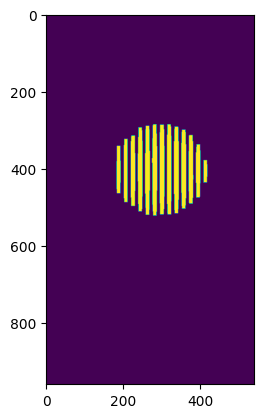

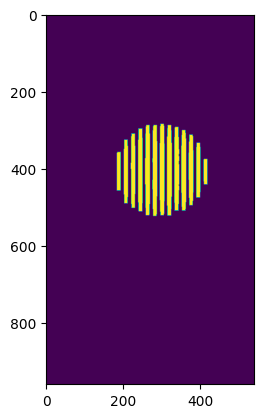

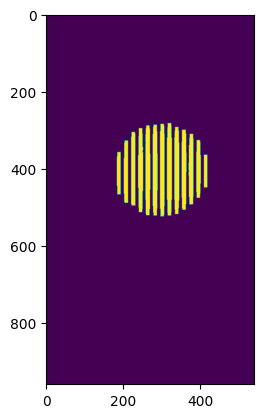

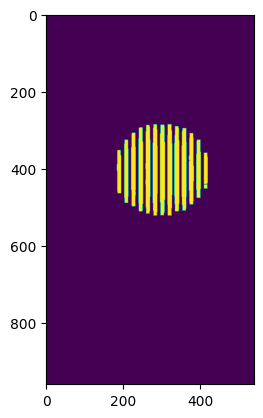

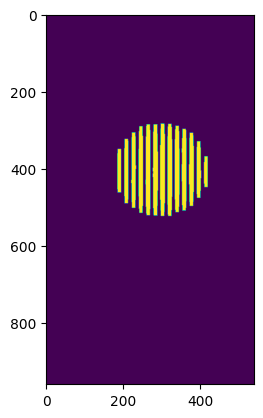

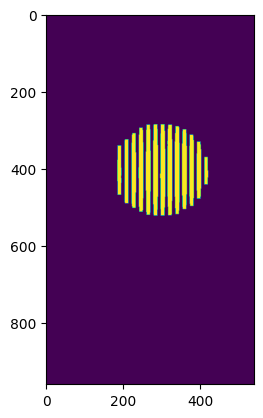

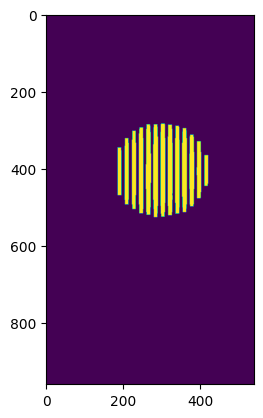

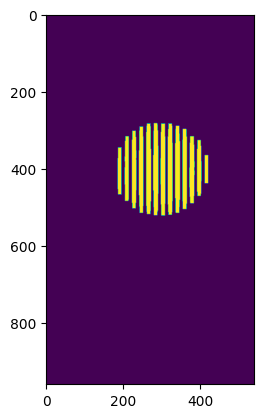

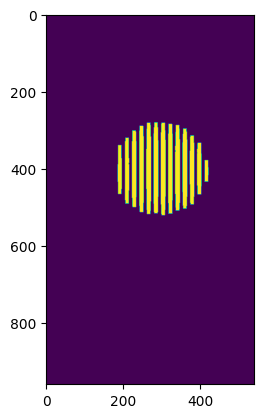

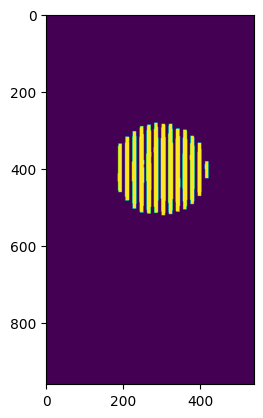

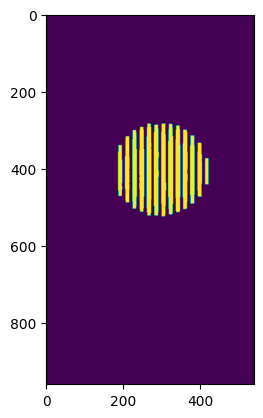

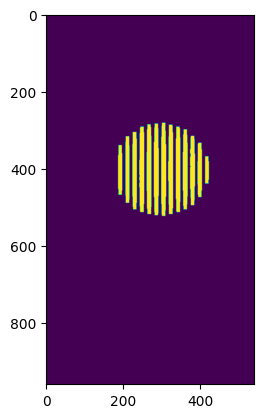

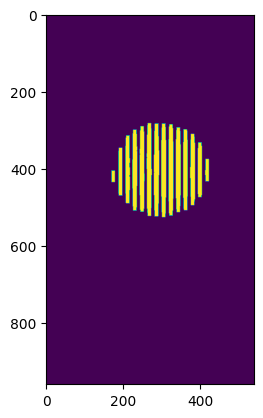

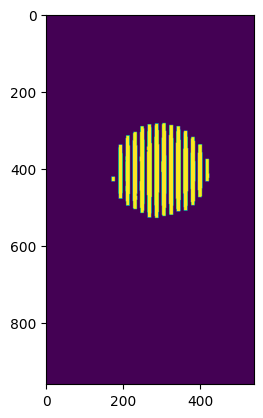

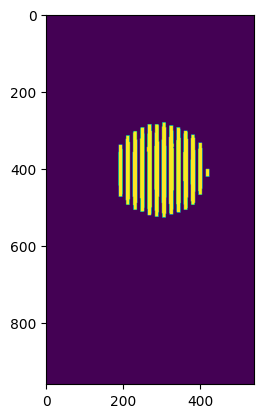

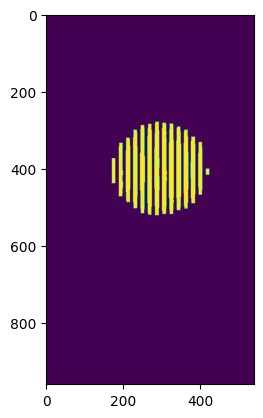

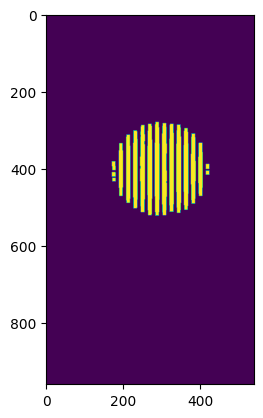

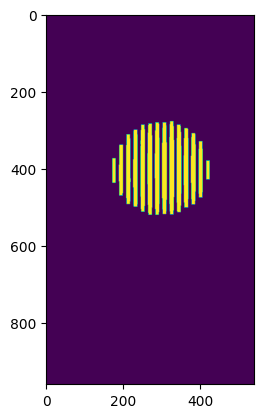

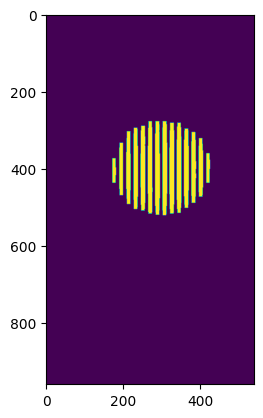

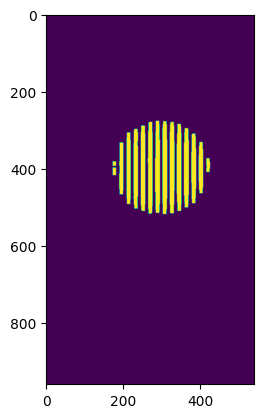

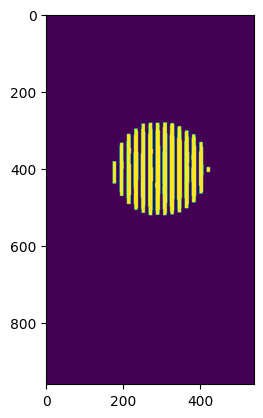

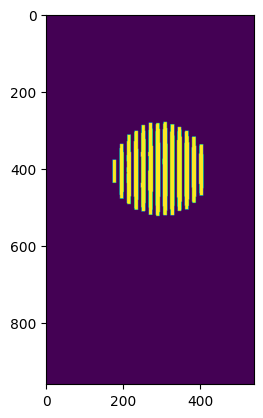

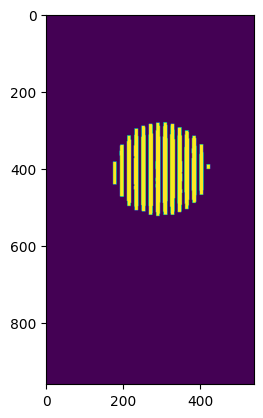

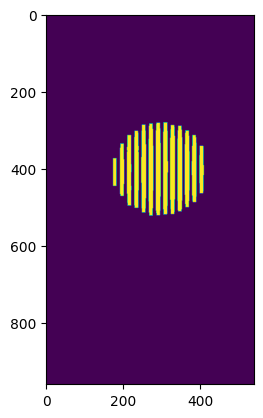

150


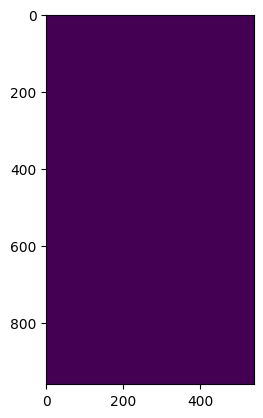

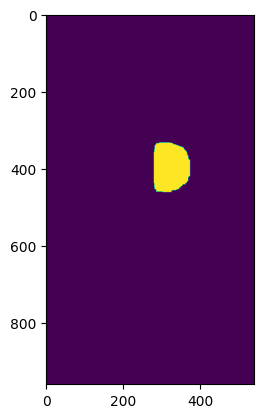

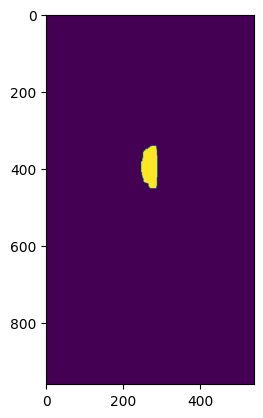

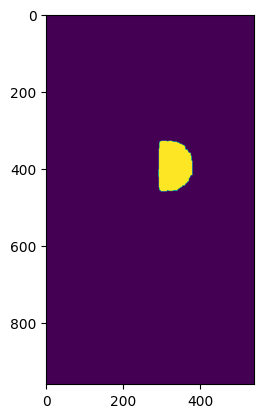

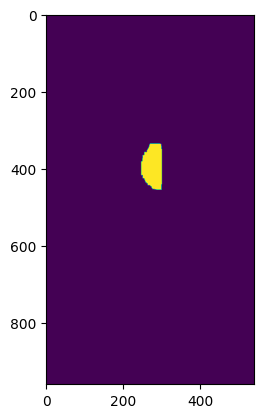

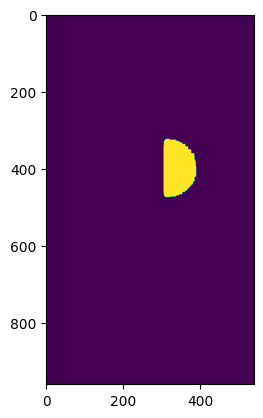

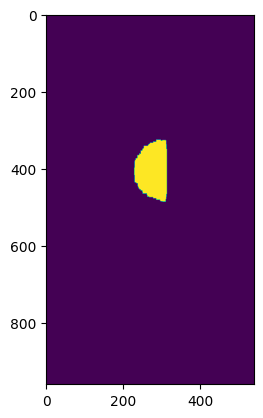

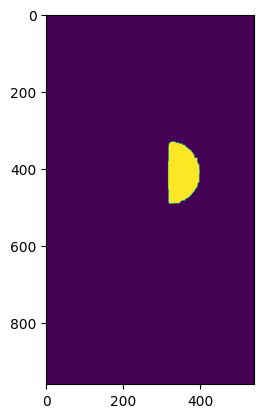

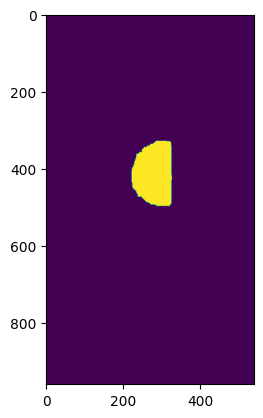

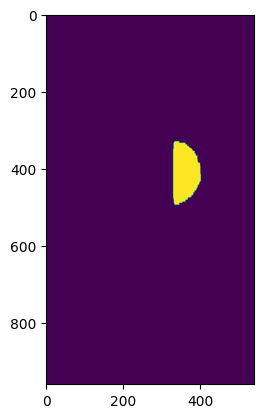

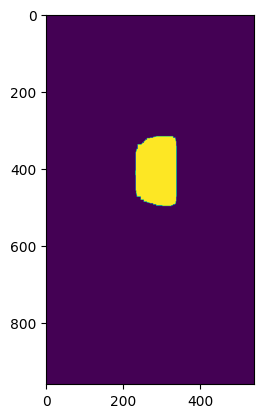

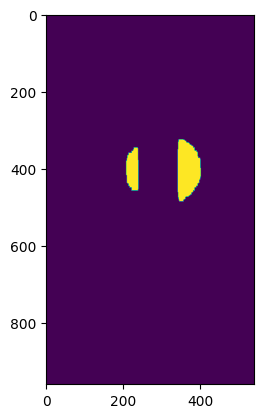

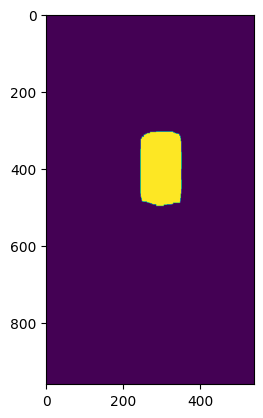

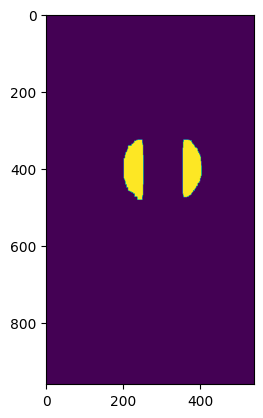

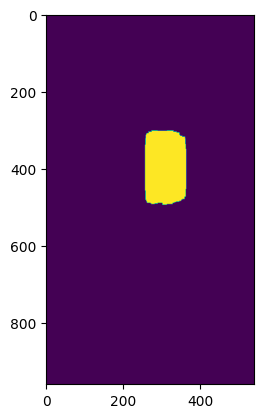

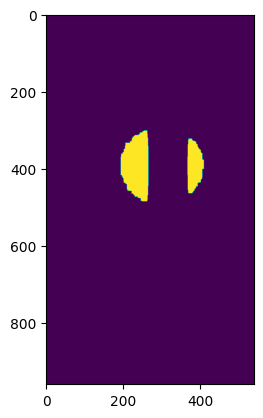

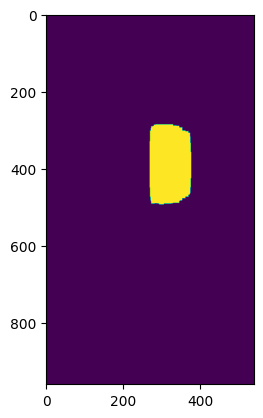

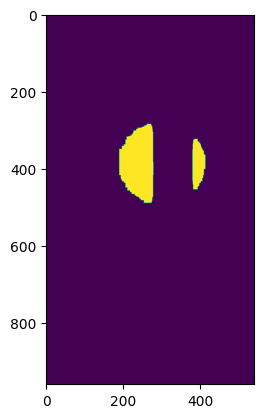

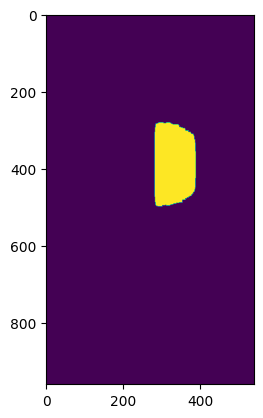

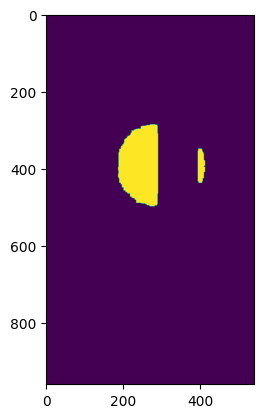

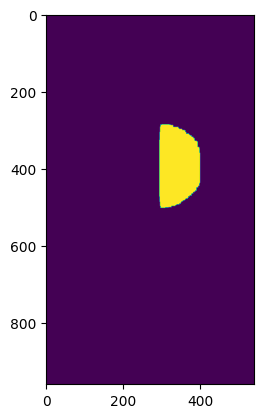

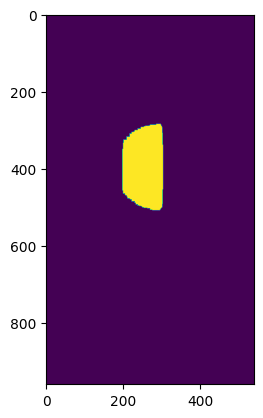

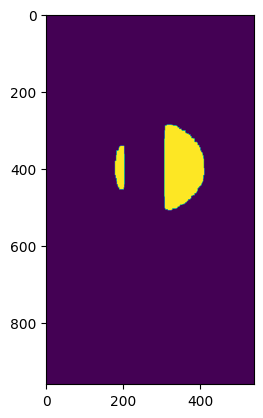

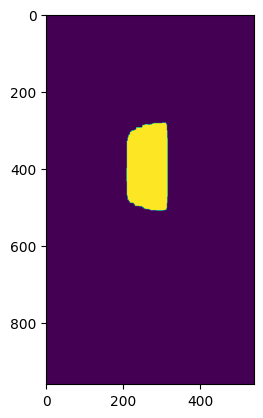

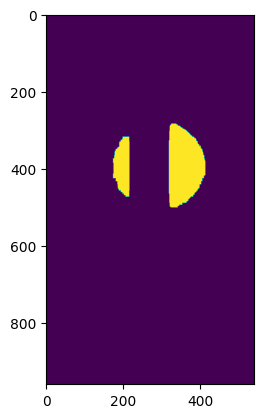

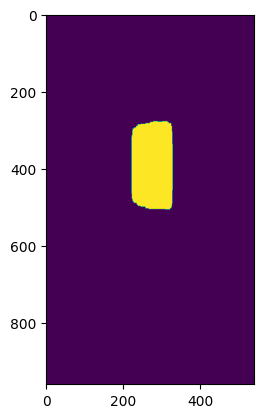

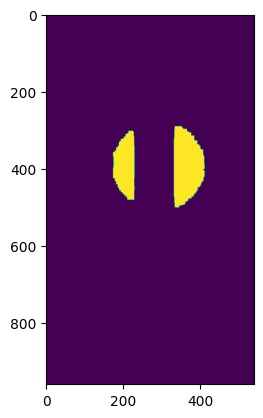

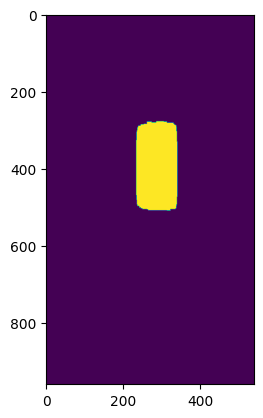

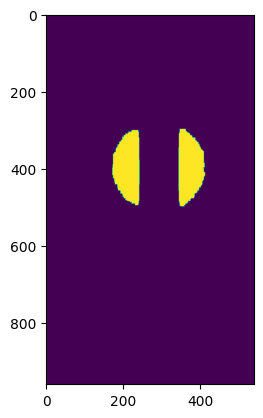

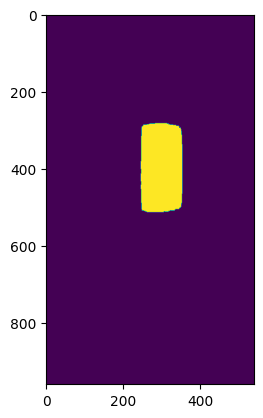

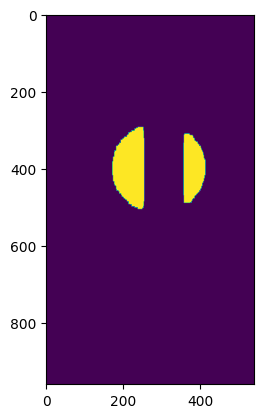

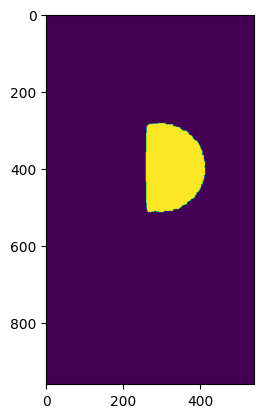

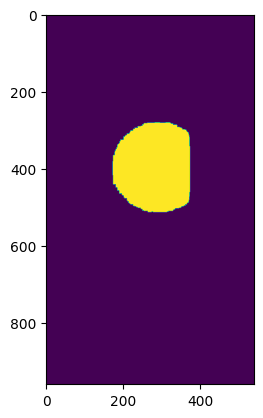

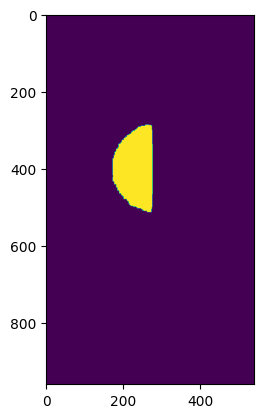

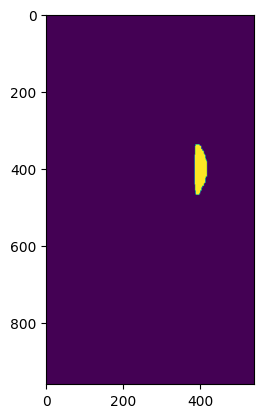

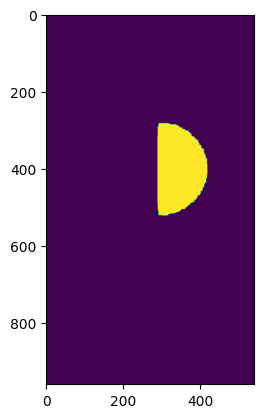

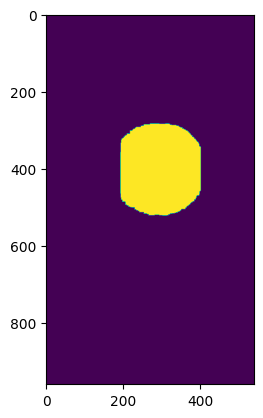

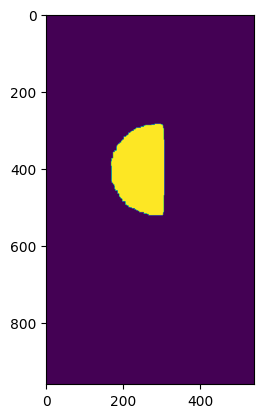

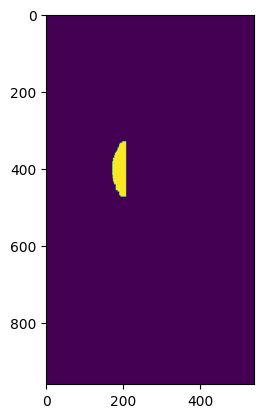

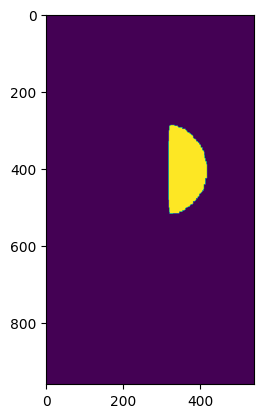

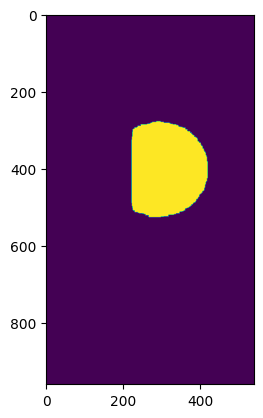

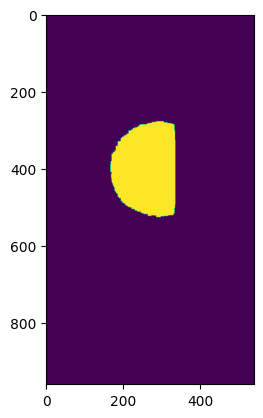

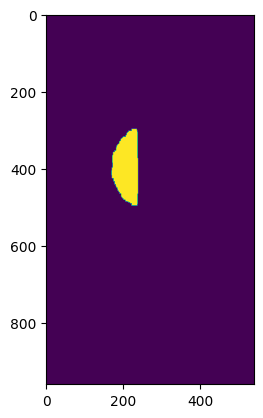

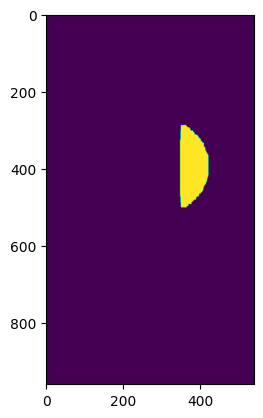

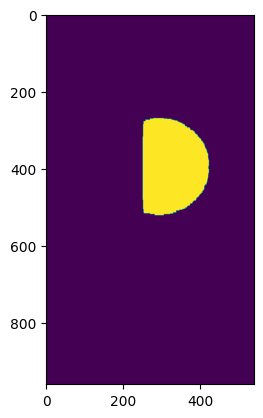

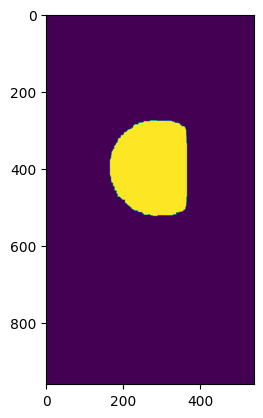

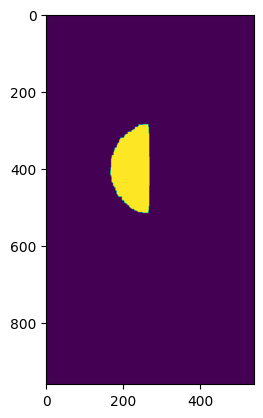

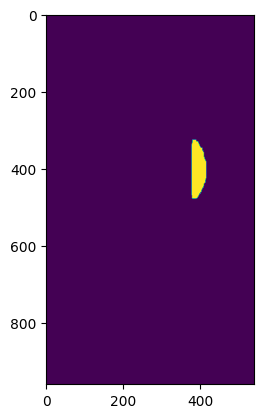

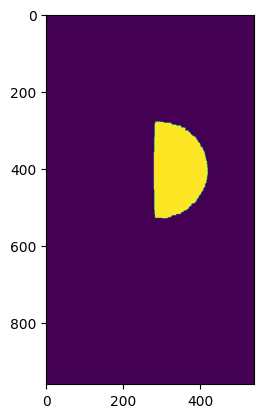

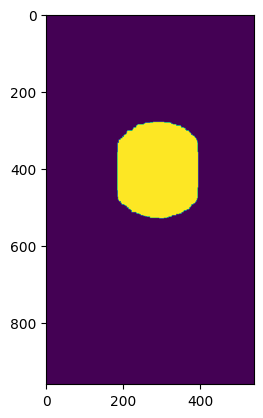

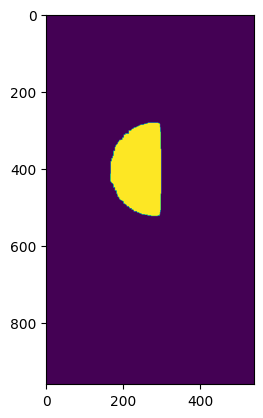

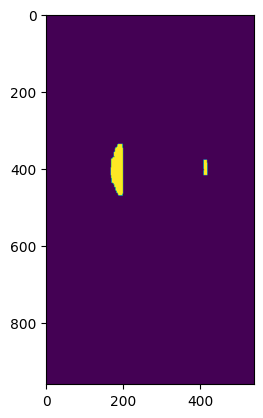

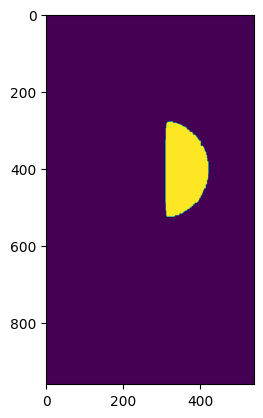

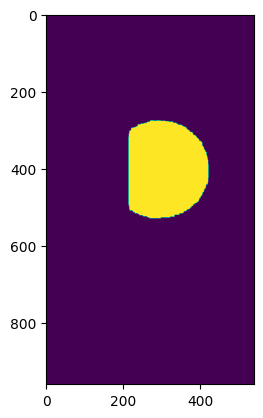

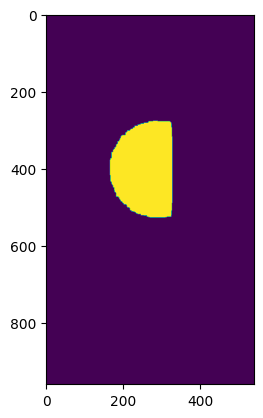

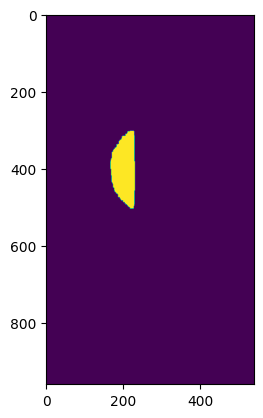

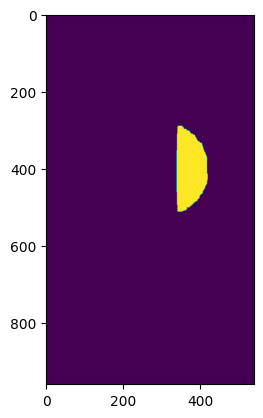

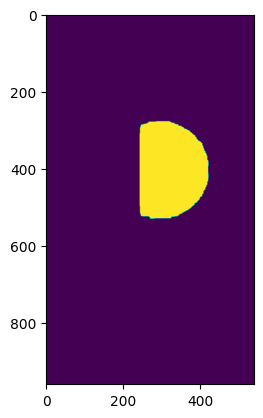

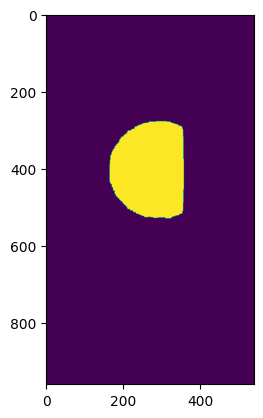

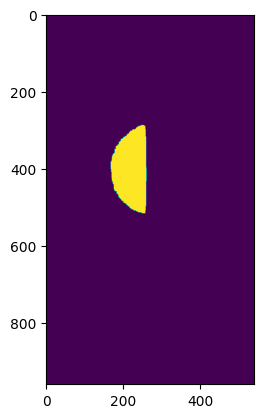

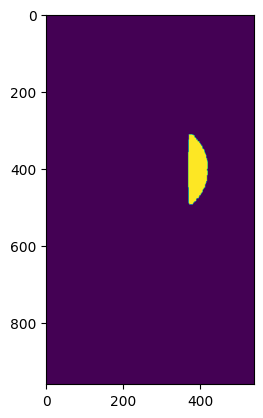

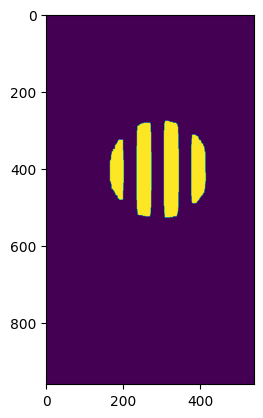

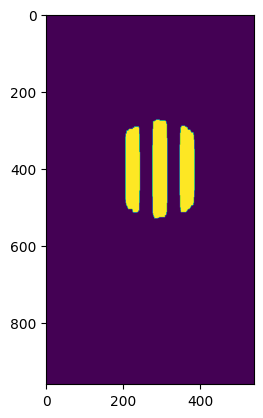

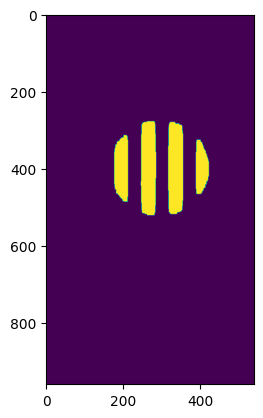

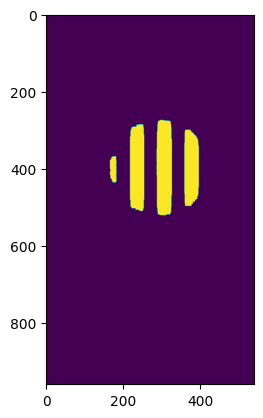

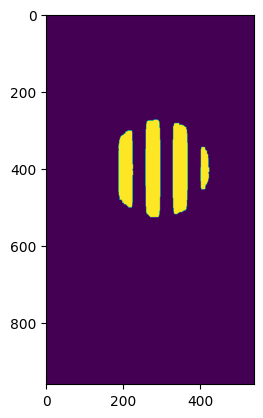

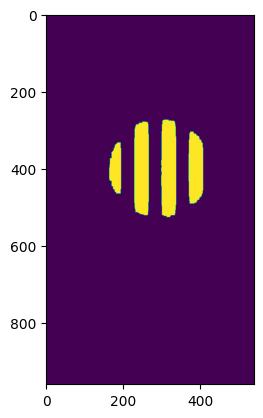

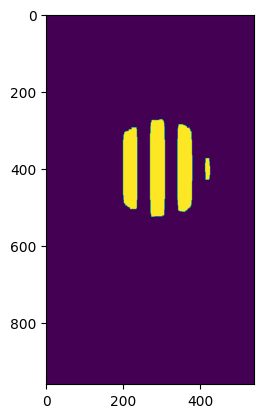

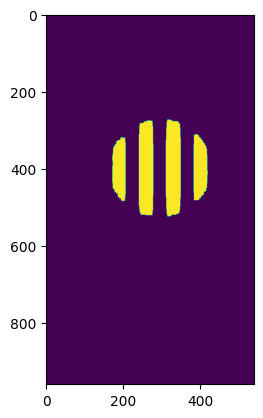

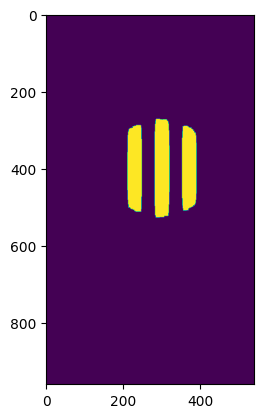

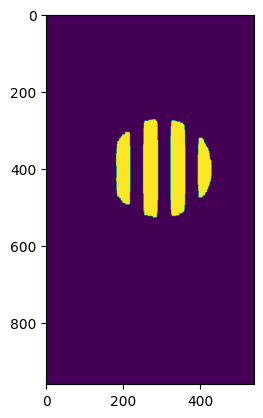

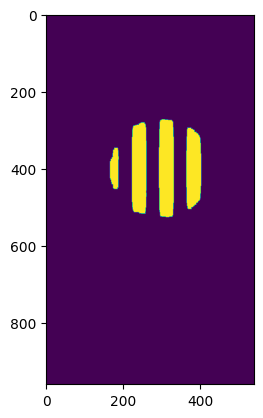

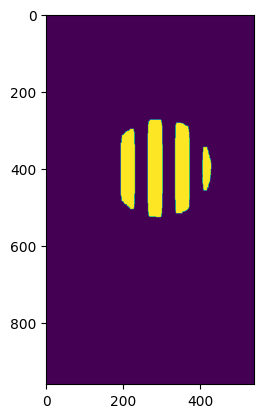

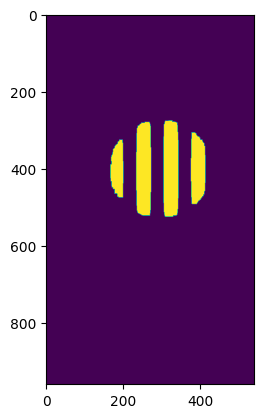

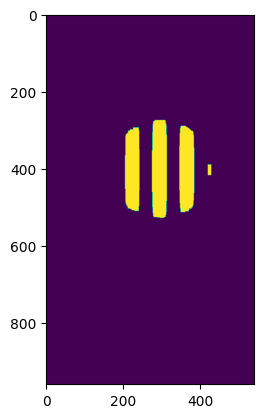

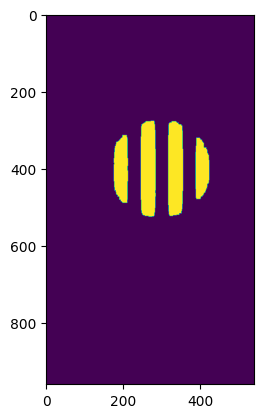

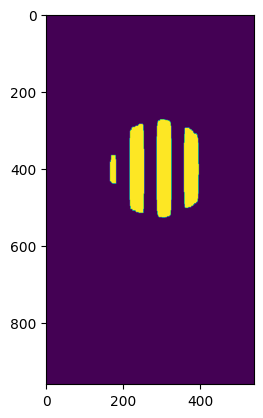

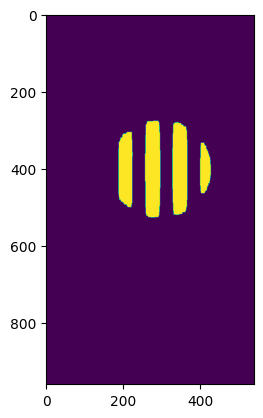

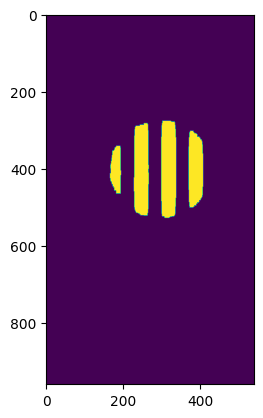

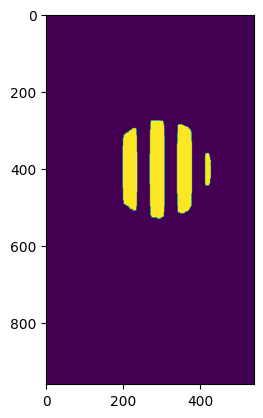

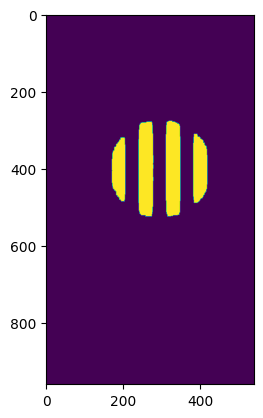

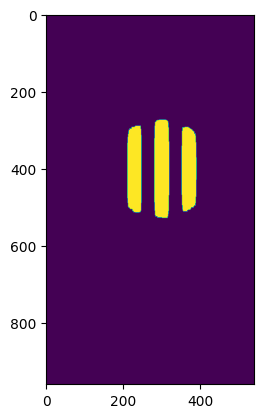

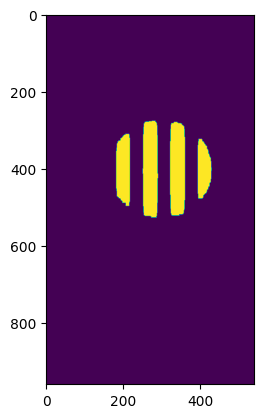

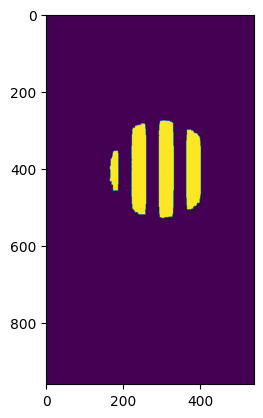

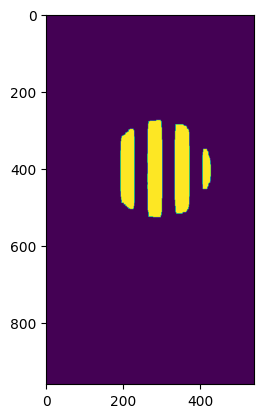

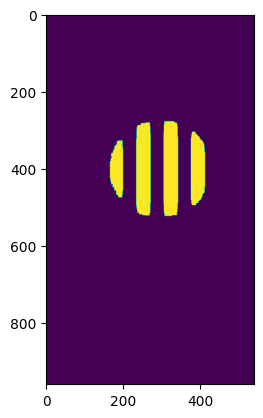

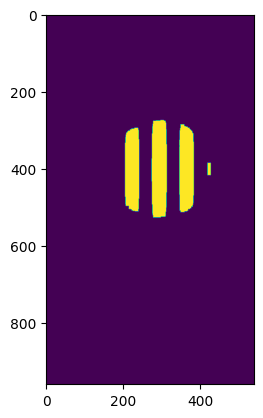

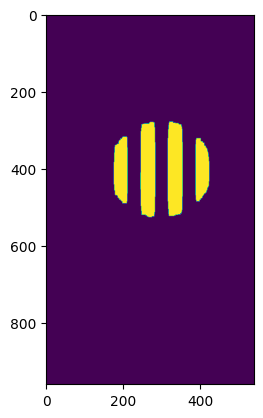

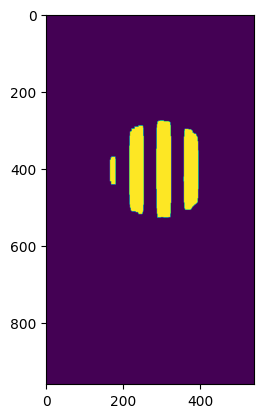

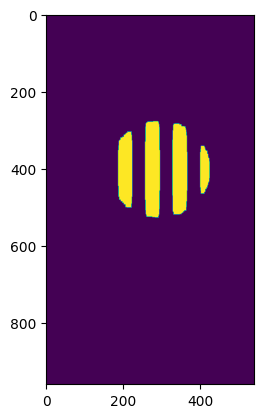

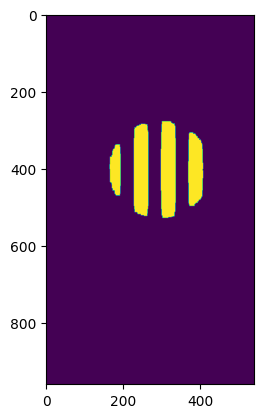

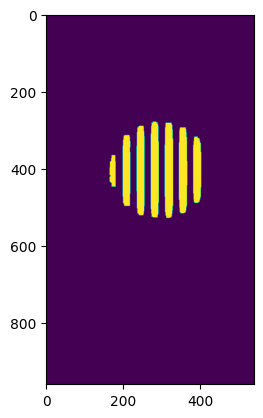

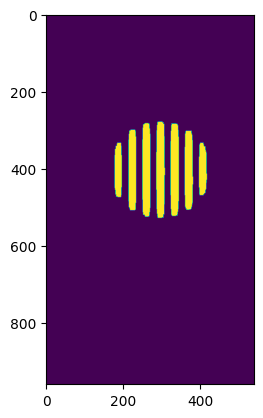

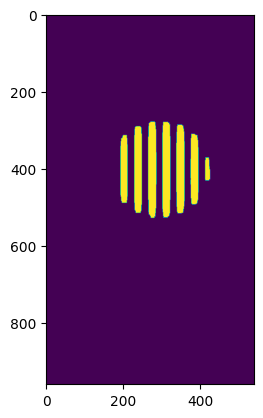

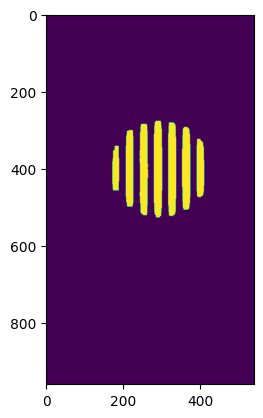

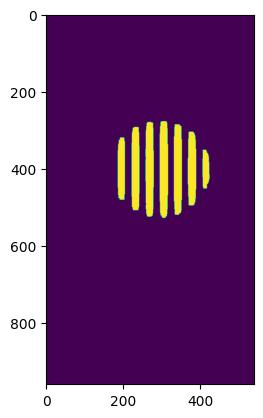

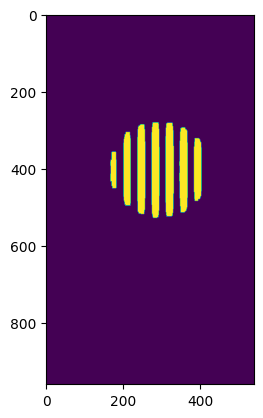

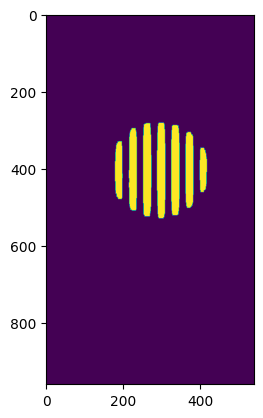

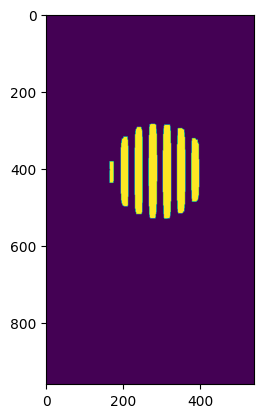

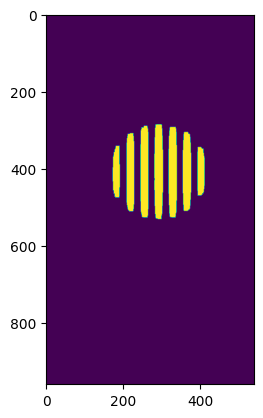

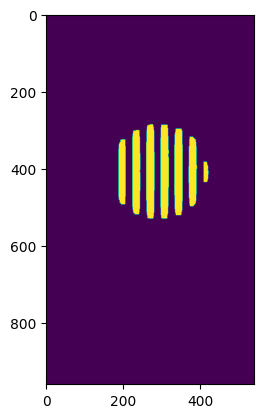

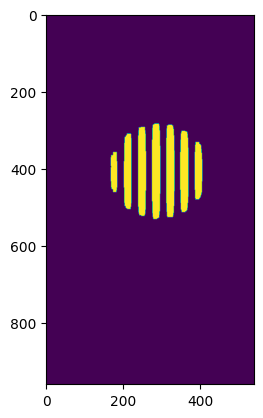

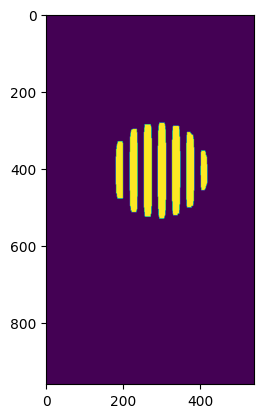

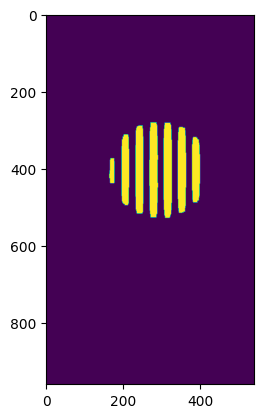

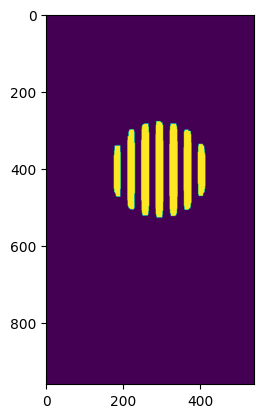

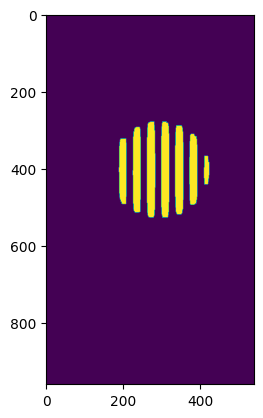

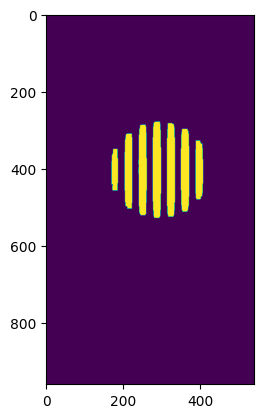

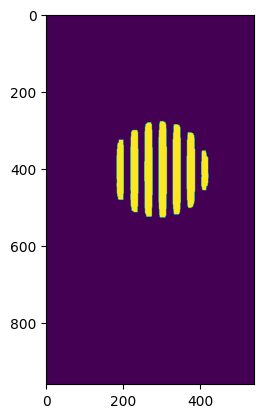

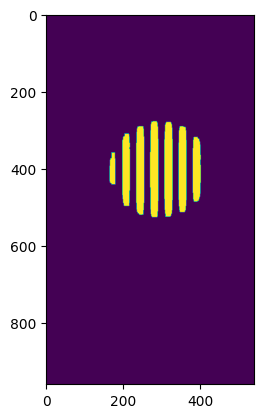

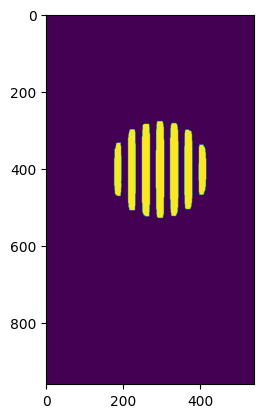

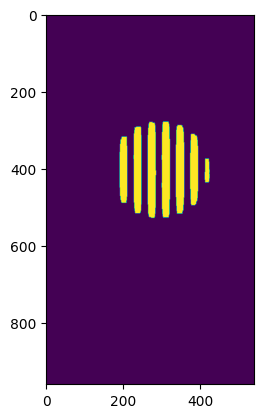

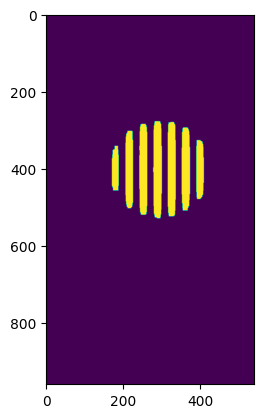

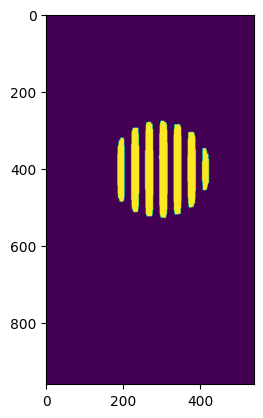

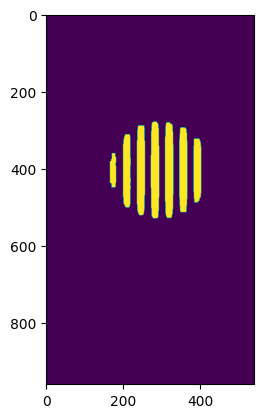

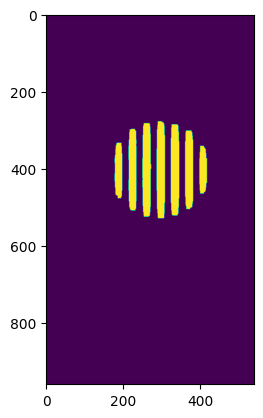

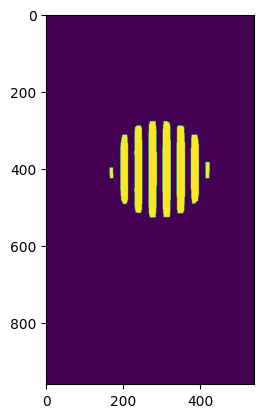

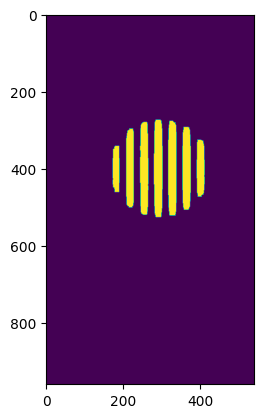

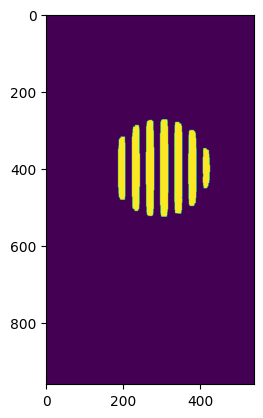

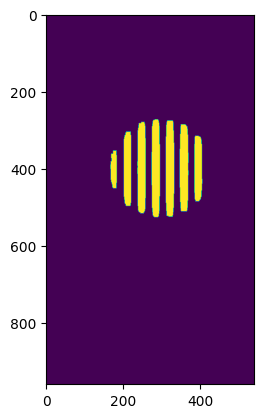

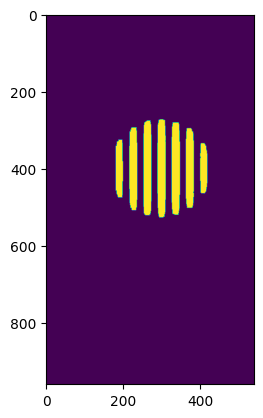

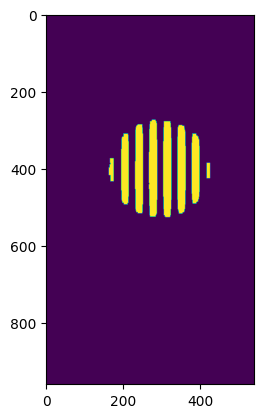

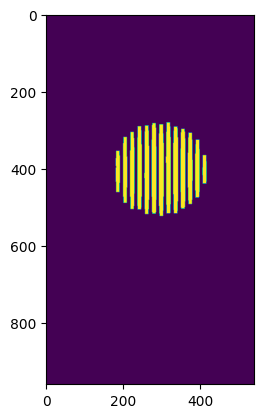

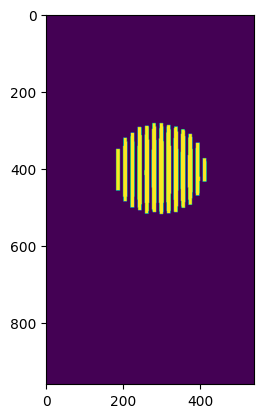

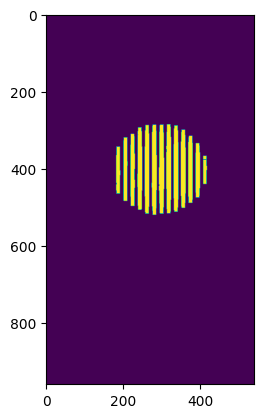

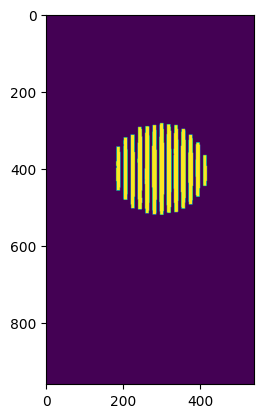

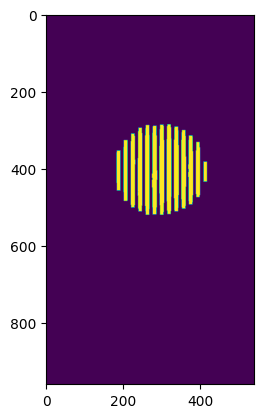

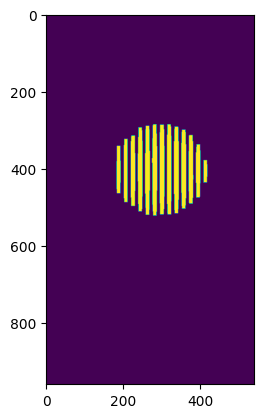

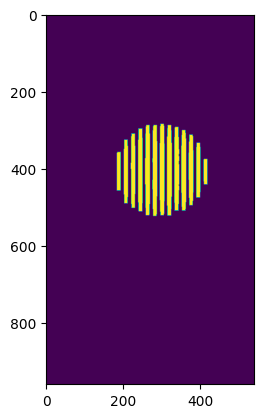

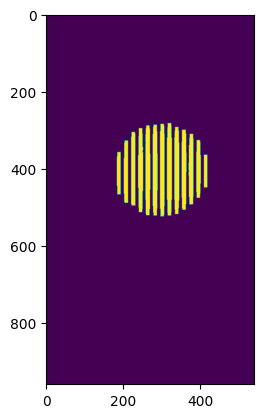

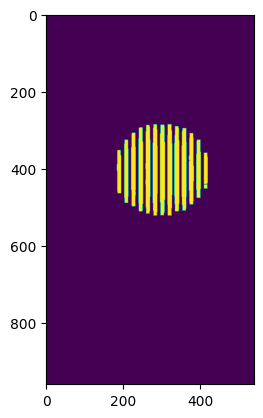

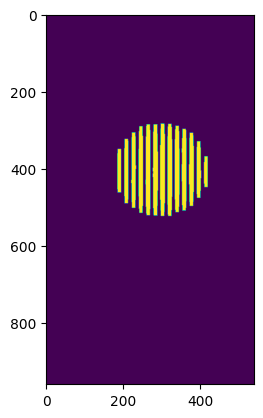

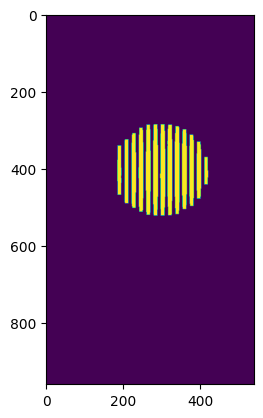

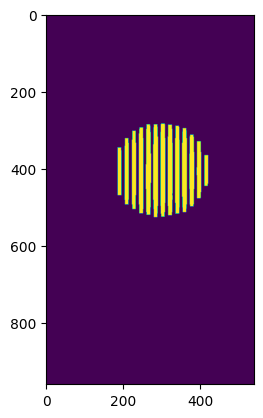

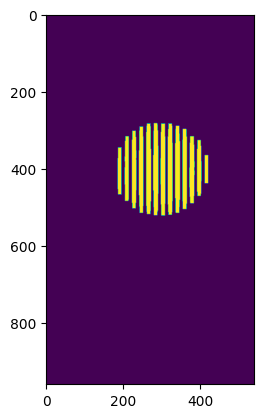

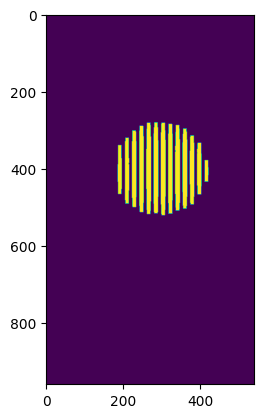

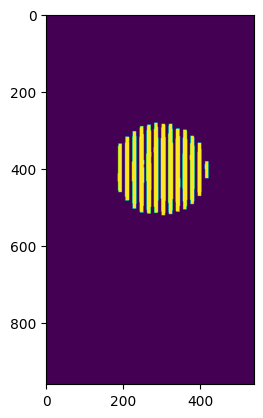

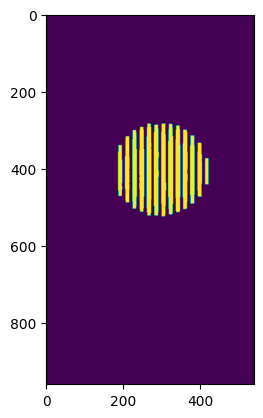

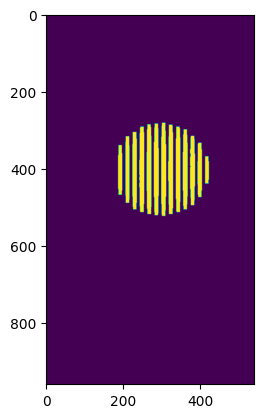

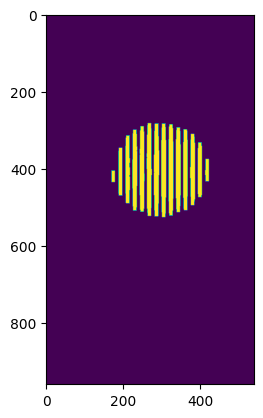

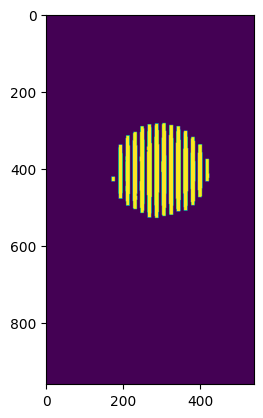

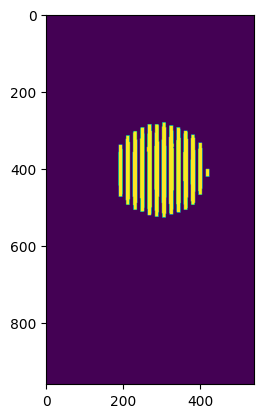

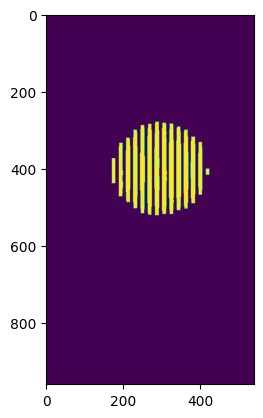

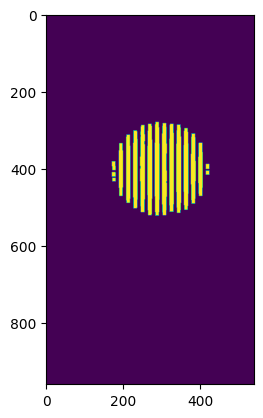

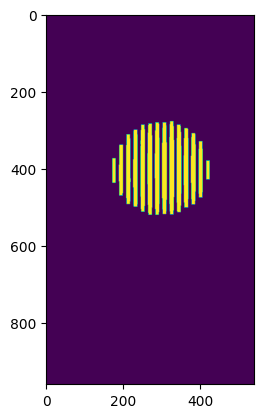

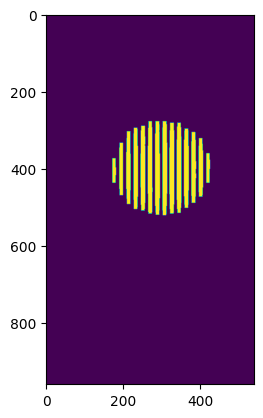

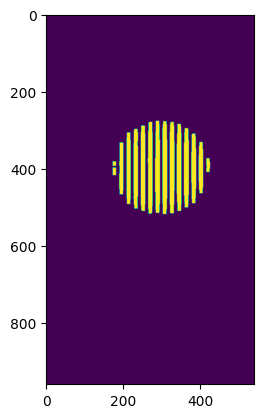

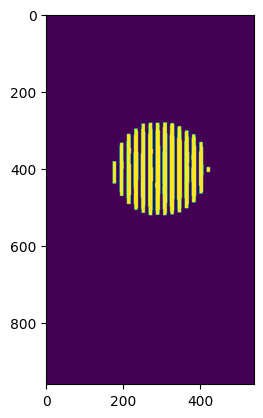

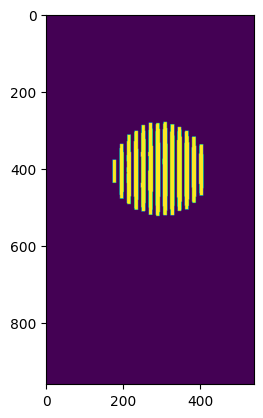

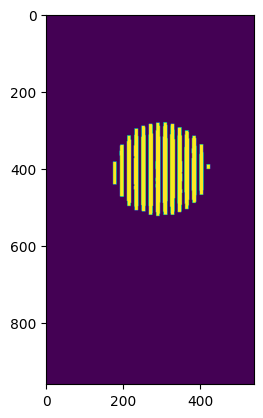

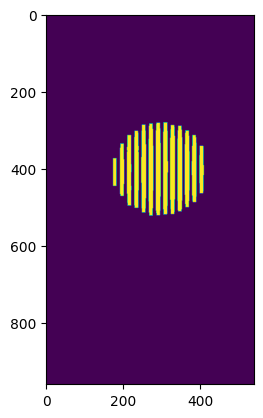

150


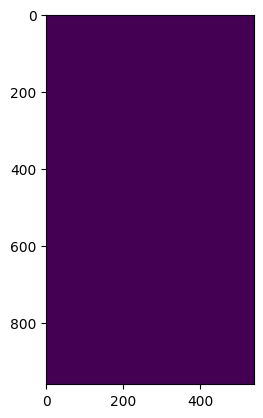

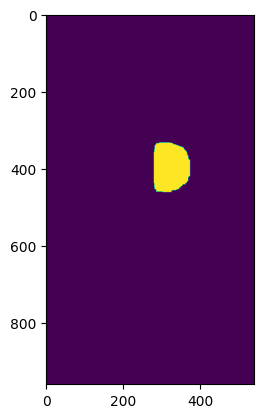

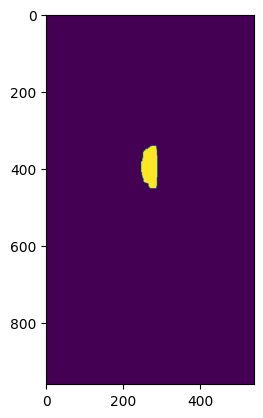

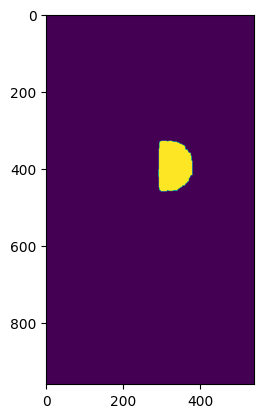

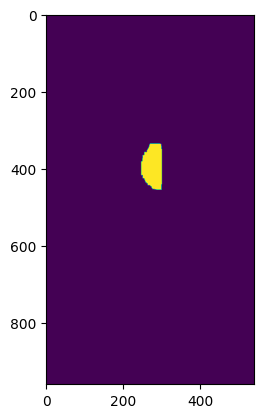

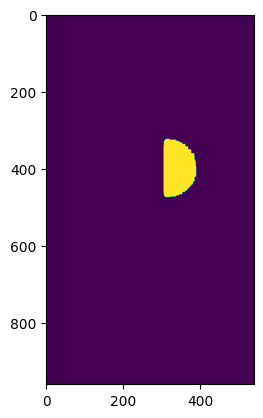

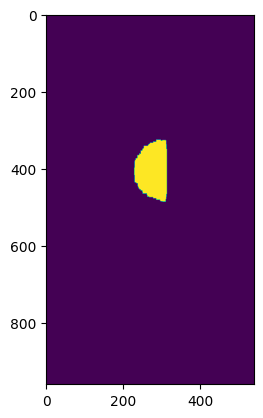

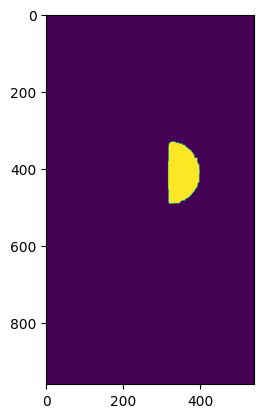

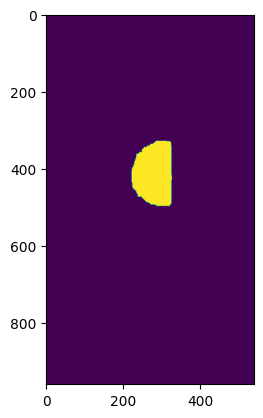

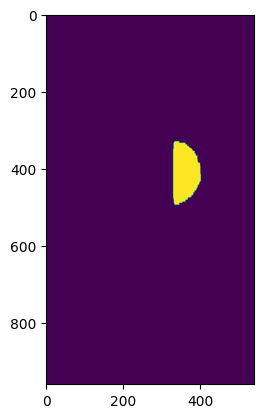

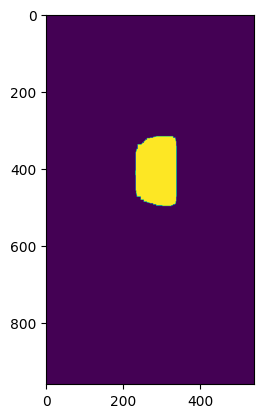

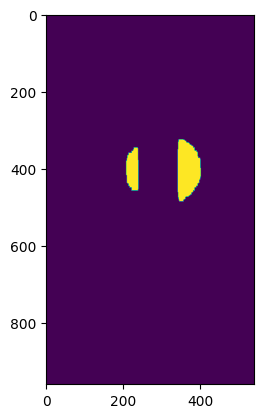

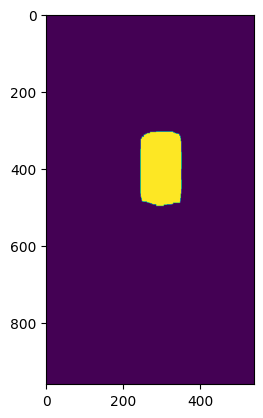

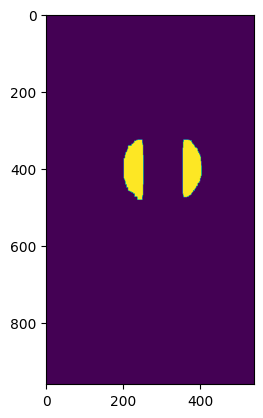

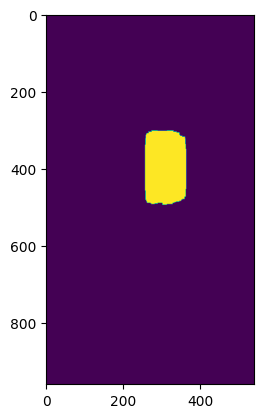

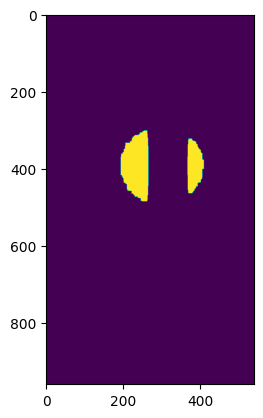

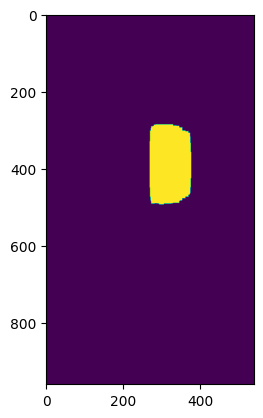

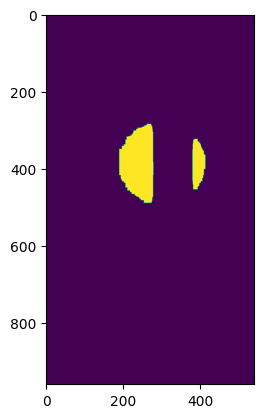

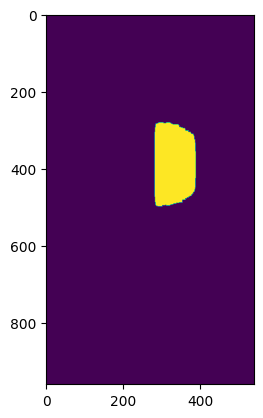

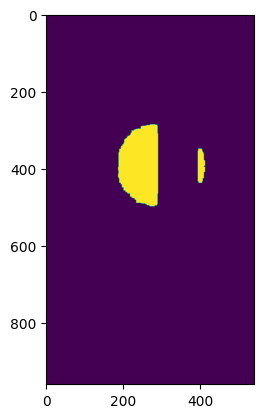

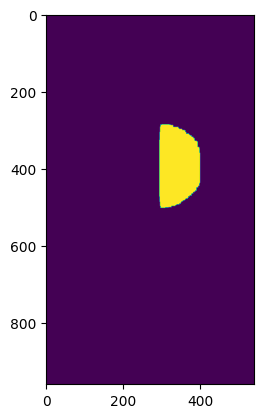

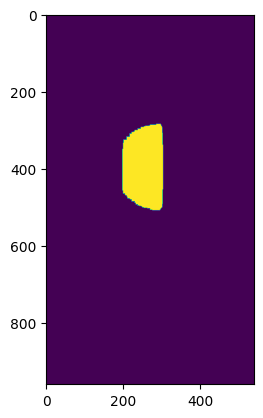

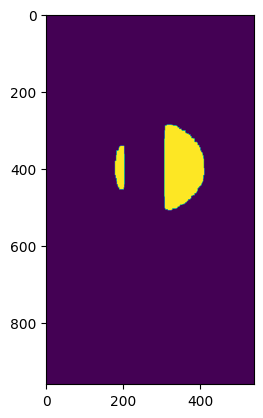

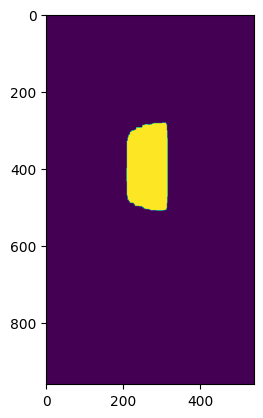

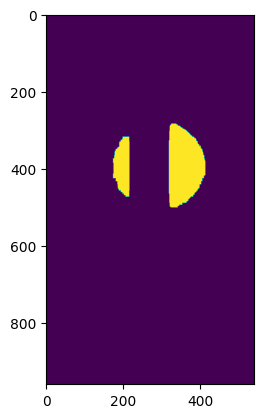

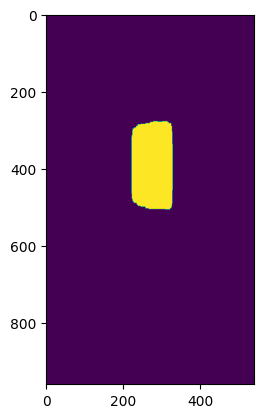

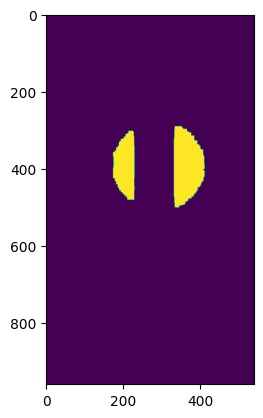

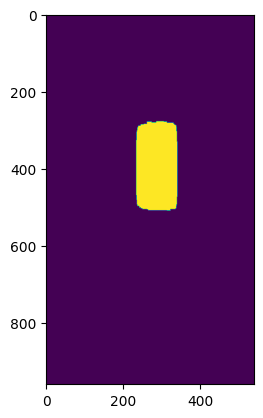

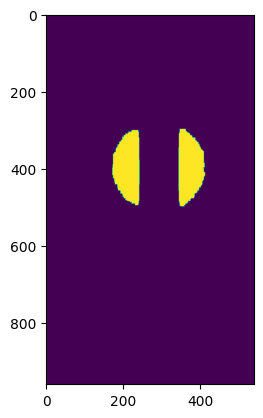

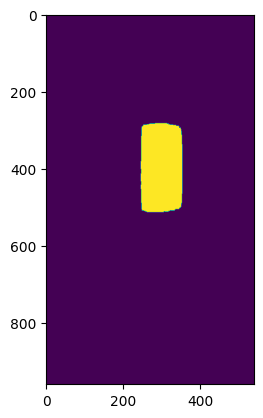

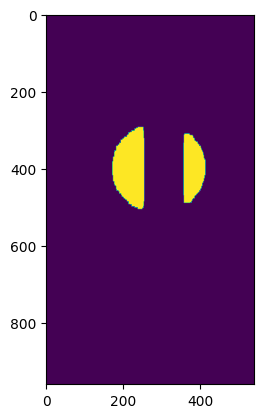

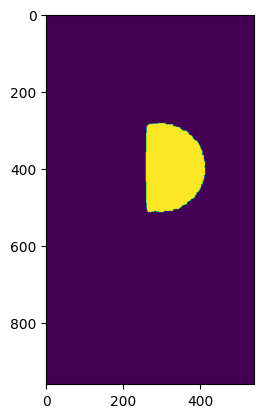

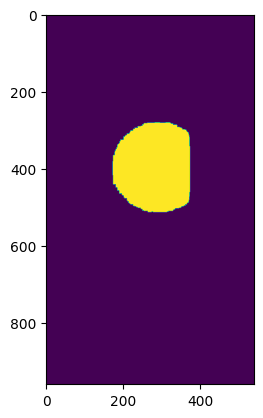

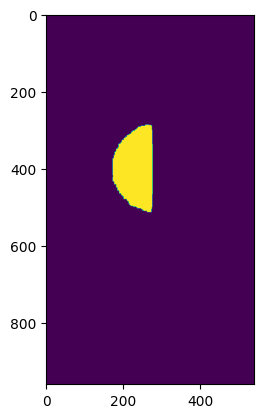

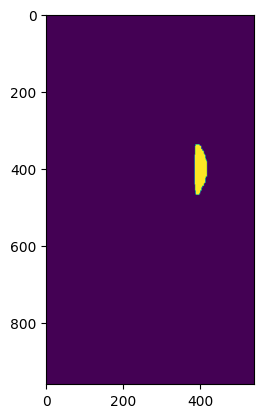

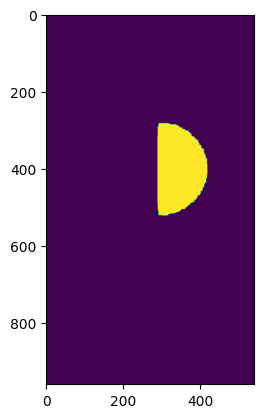

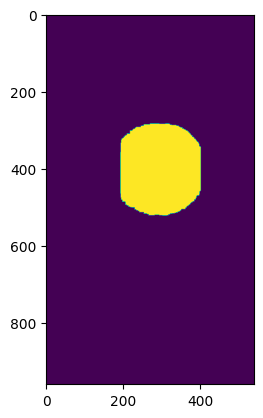

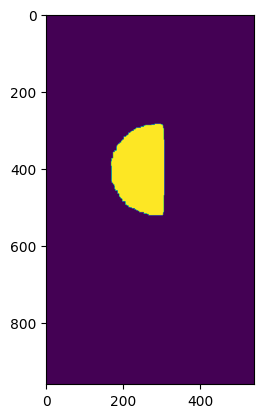

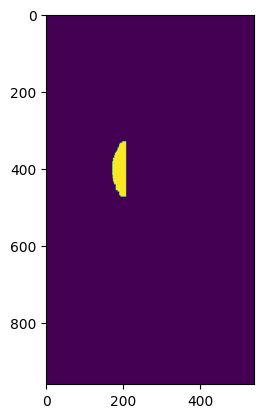

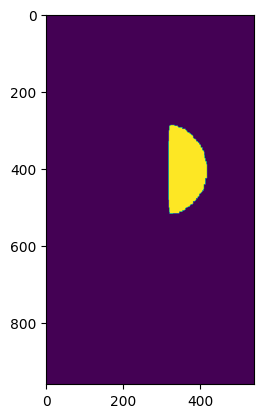

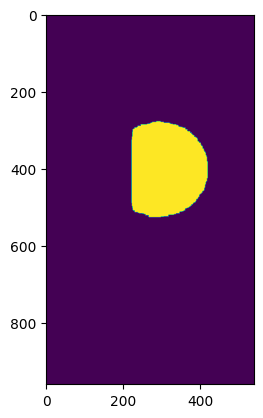

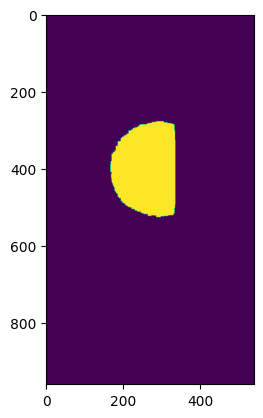

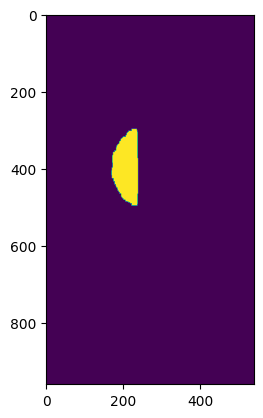

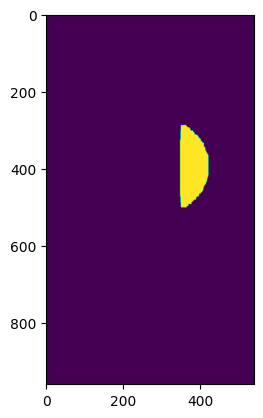

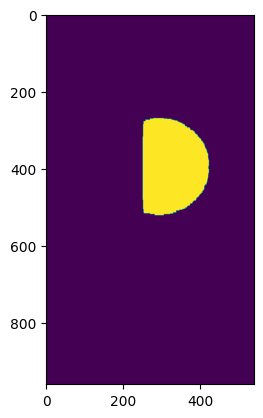

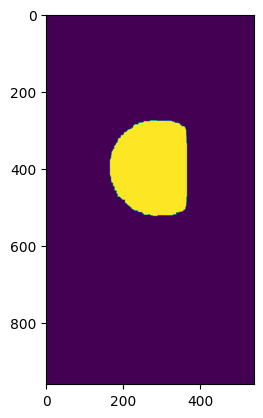

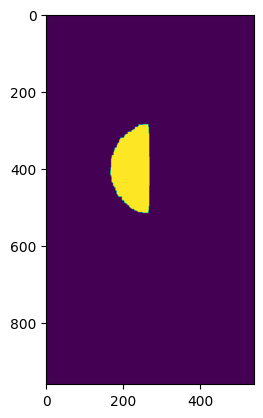

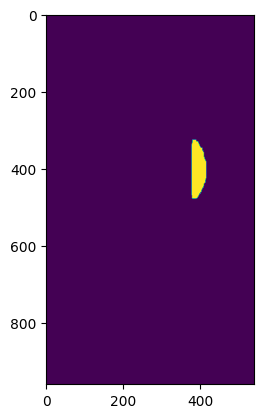

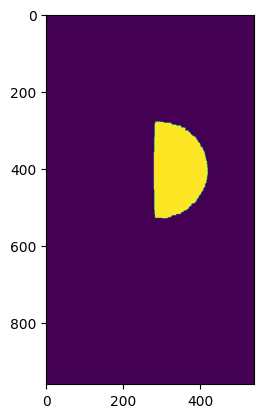

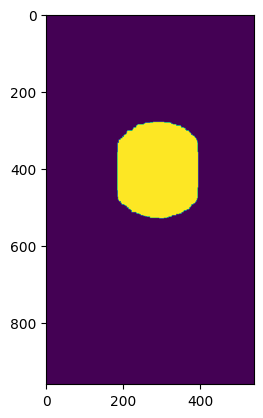

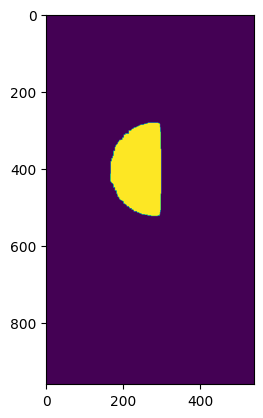

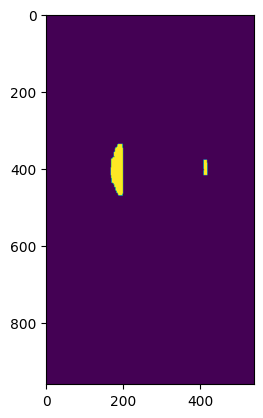

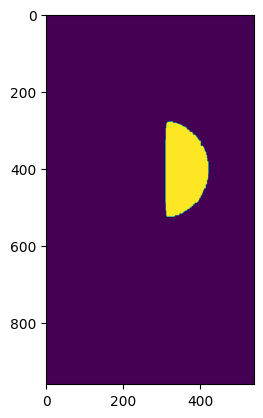

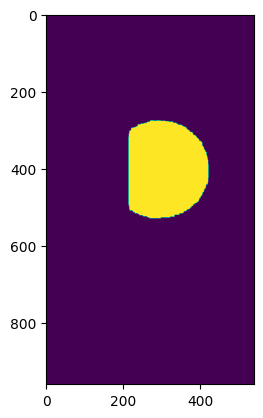

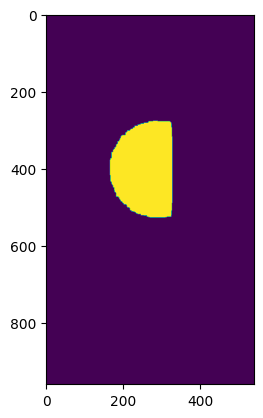

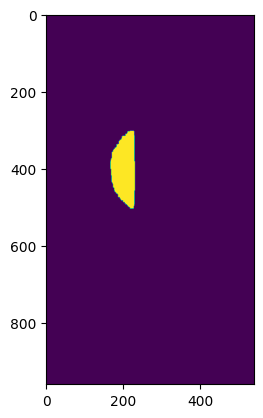

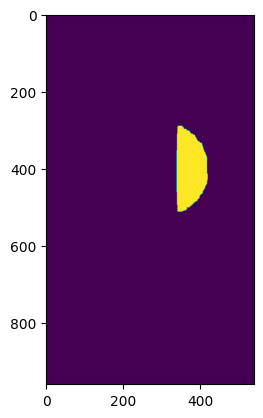

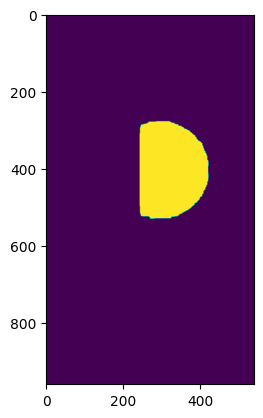

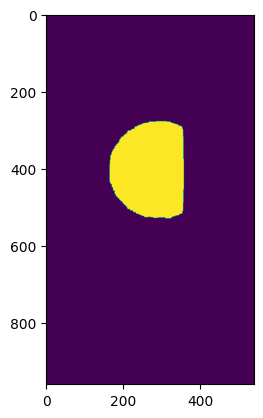

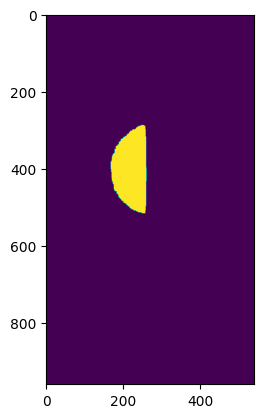

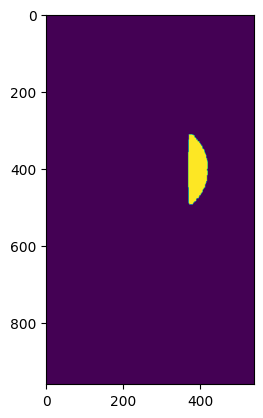

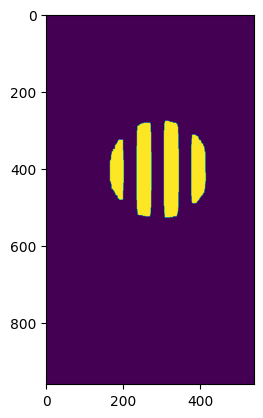

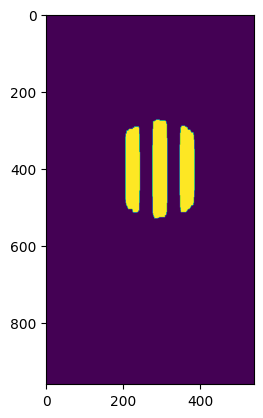

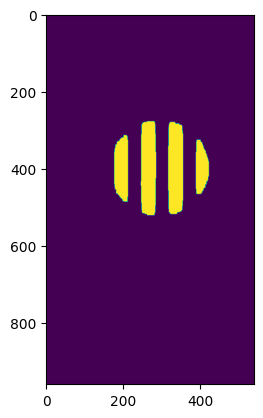

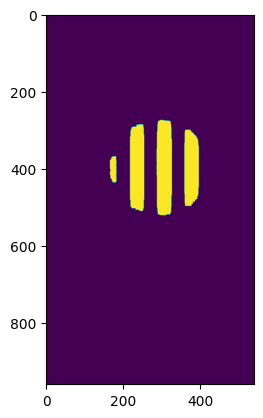

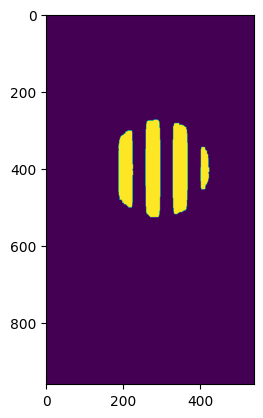

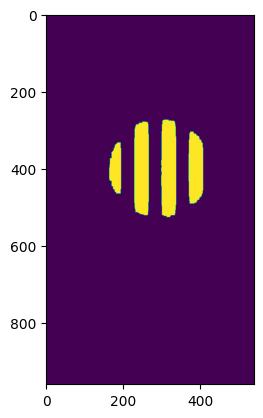

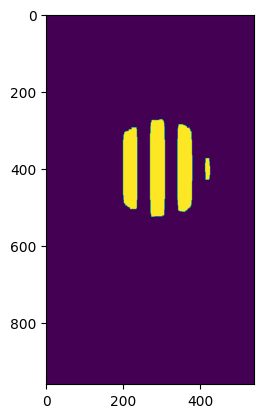

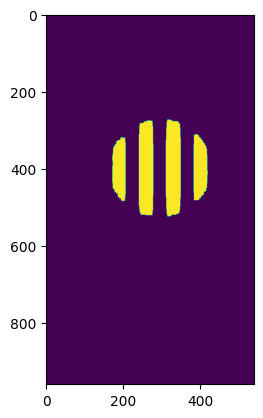

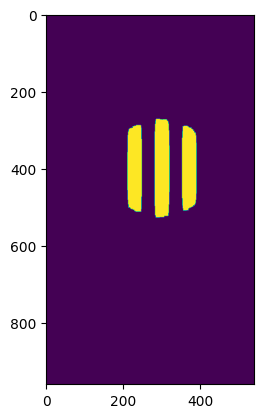

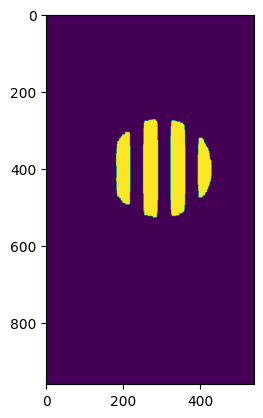

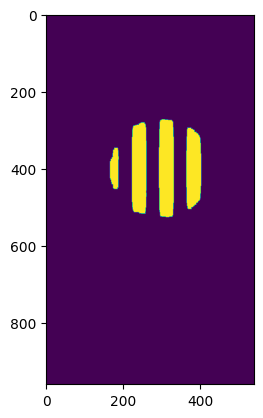

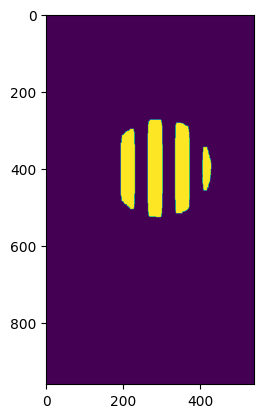

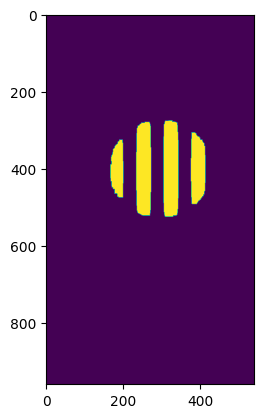

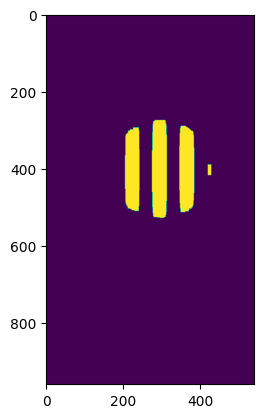

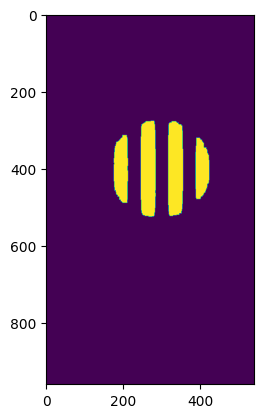

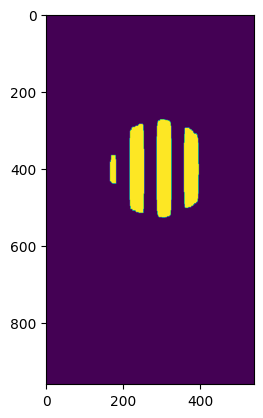

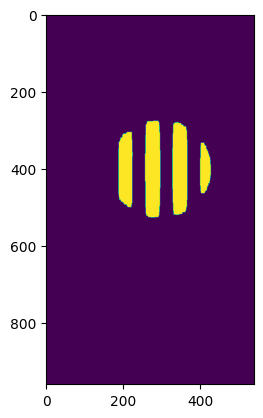

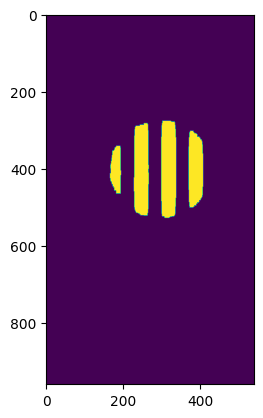

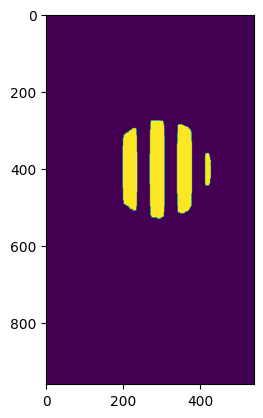

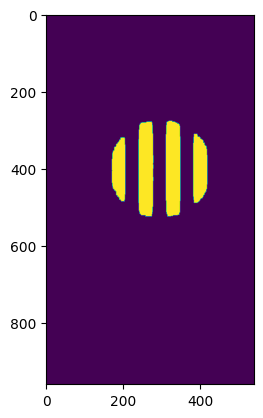

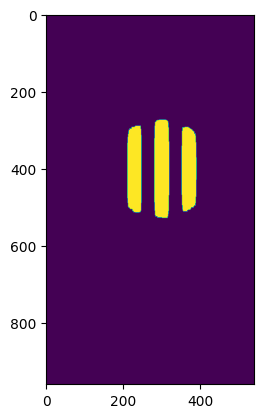

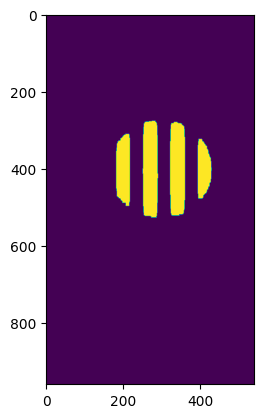

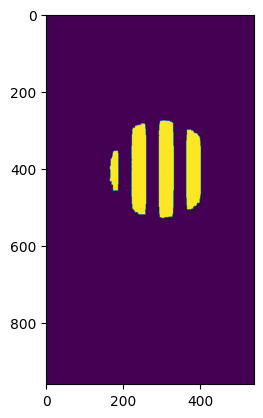

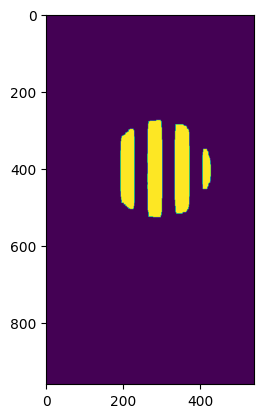

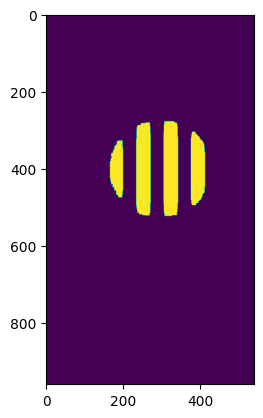

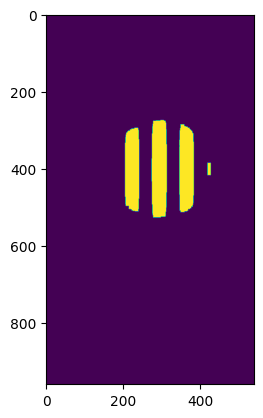

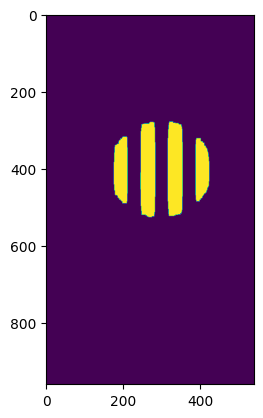

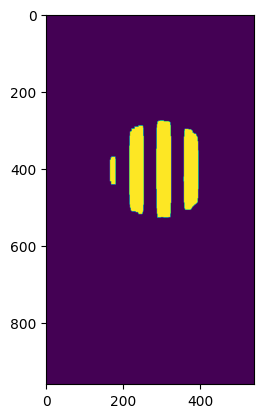

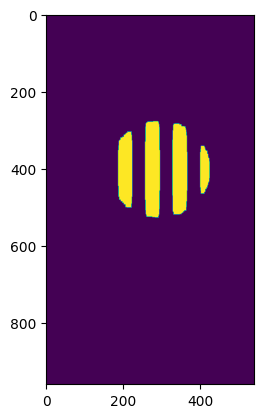

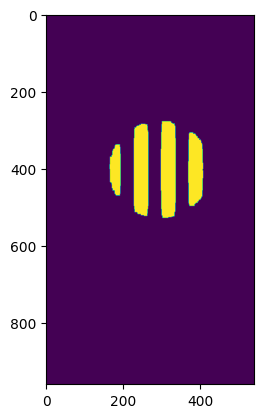

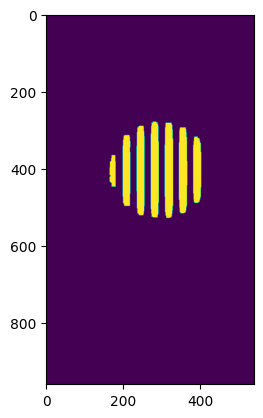

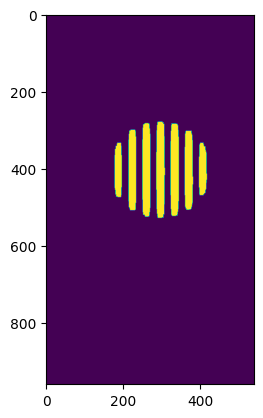

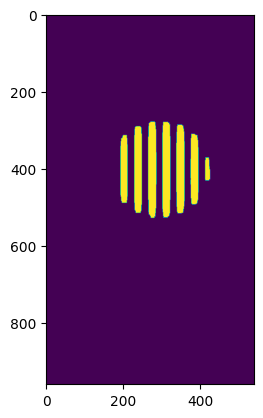

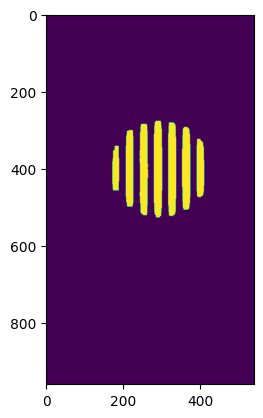

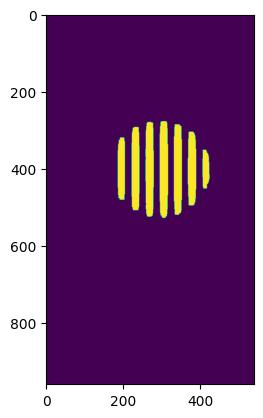

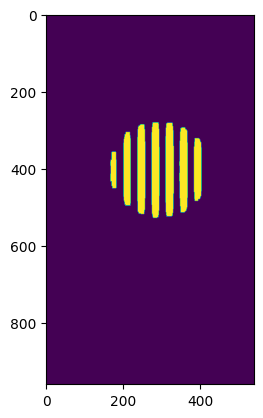

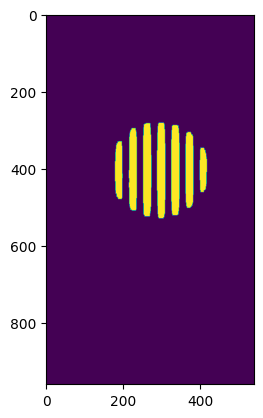

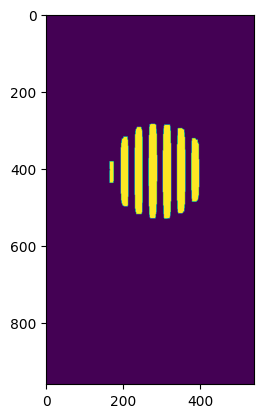

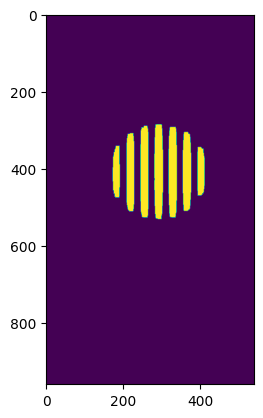

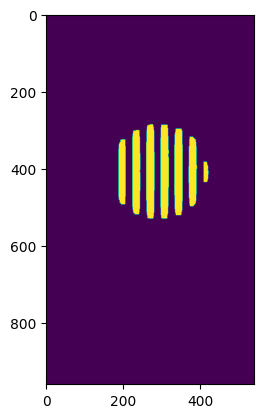

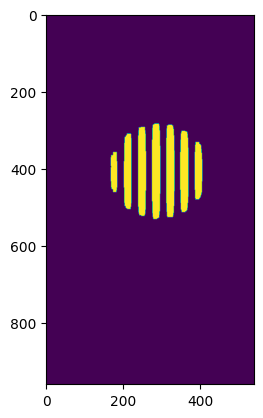

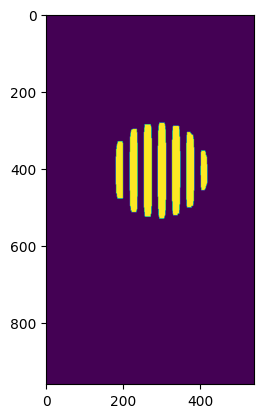

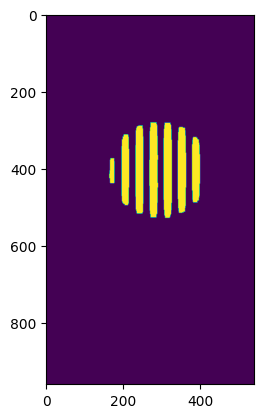

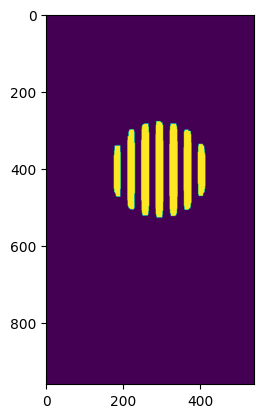

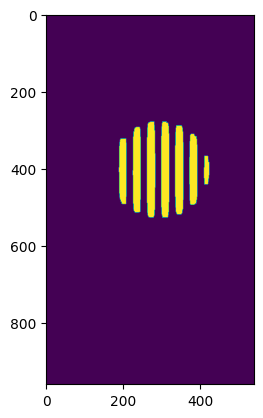

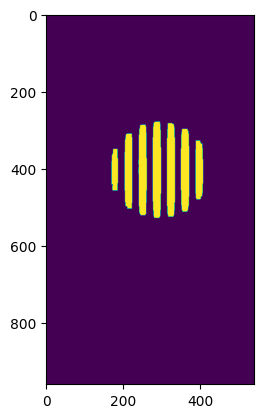

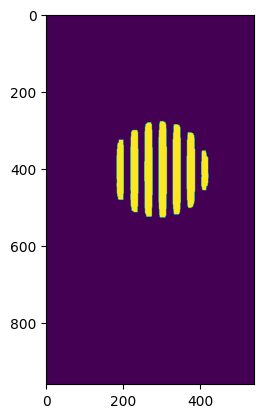

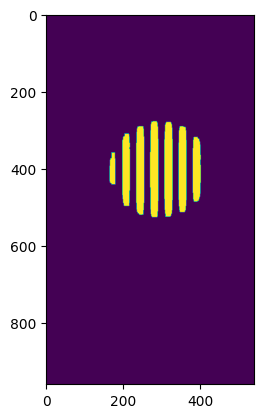

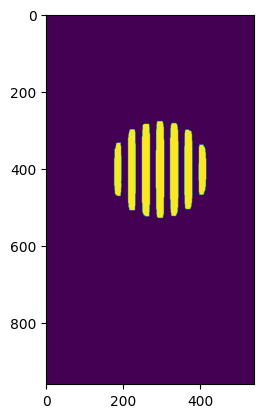

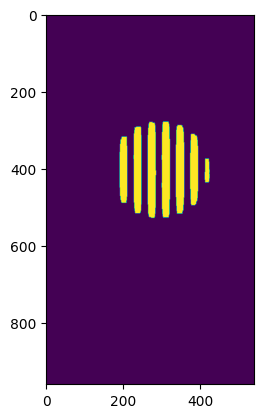

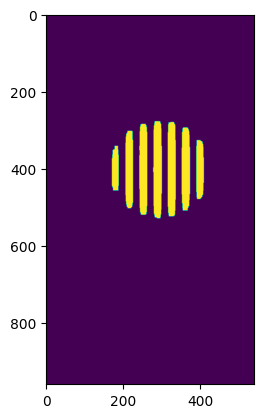

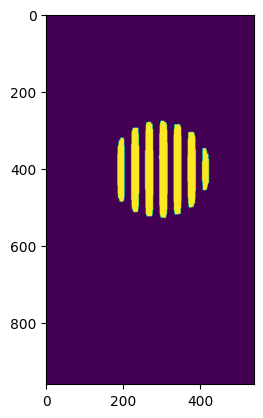

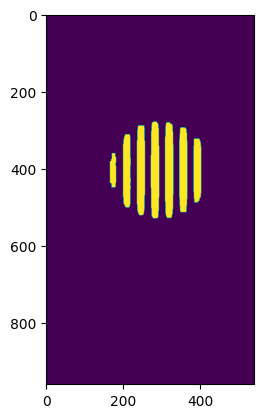

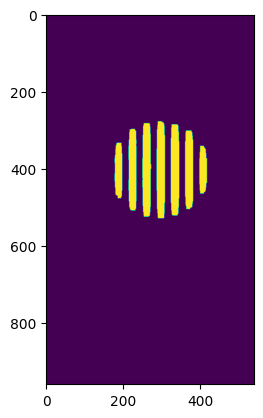

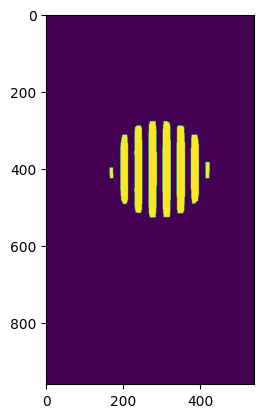

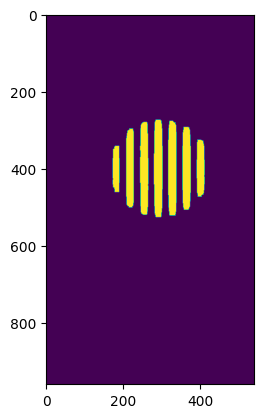

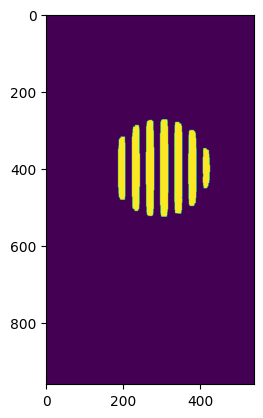

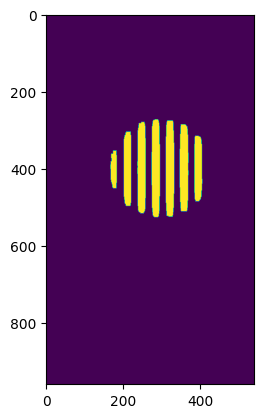

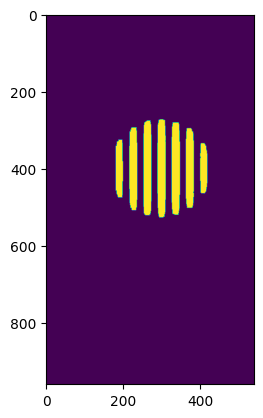

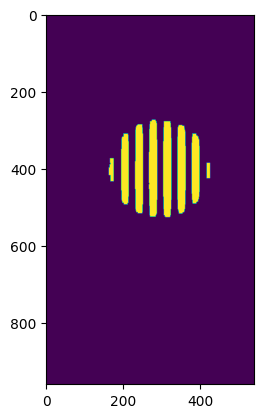

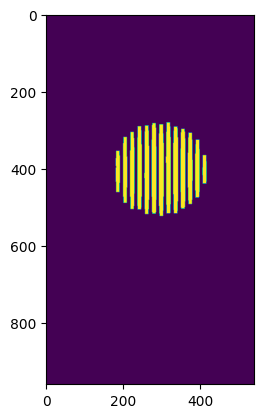

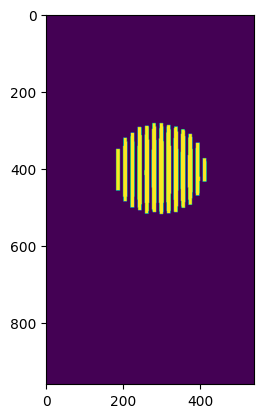

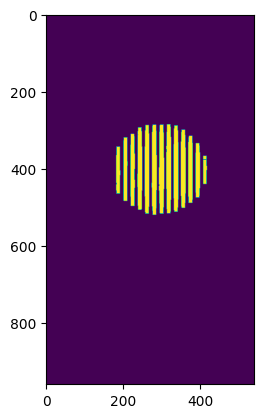

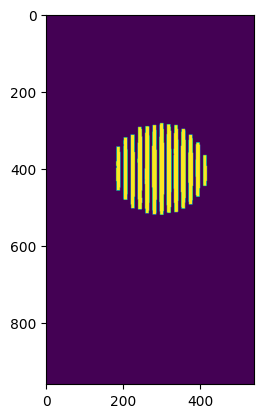

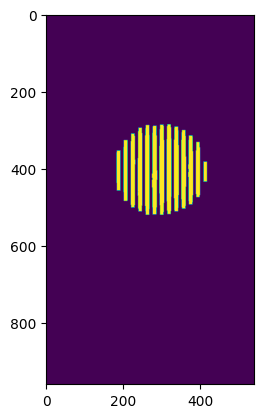

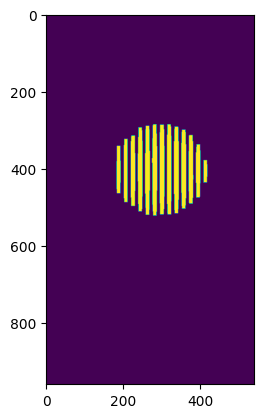

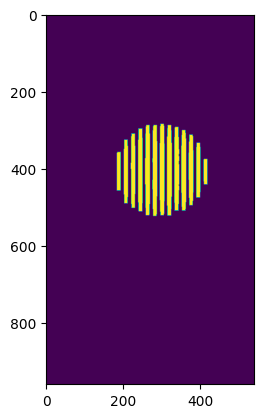

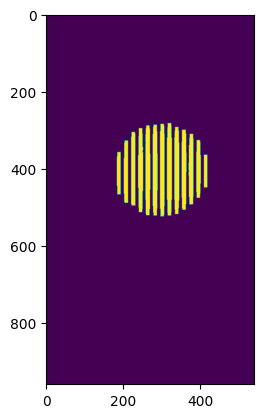

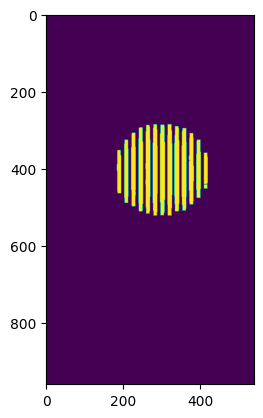

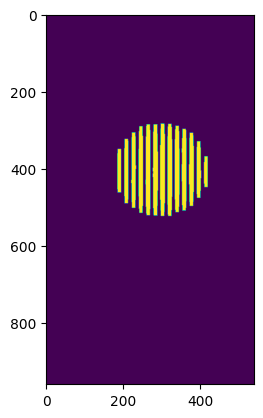

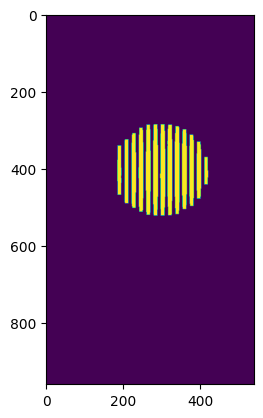

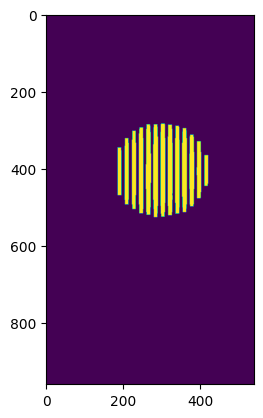

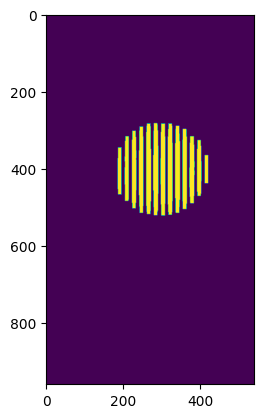

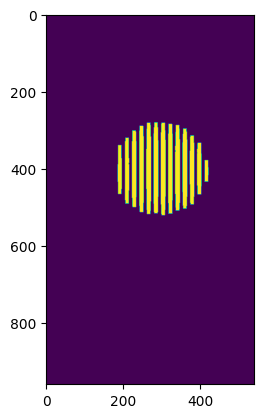

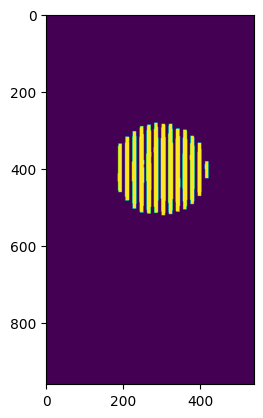

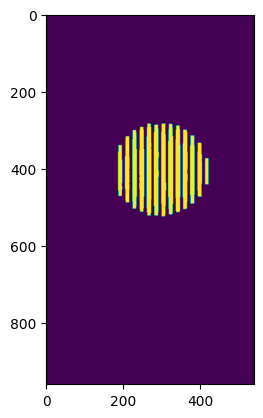

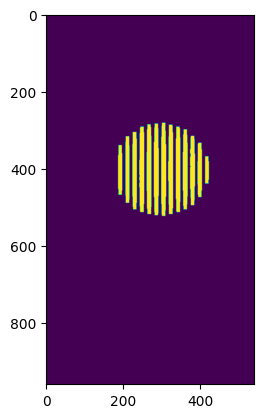

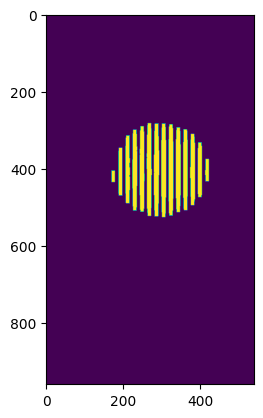

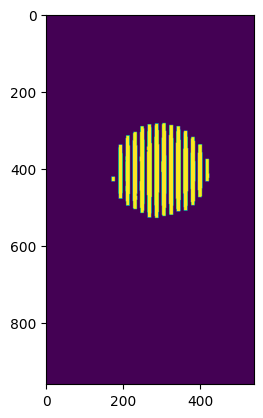

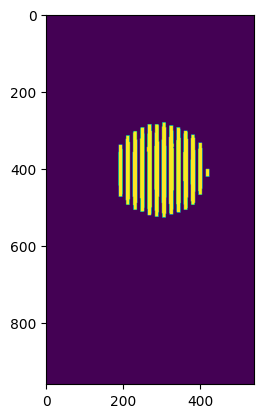

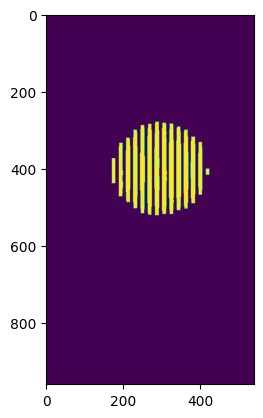

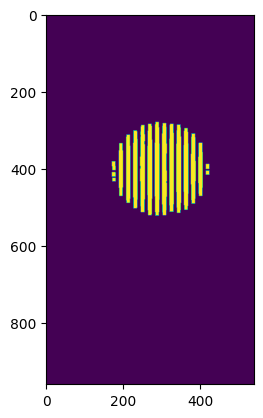

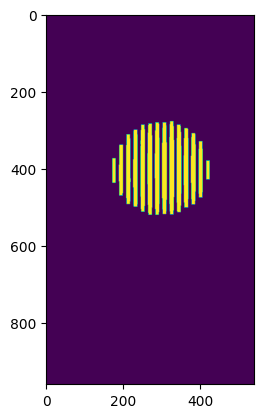

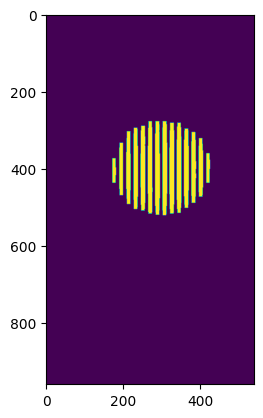

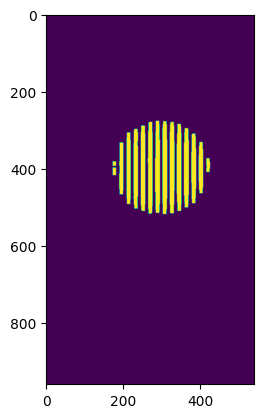

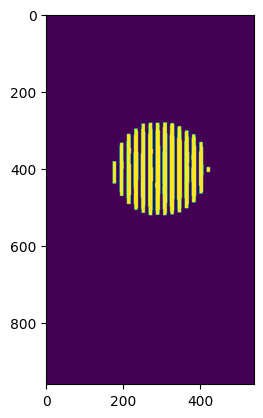

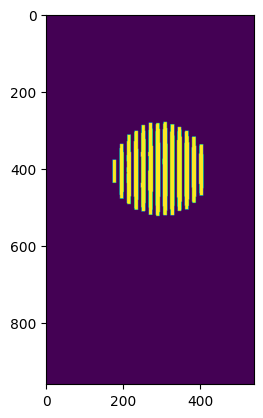

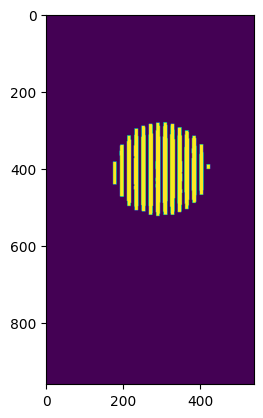

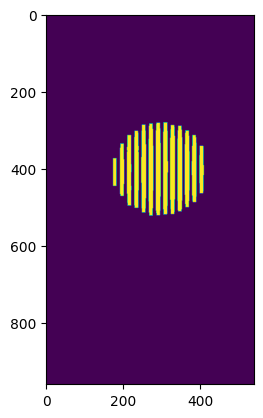

150


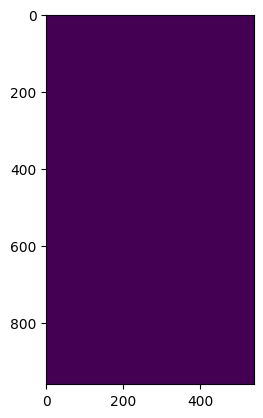

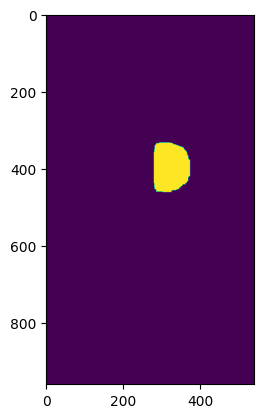

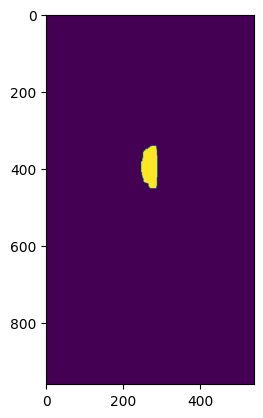

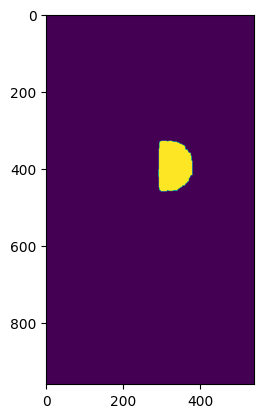

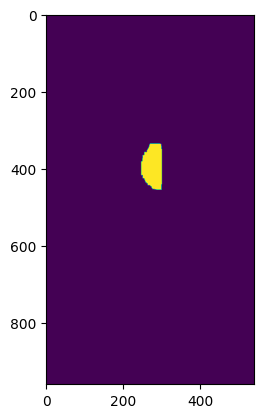

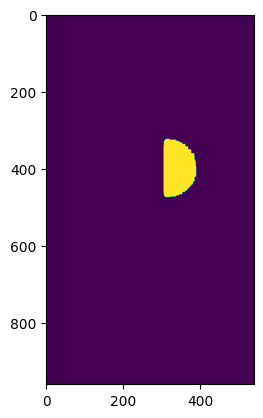

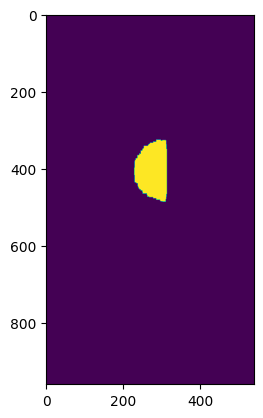

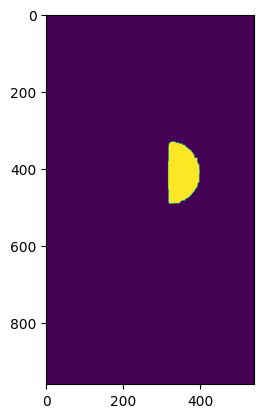

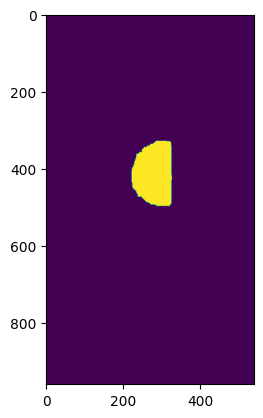

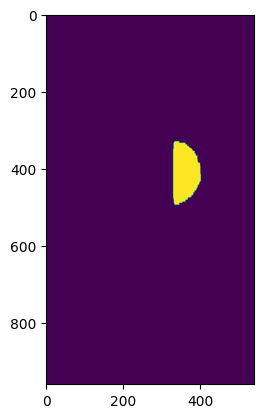

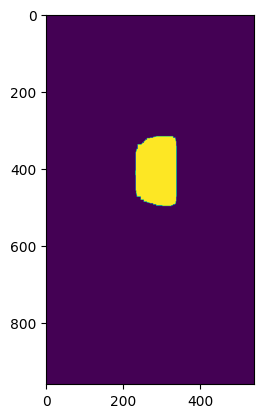

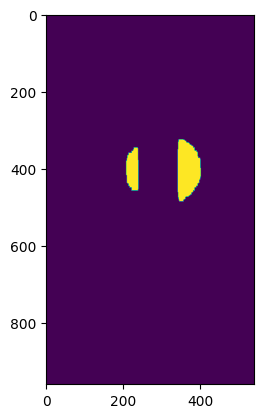

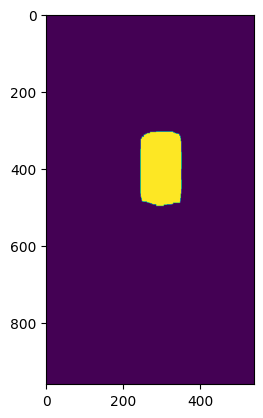

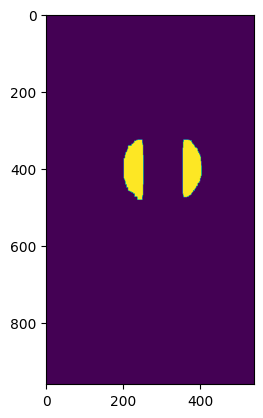

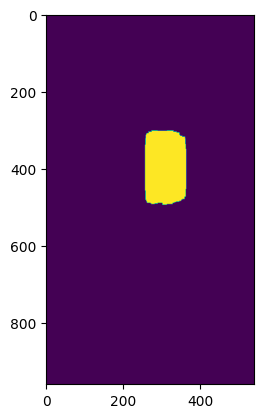

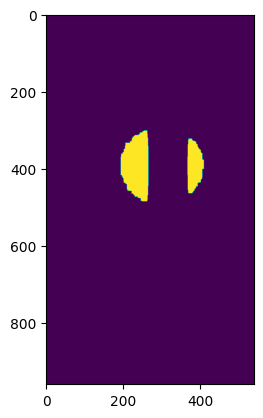

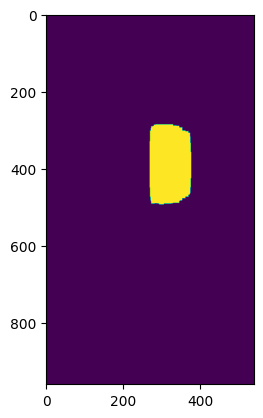

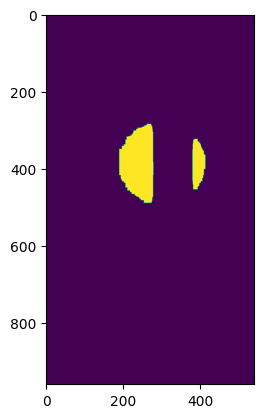

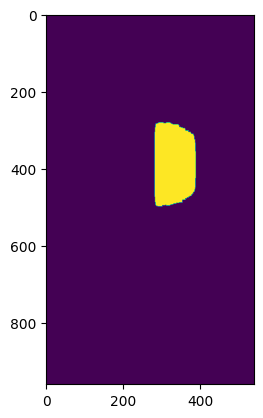

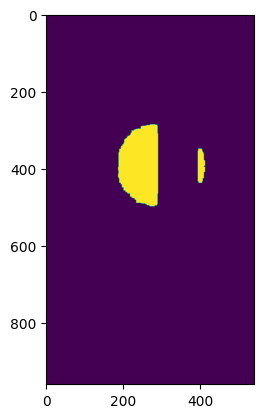

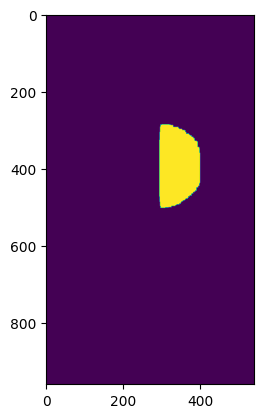

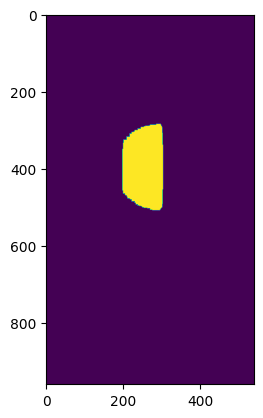

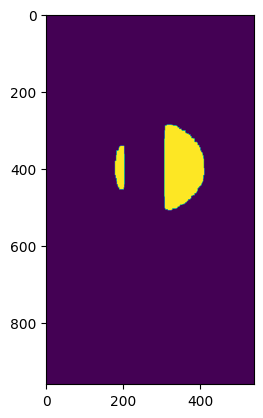

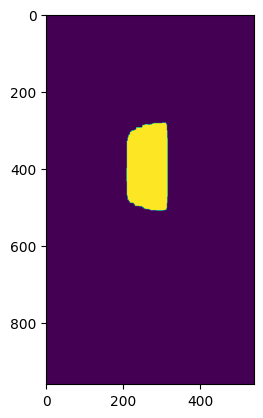

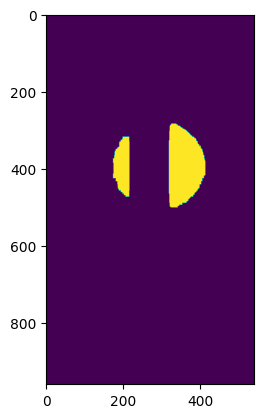

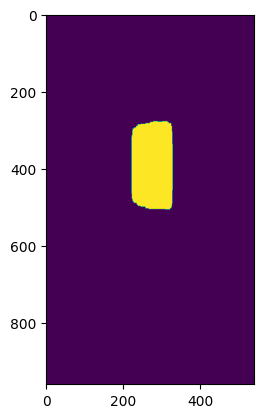

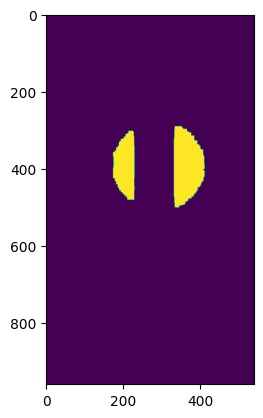

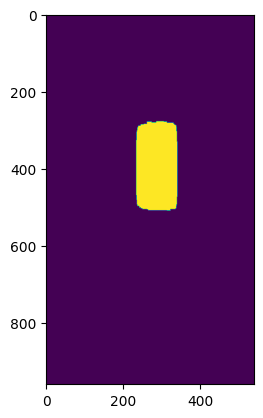

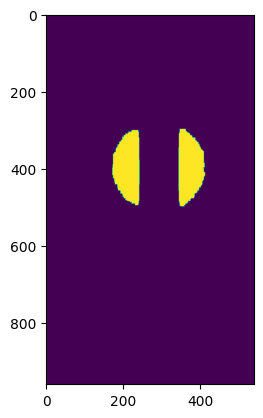

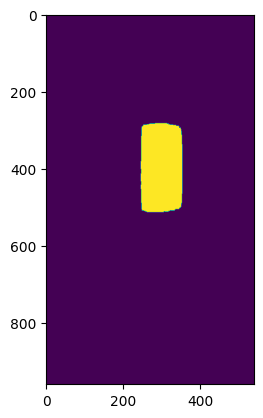

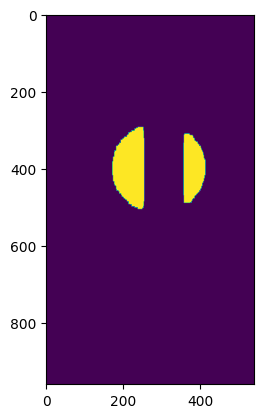

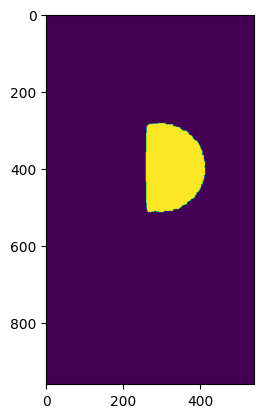

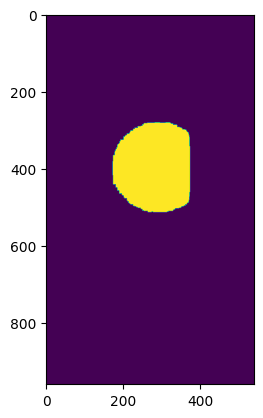

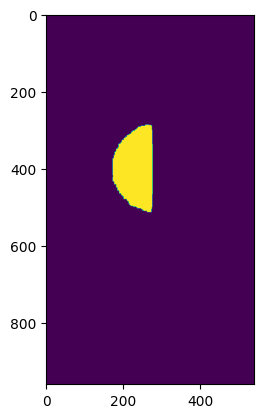

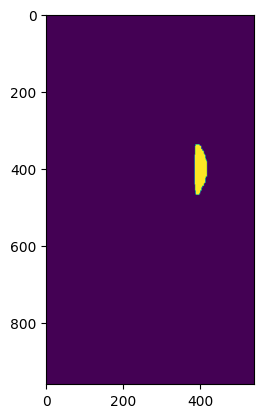

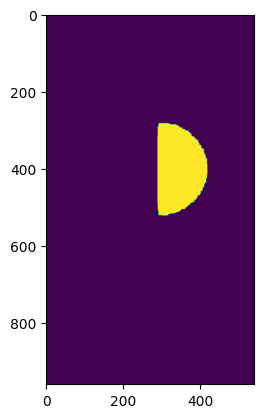

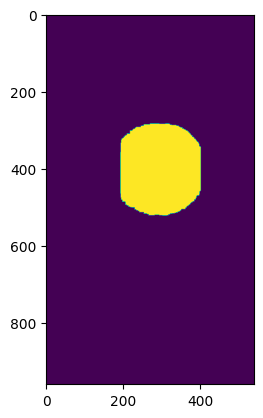

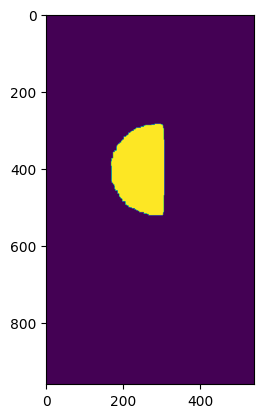

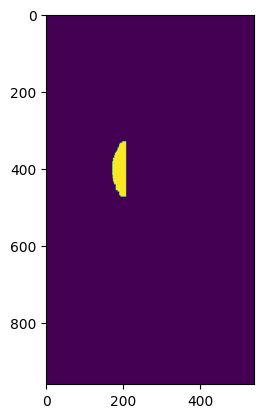

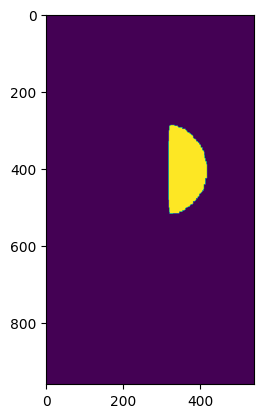

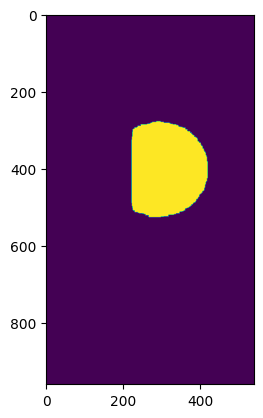

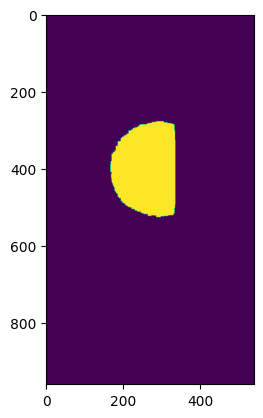

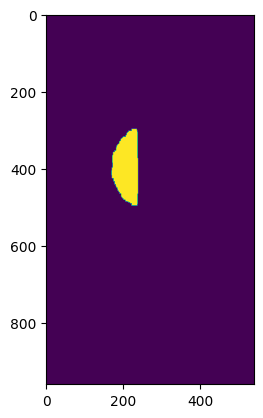

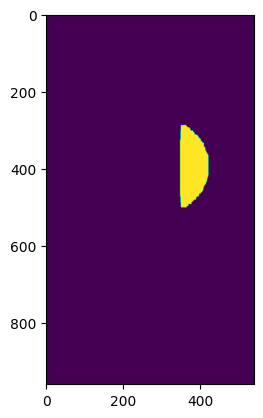

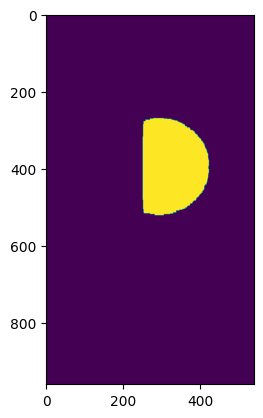

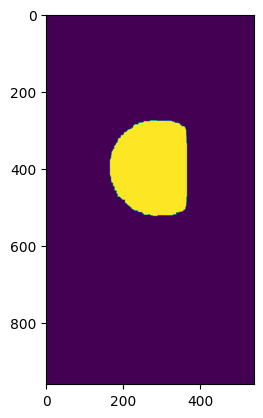

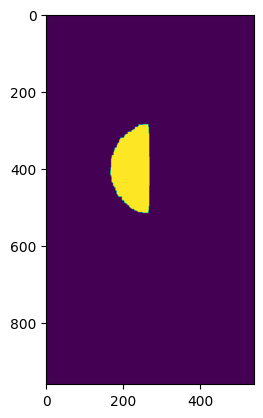

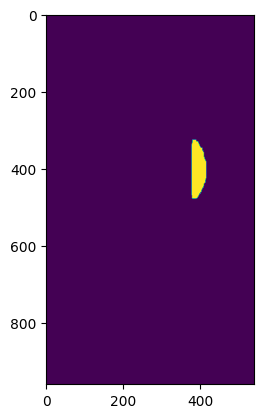

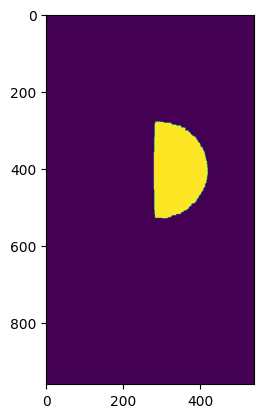

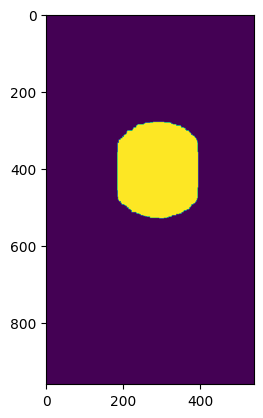

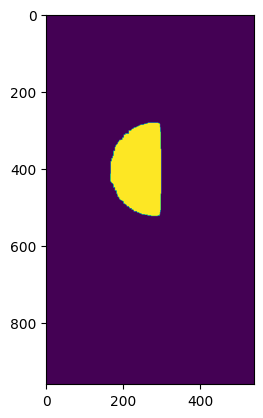

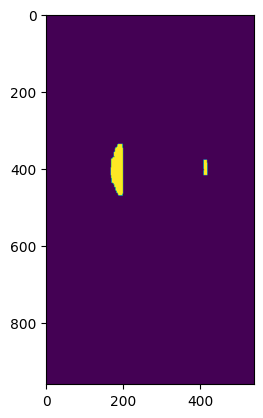

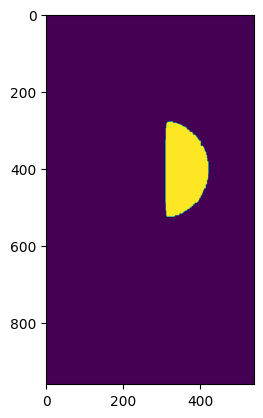

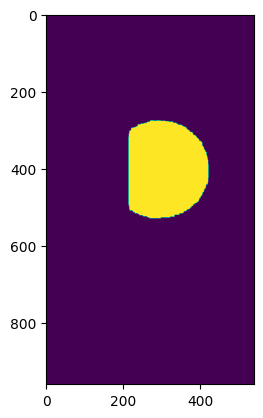

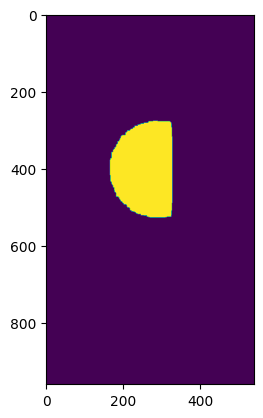

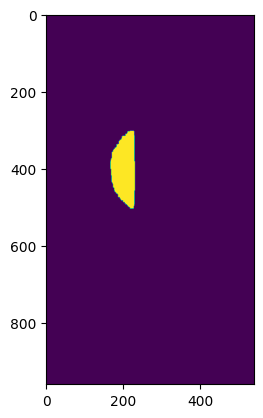

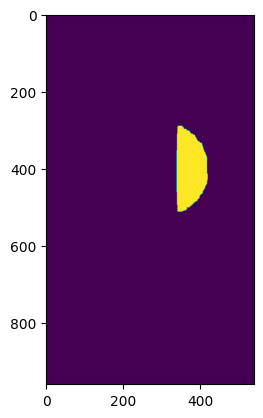

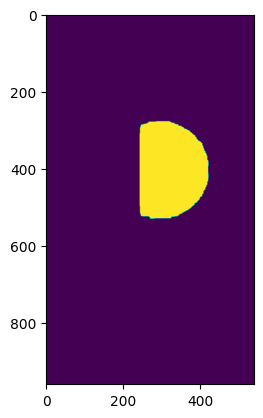

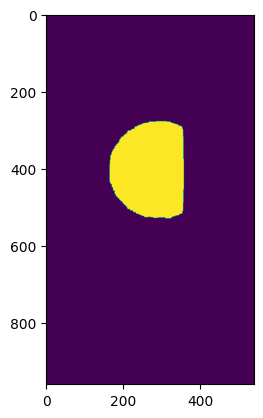

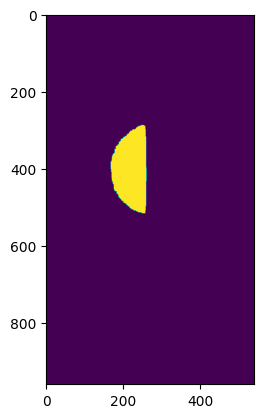

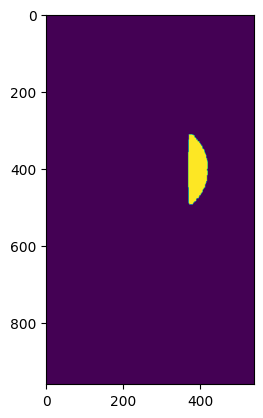

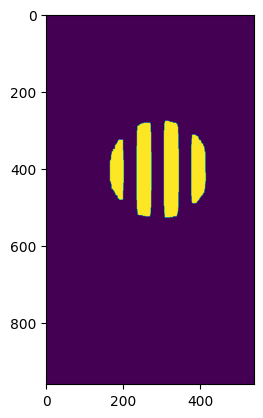

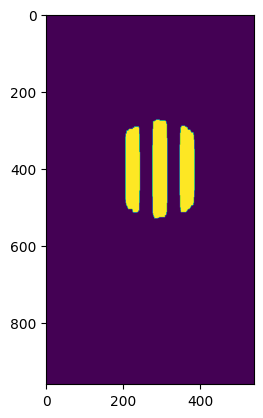

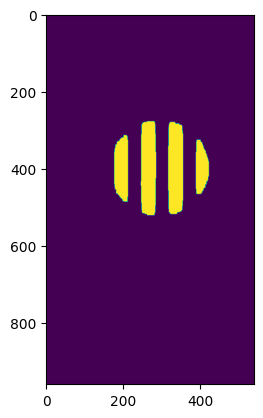

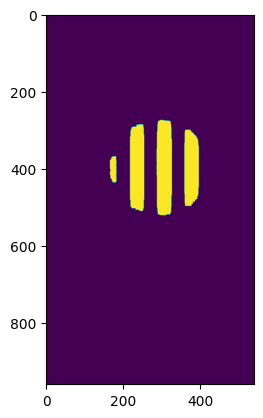

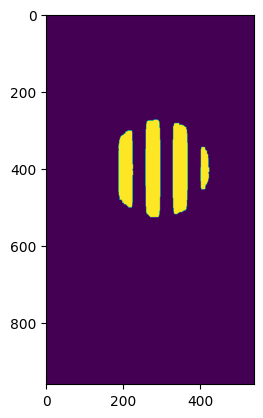

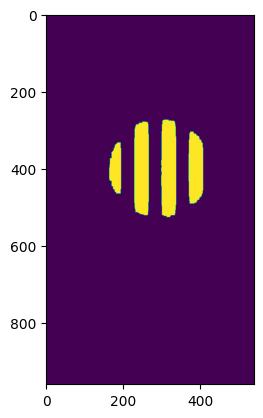

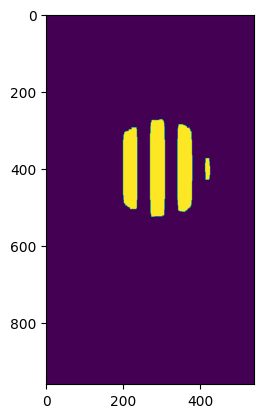

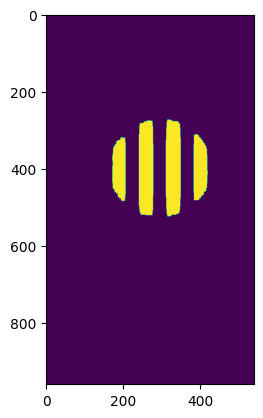

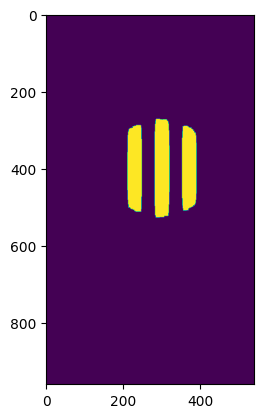

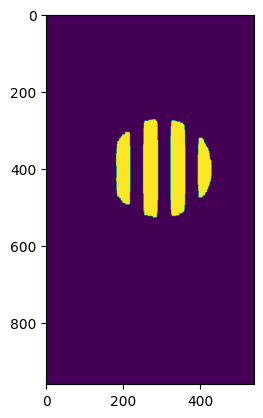

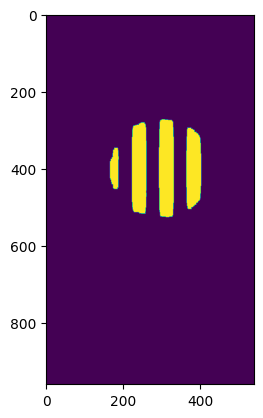

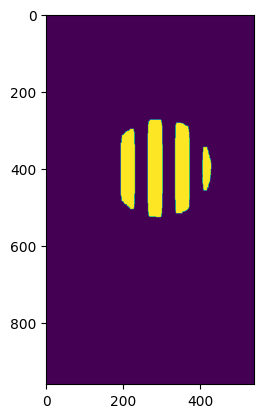

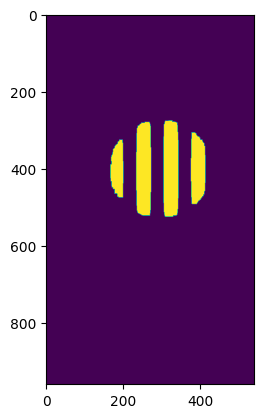

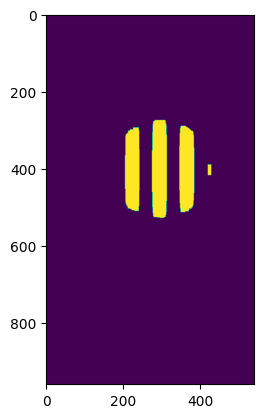

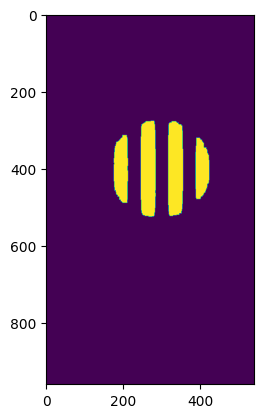

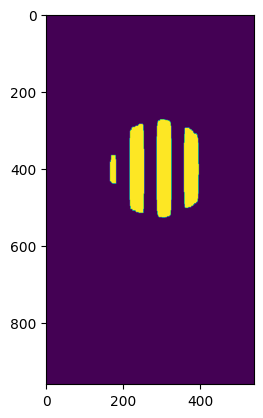

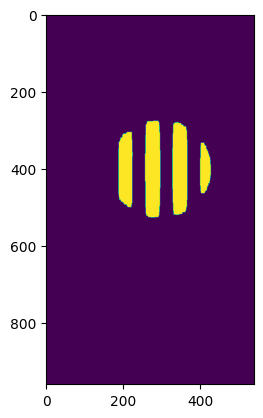

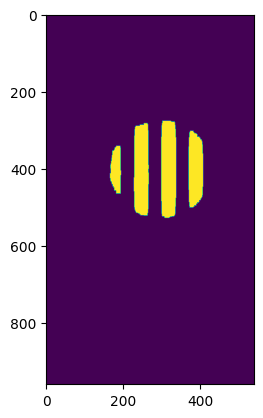

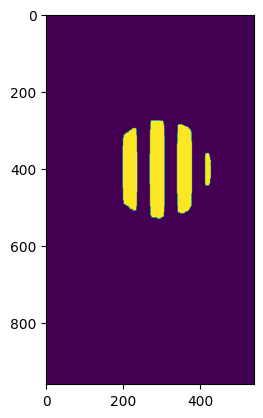

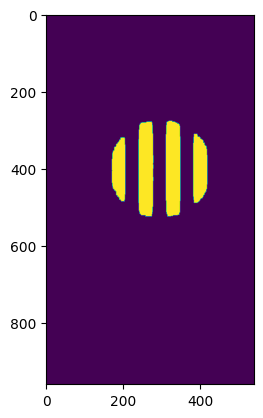

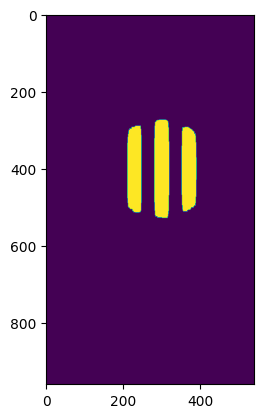

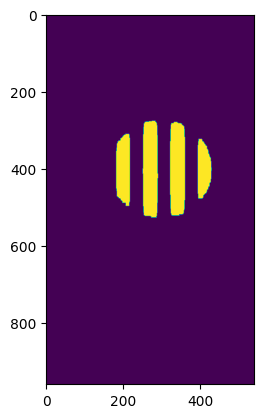

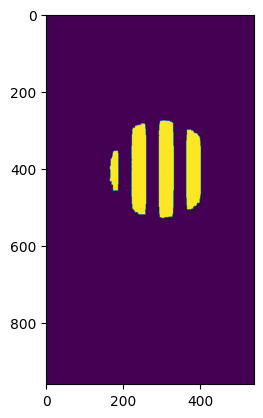

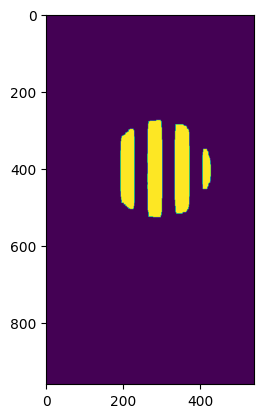

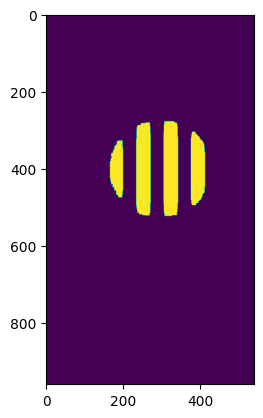

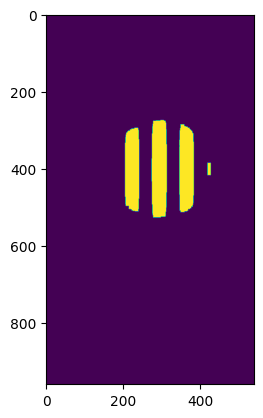

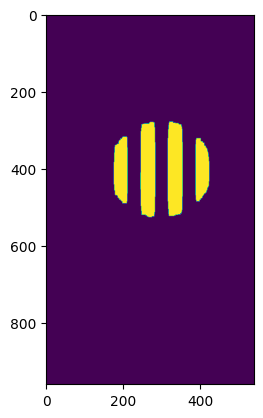

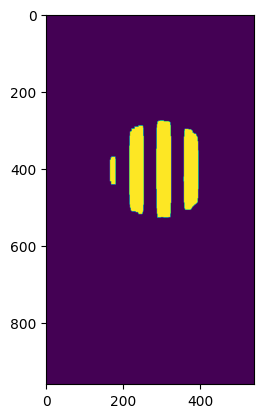

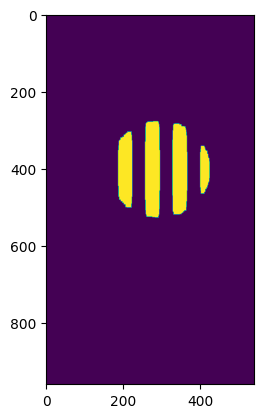

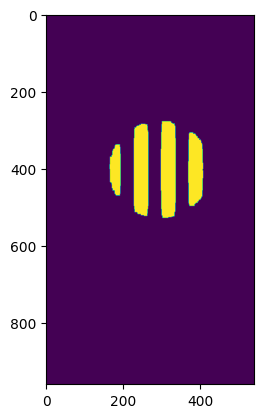

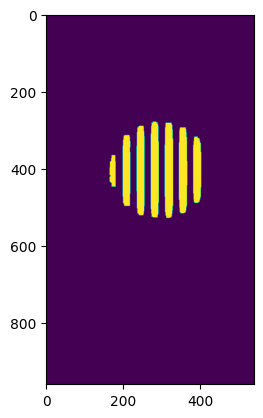

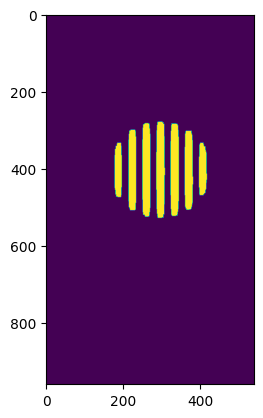

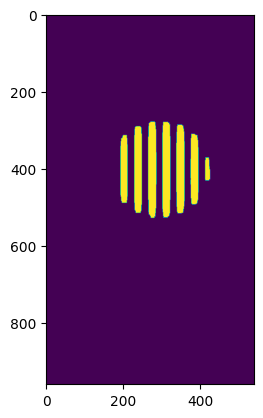

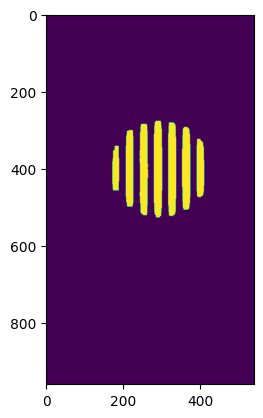

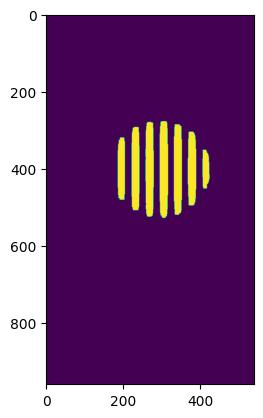

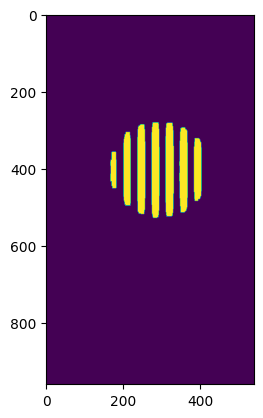

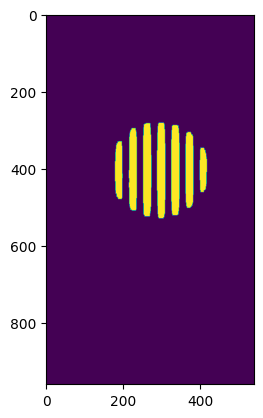

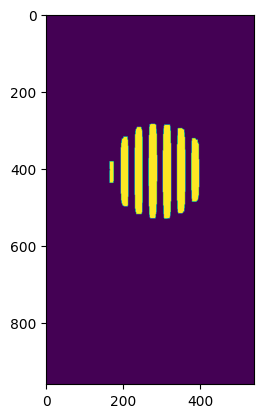

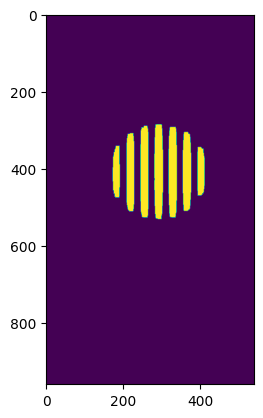

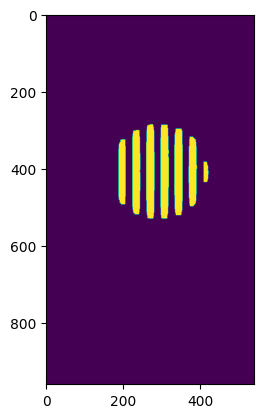

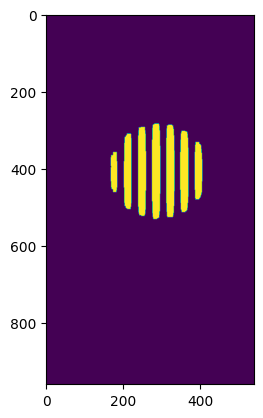

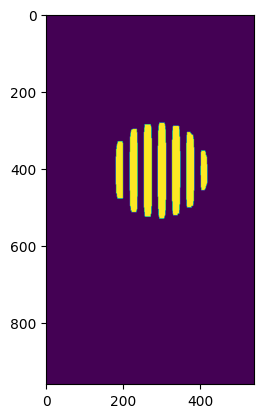

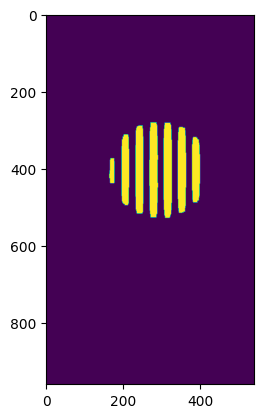

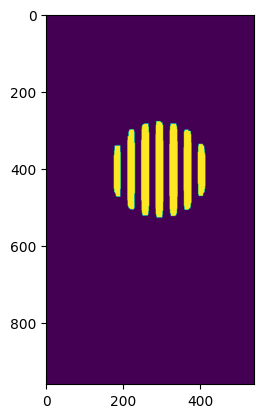

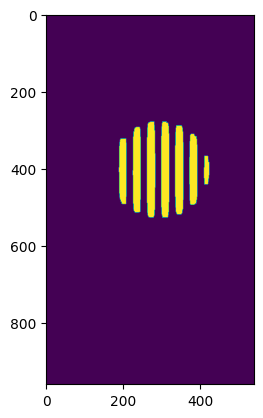

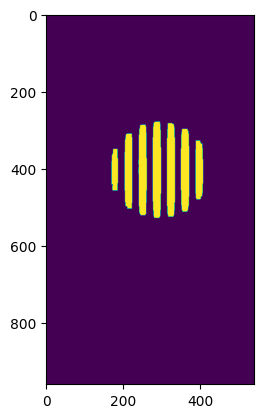

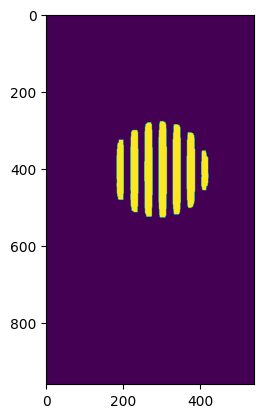

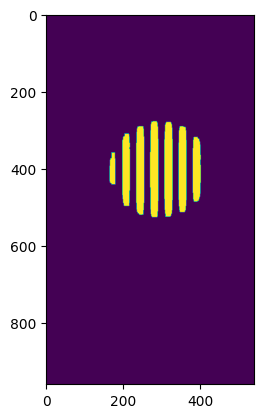

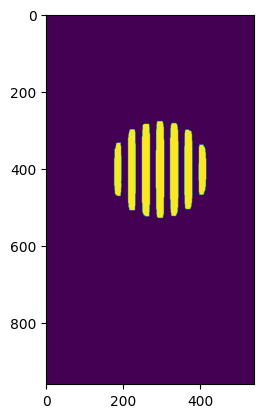

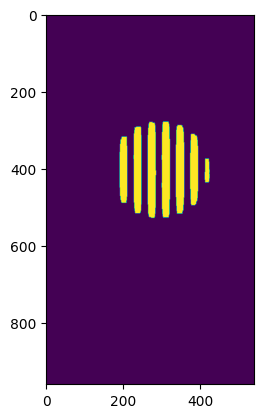

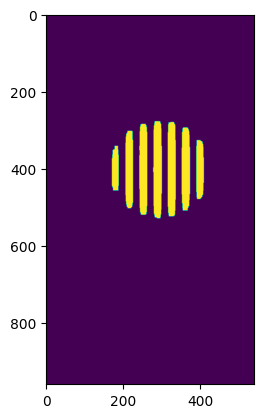

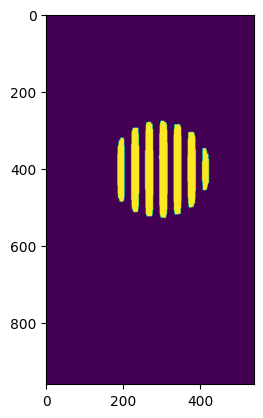

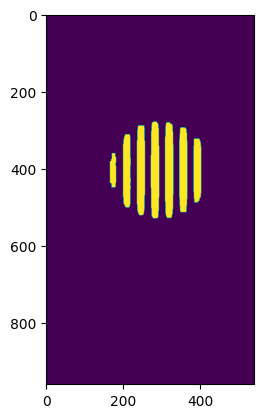

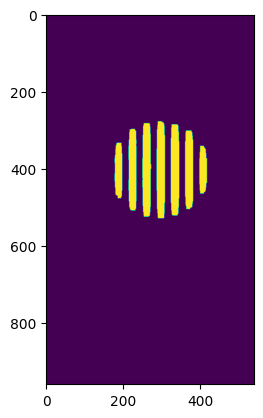

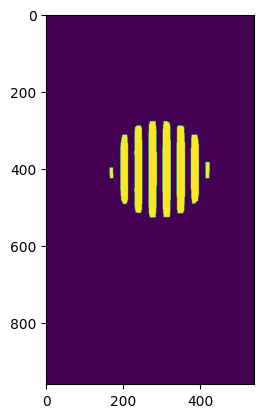

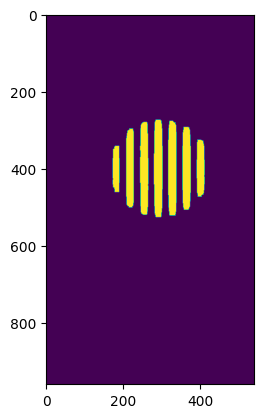

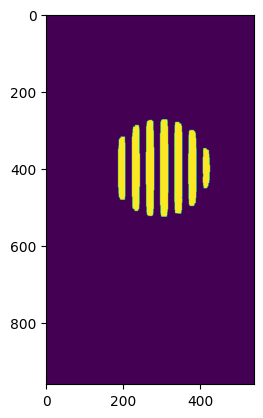

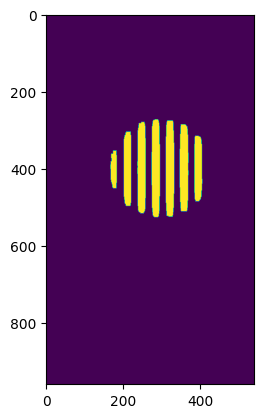

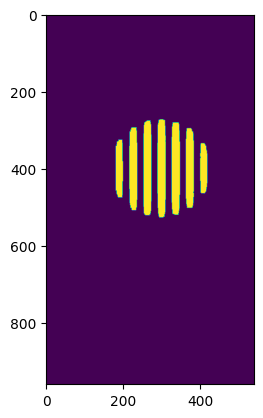

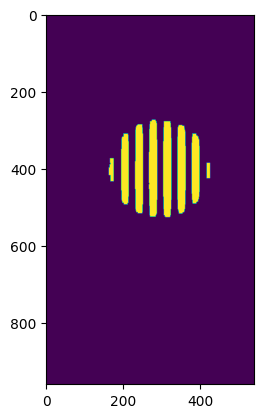

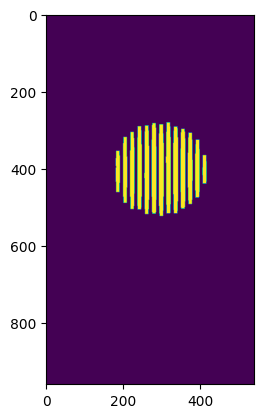

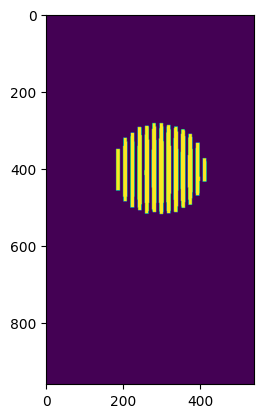

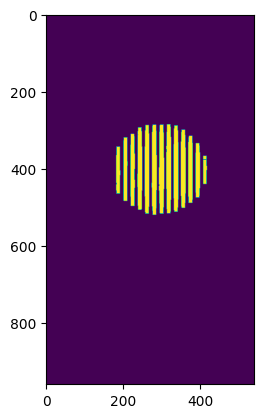

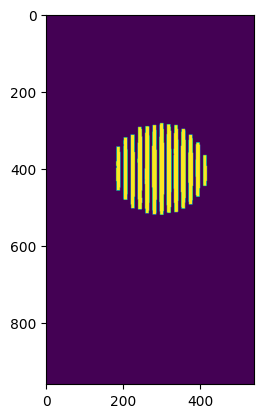

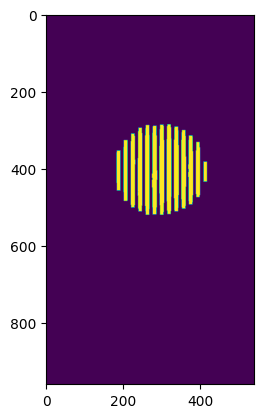

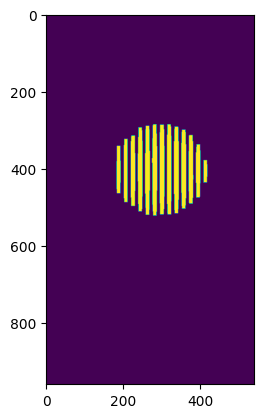

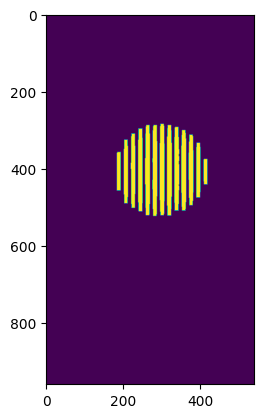

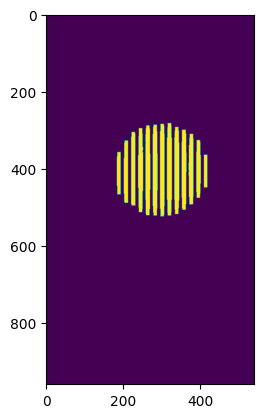

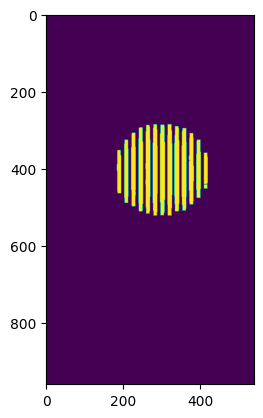

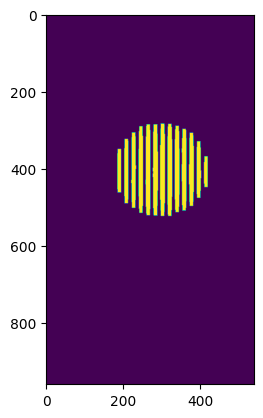

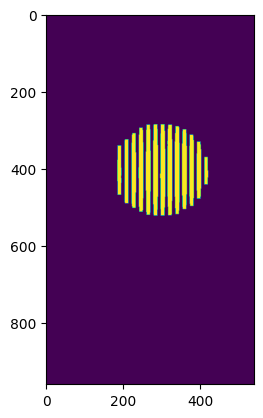

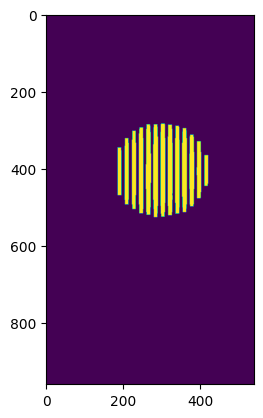

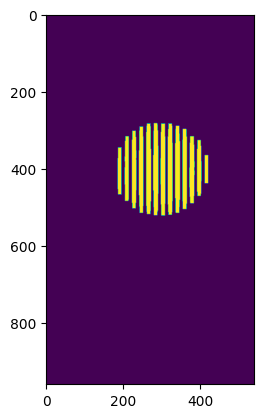

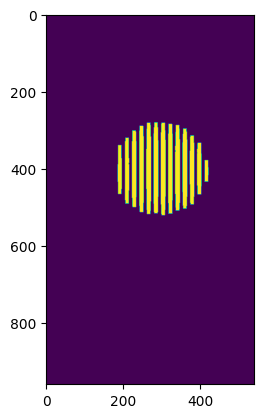

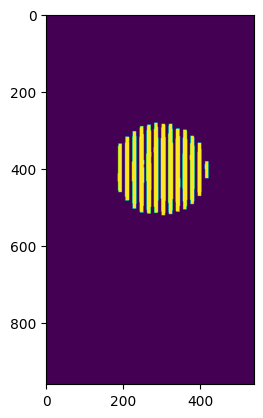

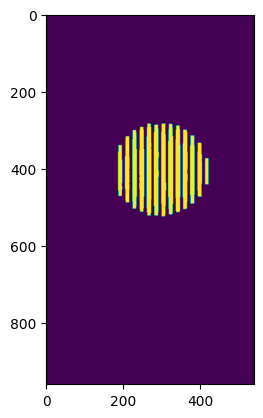

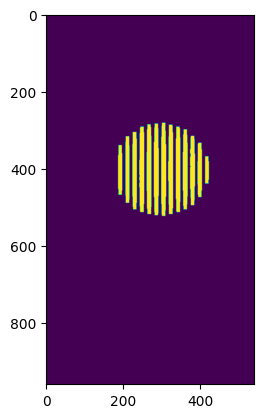

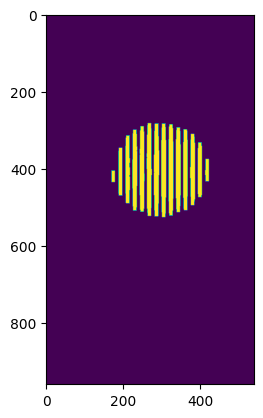

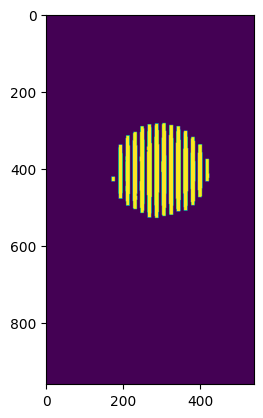

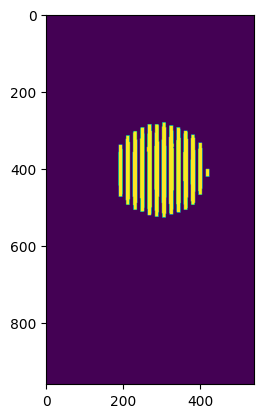

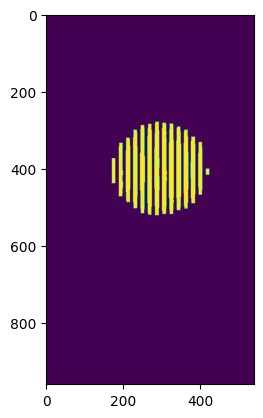

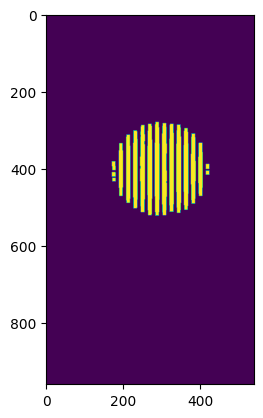

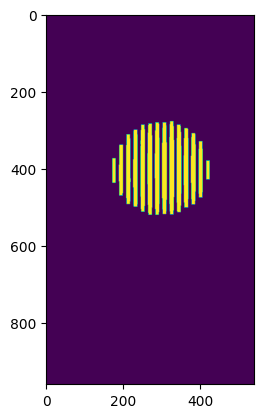

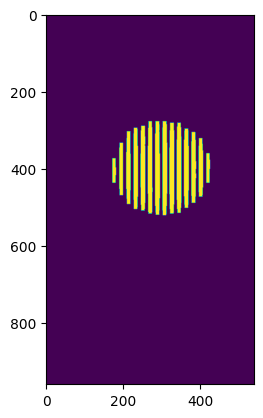

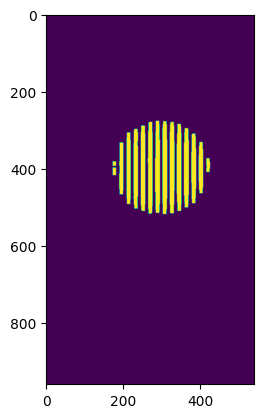

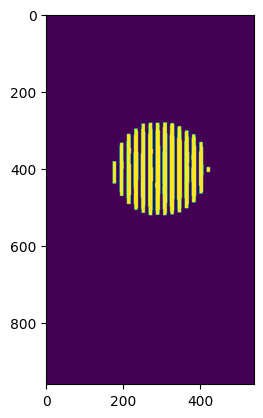

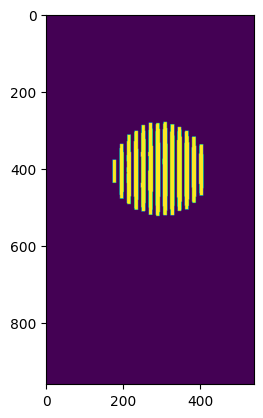

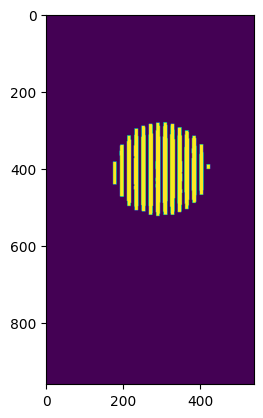

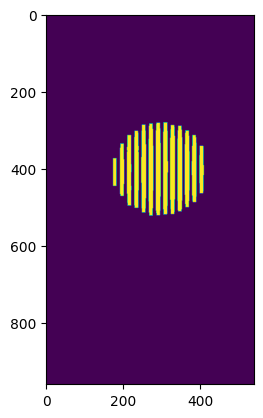

In [15]:
video_path = ["./rolling_shutter/clip_1.mp4", "./rolling_shutter/clip_2.mp4", "./rolling_shutter/clip_3.mp4", "./rolling_shutter/clip_4.mp4", "./rolling_shutter/clip_5.mp4"]

#this is used for saving all of the frames for three patterns
three_patterns = []

##this is used for saving all of the frames for one pattern
thresh_list = []

for video in video_path:
    cap = cv2.VideoCapture(video)
    total = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    i = 0
    while (cap.isOpened() and i<total):
        ret, frame = cap.read()
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray,None,fx=0.5,fy=0.5)
    #         cv2.imshow('Gray',gray)
            ## SEE IF IT GENERATES THRESHOLD
            # thresh = cv2.threshold(gray, 0 , 255 , cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] ##need to adjust the second parameter according to the reality
            thresh =cv2.threshold(gray, 50 , 255 , cv2.THRESH_BINARY)[1]
            ##remove bobles noises
            thresh = cv2.erode(thresh, None, iterations=2)
            thresh = cv2.dilate(thresh, None, iterations=4)
            thresh_list.append(thresh)    
            cv2.waitKey(60)
            i += 1
    three_patterns.append(thresh_list)


#fft for each frames
print(len(three_patterns))
for thresh_list in three_patterns:
    print(len(thresh_list))
    for thresh in thresh_list:
        thresh = cv2.transpose(thresh)
        plt.imshow(thresh)
        plt.show()
    
cap.release()
cv2.destroyAllWindows()

In [ ]:
##This cell is used for calculating spectrum, not needed here
for thresh_list in three_patterns:
    print(len(thresh_list))
    for thresh in thresh_list:
        f = np.fft.fft2(thresh)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))

        #the center coordinates of thresholded image
        rows, cols = thresh.shape
        crow, ccol = int(rows/2), int(cols/2)

        magnitude_spectrum = np.fft.fftshift(magnitude_spectrum)

        frequencies_x = np.fft.fftfreq(cols, d=1)
        frequencies_y = np.fft.fftfreq(rows, d=1)

        #show the frequency range output below
        plt.subplot(121), plt.imshow(thresh, cmap='gray')
        plt.title('Thresholded Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(magnitude_spectrum, cmap='gray', extent=(frequencies_x.min(), frequencies_x.max(), frequencies_y.min(), frequencies_y.max()))
        plt.colorbar(label='Magnitude')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Frequency Spectrum')

        # plt.show()

150


C:\Users\99503\AppData\Local\Temp\ipykernel_15528\3071032520.py:6: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(fshift))


150
150
150
150


In [16]:
average_stripe_list = []
for thresh_list in three_patterns:
    for thresh in thresh_list:
        # transpose the image
        transposed_image = cv2.transpose(thresh)
        
        # Using Canny to detect the edge
        edges = cv2.Canny(transposed_image, 50, 150)
        
        # a list to store the stripe widths
        stripe_widths = []
        # for every lines of image
        for row in range(edges.shape[0]):
            row_edges = edges[row, :]
            transitions = np.where(np.diff(row_edges) != 0)[0]
            
            # calculate the distance between two transitions
            for i in range(0, len(transitions), 2):
                width = transitions[i+1] - transitions[i]
                stripe_widths.append(width) #used for average width calculating
        
        # average width calculation
        average_width = np.mean(stripe_widths)
        
        print("average stripe width:", average_width)
        average_stripe_list.append(average_width)


average stripe width: nan
average stripe width: 1.4883720930232558
average stripe width: 1.2045454545454546
average stripe width: 1.443609022556391
average stripe width: 1.2875
average stripe width: 1.3708609271523178
average stripe width: 1.3395061728395061
average stripe width: 1.2981366459627328
average stripe width: 1.4260355029585798
average stripe width: 1.2333333333333334
average stripe width: 1.4502762430939227
average stripe width: 1.1813186813186813
average stripe width: 1.422279792746114
average stripe width: 1.1639344262295082
average stripe width: 1.398477157360406
average stripe width: 1.187116564417178
average stripe width: 1.3923444976076556
average stripe width: 1.2068452380952381
average stripe width: 1.3235294117647058
average stripe width: 1.2466887417218544
average stripe width: 1.2995391705069124
average stripe width: 1.3191964285714286
average stripe width: 1.2029850746268658
average stripe width: 1.3449781659388647
average stripe width: 1.196524064171123
average

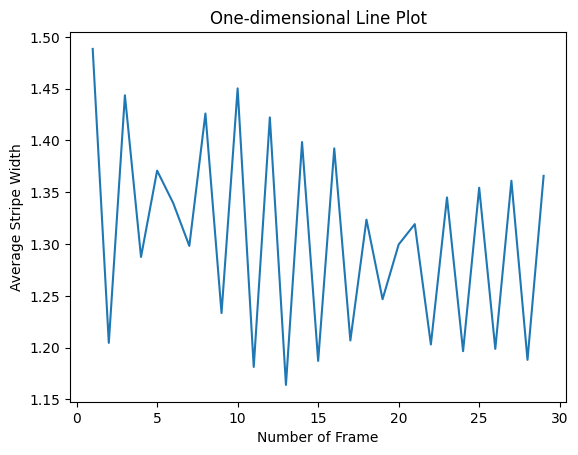

In [17]:
# plot the one-demensional line plot
x = range(len(average_stripe_list[0:30]))

plt.plot(x, average_stripe_list[0:30])

plt.title('One-dimensional Line Plot')
plt.xlabel('Number of Frame')
plt.ylabel('Average Stripe Width')

plt.show()